In [1]:
# data science libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import joblib

# data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# general tools
from tqdm import tqdm
# from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#get cell annotations
annot = pd.read_csv('cell-annotation.csv')
#get cell type categories
cells_cat = list(annot['cell.type'].unique())

with open('batch_list.txt') as f:
    batch_list = f.readlines()
#cleaning list    
batches = []
for b in batch_list:
    b = b.strip('/\n')
    batches.append(b)

In [ ]:
# ---------------------- Useful functions ----------------------
def drop_cols(cleaned_df,list_of_cols):
    constant_cols_count = 0
    nearly_constant_cols_count = 0
    cleaned_df = cleaned_df[list_of_cols]
    #now check if most common value of each col appears 90% of the time or more
    #if so, drop that column
    for cur_col in list_of_cols:
        # print(cur_col)
        if cleaned_df[cur_col].nunique() == 1: #check number of unique vals, if its all 1 then drop the column
            cleaned_df = cleaned_df.drop(cur_col, axis=1)
            # print('dropped bc 1 val:', cur_col)
            # print('constant: ', cur_col)
            constant_cols_count += 1
        elif cleaned_df[cur_col].nunique() > 1: #check number of unique vals, if its >1 then drop the column if >=90% of values are most common value
            #print(‘checking:’, cur_col)
            most_common_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().iloc[0] #number of times the most common value occurs
            total_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().sum() #total number of values in column
            percent_most_common_val = most_common_val_count/total_val_count #percentage of entries the most common entry accounts for
            if percent_most_common_val >= 0.90: #drop if >=99%
                print('dropped bc >=90%:', cur_col)
                cleaned_df = cleaned_df.drop(cur_col, axis=1)
                # print('90 percent constant: ', cur_col)
                nearly_constant_cols_count += 1
    return cleaned_df

def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def deconf(dff,conf):
        df = dff.copy()
        for col in df.columns:
                conf_with_bias = sm.add_constant(conf)
                model = sm.OLS(df[col],conf_with_bias).fit()
                df[col] = model.resid
        return df

def zscore(dff,col):
        df = dff.copy()
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        return df

#function for missing data imputation
def my_impute(dff, col):
    new_df = dff.copy()
    arr = pd.to_numeric(new_df[col])
    arr = np.array(arr)
    b_nan = np.isnan(arr)
    b_negative = arr < 0
    b_bad = b_nan | b_negative
    arr[b_bad] = np.random.choice(arr[~b_bad], np.sum(b_bad))
    new_df[col] = arr
    return new_df

In [4]:
# Initialize a set to store all unique genes
unique_genes = set()

# Load genes from each cell type and add to the set
for cell_type in tqdm(cells_cat, desc="Loading genes by cell type"):  
    genes_list = np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True)
    unique_genes.update(genes_list)

# Separate mitochondrial and nuclear genes
MT_genes = sorted([gene for gene in unique_genes if gene.startswith('MT-')])
nuc_genes = sorted(unique_genes - set(MT_genes))

# Compute overlapping genes across all cell types
overlap_genes = unique_genes.copy()
for cell_type in tqdm(cells_cat, desc="Computing overlap"):
    genes_list = set(np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True))
    overlap_genes = overlap(overlap_genes, genes_list)

overlap_genes = sorted(overlap_genes)
MT_genes = [gene for gene in overlap_genes if gene.startswith('MT-')]
nuc_genes = [gene for gene in overlap_genes if not gene.startswith('MT-')]

print("Mitochondrial genes:")
for gene in MT_genes:
    print(gene)

Computing overlap: 100%|██████████| 16/16 [00:00<00:00, 579.62it/s]

Mitochondrial genes:
MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


In [5]:
# ---------------------- Load clinical data ----------------------
clinic = pd.read_csv('ROSMAP_clinical_combined_cleaned.csv', index_col=0)
print(f'Clinical data shape: {clinic.shape}')

# Remove columns not needed for analysis
clinic_cols = [col for col in clinic.columns if col not in ['Study', 'individualID_y']]

# ---------------------- Separate AD and healthy individuals ----------------------
# AD patients
clin_ad = clinic.loc[clinic.dcfdx_ad == 1]
ad_clin_df = drop_cols(clin_ad, clinic_cols)

# Columns to keep for AD analysis / classification
ad_cols = list(ad_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_mci', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# Healthy individuals
clin_healthy = clinic.loc[clinic.dcfdx_ad == 0]
healthy_clin_df = drop_cols(clin_healthy, clinic_cols)

# Columns to keep for healthy analysis / classification
hc_cols = list(healthy_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# ---------------------- Identify overlapping columns ----------------------
all_clin_cols = overlap(hc_cols, ad_cols)  # Only keep columns present in both groups
all_clin_cols.append('cogdx')  # Add final column for analysis

# Remove duplicates while preserving order
seen = set()
no_dup = []
for col in all_clin_cols:
    if col not in seen:
        no_dup.append(col)
        seen.add(col)
    else:
        print(f'Found duplicate: {col}')

all_clin_cols = no_dup
print(f'Final clinical columns ({len(all_clin_cols)}): {all_clin_cols}')

Clinical data shape: (424, 64)
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: dcfdx_other
Found duplicate: e4_status
Found duplicate: cogdx_mci
Found duplicate: cogdx
Final clinical columns (57): ['individualID', 'projid', 'msex', 'educ', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'APOE_23.0', 'APOE_33.0', 'APOE_34.0', 'cogdx_mci', 'dcfdx_mci', 'cerad_binary', 'e4_status', 'study', 'scaled_to', 'neuroticism_12', 'apoe_genotype', 'age_bl', 'menoage', 'ldai_bl', 'smoking_bl', 'cancer_bl', 'gpath', 'amyloid', 'dlbdx', 'lb_7reg', 'nft', 'tangles', 'tdp_st4', 'arteriol_scler', 'caa_4gp', 'cvda_4gp2', 'ci_num2_gct', 'ci_num2_mct', 'ci_num2_tct

In [6]:
pls_cells = [
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Oligodendrocytes',
 'Astrocyte',
 'OPCs',
 'Microglia',
 'Endothelial',
 'Pericytes',
 'SMC',
 'Fibroblast',
 'all_immune_cells',
 'Macrophages',
 ]

#combining all immune cell together excluding macrophages
immune_cells = ['Monocytes','NK Cells','Neutrophils','CD8+ T Cells']

cells_order = [
 'Excitatory Neurons',
 'Oligodendrocytes',
 'Inhibitory Neurons',
 'Astrocyte',
 'Microglia',
 'OPCs',
 'Endothelial',
 'Fibroblast',
 'Pericytes',
 'Macrophages',
 'SMC',
 'all_immune_cells',
 ]

# Associations with clinical and pathological markers

In [7]:
# Computes the correlation coefficient between PLS scores and clinical measures
def compute_corrs(comps,clins_df):

    all_corrs = pd.DataFrame()
    p_vals = pd.DataFrame()
    for cols in clins_df.columns:

        corr = stats.kendalltau(comps,clins_df[cols])
        all_corrs[cols] = [float(corr[0])]
        p_vals[cols] = [float(corr[1])]

    return all_corrs.T, p_vals.T

In [8]:
to_drop = [
    'scaled_to',
    'study',
    'age_first_ad_dx',
    'cts_mmse30_first_ad_dx',
    'pmi',
    'apoe_genotype',
    'menoage',
    'APOE_33.0',
    'APOE_34.0',
    'APOE_23.0',
    'age_bl',
    'fu_year',
    'age_at_visit_max',
    'projid'
]

rename_cols = {
    'lb_7reg' : 'Lewy body load',
    'smoking_bl':'Baseline smoking status',
    'r_pd' : "Parkinson's-like symptoms",
    'dlbdx' : 'Pathologic diagnosis of Lewy Body disease',
    'braaksc' : 'Neurofibrillary tangle scores',
    'cvda_4gp2' : 'Cerebral atherosclerosis',
    'cogdx_other' : 'Clinical diagnosis: other dementia',
    'ldai_bl' : 'Lifetime daily alcohol intake',
    'ci_num2_gct' : 'Gross chronic infarcts',
    'dm_cum' : 'History of diabetes',
    'cts_mmse30_lv' : 'MMSE score',
    'pareduc' : 'Parental education',
    'educ' : 'Education',
    'neuroticism_12' : 'Neuroticism',
    'hypertension_cum' : 'Hypertension',
    'age_death' : 'Age at death',
    'cancer_bl' : 'Cancer',
    'ci_num2_mct' : 'Chronic microinfarcts',
    'cerad_binary' : 'Presence of neurite plaques',
    'ceradsc' : 'CERAD score',
    'gpath' : 'Global AD pathology burden',
    'soc_net' : 'Social network size',
    'amyloid' : 'Amyloid load',
    'r_depres' : 'Clinical depression',
    'ci_num2_tct' : 'Presence of one or more chronic infarcts',
    'tdp_st4' : 'TDP-43 stage',
    'cogn_global' : 'Global cognitive function',
    'arteriol_scler' : 'Arteriolosclerosis',
    'caa_4gp' : 'Cerebral amyloid angiopathy',
    'msex' : 'Sex',
    'phys5itemsum' : 'Physical activity',
    'tangles' : 'Tau Tangle Density',
    'nft' : 'Neurofibrillary tangle burden',
    'cogdx_mci' : 'Clinical diagnosis: MCI',
    'cogdx_ad' : 'Clinical diagnosis: Alzheimer\'s',
    'e4_status' : '\u03B54 status',
    'bmi': 'BMI',
}
ordered_clin_cols = [ 
  # AD specific
    # "Clinical diagnosis: Alzheimer's",
    # 'Clinical diagnosis: MCI',
    'Global AD pathology burden',
    'Global cognitive function',
    'MMSE score',
    'Presence of neurite plaques',
    'Amyloid load',
    'Tau Tangle Density',
    'Neurofibrillary tangle burden',
    'Neurofibrillary tangle scores',
    'ε4 status',
    'CERAD score',

  # PD specififc
   "Parkinson's-like symptoms",
   'Pathologic diagnosis of Lewy Body disease',
   'TDP-43 stage',
   'Lewy body load',

  # comorbidities
  #  'Clinical diagnosis: other dementia',
   'Cerebral amyloid angiopathy',
   'Cerebral atherosclerosis',
   'Arteriolosclerosis',
   'Gross chronic infarcts',
   'Chronic microinfarcts',
   'Presence of one or more chronic infarcts',
  #  'Presence of immune cells',
   'Clinical depression',
   'BMI',
   'Cancer',
   'History of diabetes',
   'Hypertension',
  
  #demographics
  # 'Sex',
  'Age at death',
  'Baseline smoking status',
  'Lifetime daily alcohol intake',
  'Education',
  'Neuroticism',
  'Parental education',
  'Physical activity',
  'Social network size']

ordered_clin_cols.reverse()

In [9]:
date = '08.13.25'
auc_scores = []
cv_scores = []
pls_path = f'{date}/MT_PLS'

coefs_df = pd.DataFrame()
for cell_type in pls_cells[0:6]:
    print(cell_type)

    pls = joblib.load(f'{pls_path}/pls_{cell_type}.gz')

    # Load deconfounded gene expression
    nuc = np.load(f'{pls_path}/gen_exp_{cell_type}_nuc.npy')
    MT = np.load(f'{pls_path}/gen_exp_{cell_type}_MT.npy')
    x_scores, y_scores = pls.transform(nuc,MT)

    clin = pd.read_csv(f'{pls_path}/{cell_type}_clin_data.csv',index_col=0)

    # Subsetting males and females
    idx_m = np.where(clin.msex==1)
    idx_f = np.where(clin.msex==0)
    sex = {'males': idx_m, 'females': idx_f}

    for sex_value, key in sex.items():

        print(sex_value)

        nuc = x_scores[key]
        clin_sex = clin.iloc[key].reset_index(drop=True)

        # Excluding MCI or other cognitive impairment
        mci_bool = ((clin_sex.cogdx_mci==1)|(clin_sex.cogdx_other==1)).ravel()
        nuc = nuc[~mci_bool]
        clin_sex_no_mci = clin_sex.loc[~mci_bool].reset_index(drop=True)

        sex_coefs = []
        sex_pvals = []
        for comp in tqdm(range(0,13)):
            x = nuc[:,comp::13]
            corr_coefs, p_vals = compute_corrs(x, 
                                               clin_sex_no_mci.rename(columns=rename_cols)[ordered_clin_cols].reset_index())
            corr_coefs.columns = [f'comp_{comp+1}']
            p_vals.columns = [f'comp_{comp+1}']

            sex_coefs.append(corr_coefs)
            sex_pvals.append(p_vals)

        sex_df = pd.concat(sex_coefs, axis=1)
        sex_df.to_csv(f'material/RADC/coefs/{sex_value}/model_1_{cell_type}.csv')

        pval_df = pd.concat(sex_pvals, axis=1)
        pval_df.to_csv(f'material/RADC/pvals/{sex_value}/model_1_{cell_type}_pval.csv')



Excitatory Neurons
males


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


females


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Inhibitory Neurons
males


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


females


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Oligodendrocytes
males


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


females


100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


Astrocyte
males


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


females


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


OPCs
males


100%|██████████| 13/13 [00:01<00:00, 11.19it/s]


females


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Microglia
males


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


females


100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


In [10]:
cells = cells_order[0:6].copy()
cells.reverse()

In [11]:
def heatmap(x, y, **kwargs):

    """
    Creates a scatter-based heatmap with optional color and size mapping, including legends.

    Parameters
    ----------
    x : list or array-like
        Categories or coordinates along the x-axis.
    y : list or array-like
        Categories or coordinates along the y-axis.
    **kwargs : dict
        Optional keyword arguments:
        - color : list or array-like
            Values mapped to colors of the points.
        - palette : list
            Color palette used for mapping values to colors.
        - color_range : tuple
            (center, min, max) range of values mapped to colors.
        - size : list or array-like
            Values mapped to sizes of the points.
        - size_range : tuple
            (min, max) range of values mapped to point sizes.
        - size_scale : float
            Scaling factor for point sizes.
        - x_order : list
            Custom order of x categories.
        - y_order : list
            Custom order of y categories.
        - xlabel, ylabel : str
            Axis labels.
        - x_tick_rotation, y_tick_rotation : int
            Rotation of tick labels.
        - fontsize : int
            Font size for tick labels.
        - num_size_label : int
            Number of labels shown on the size legend.
        - size_labels : list
            Custom size labels for the size legend.
        - facecolor : str
            Background color of the heatmap.
        - marker : str
            Marker style for points.
        - m_color : str
            Color of points in the size legend.
        - Additional plotting arguments are passed to matplotlib.scatter.

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes of the main heatmap plot.
    ax1 : matplotlib.axes.Axes
        Axes of the color legend.
    ax2 : matplotlib.axes.Axes
        Axes of the size legend.
    size_labels : list
        Numeric labels used for the size legend.

    Notes
    -----
    - Both color and size can be used to encode values in the heatmap.
    - Includes automatic legends for color and size.
    - Handles categorical or numeric axes and allows custom ordering.
    """

    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_center, color_min, color_max = kwargs['color_range']
    else:
        color_center, color_min, color_max = np.mean(color), min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    x_rot = kwargs.get('x_tick_rotation', 45)
    y_rot = kwargs.get('y_tick_rotation', 0)
    fontsize = kwargs.get('fontsize', 14)
    num_size_label = kwargs.get('num_size_label', 4)
    size_labels = kwargs.get('size_labels', [])
    facecolor = kwargs.get('facecolor', '#FFFFFF')

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val, size_scale = size_scale):
        if val==-1:
            return 0
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
        
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in set([v for v in x])]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in set([v for v in y])]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 21, hspace=1, wspace=0) # Setup a 1x10 grid

    ax = plt.subplot(plot_grid[:,:16]) # Use the left 14/16ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', \
         'marker', 'x_order', 'y_order', 'xlabel', 'ylabel', 'x_tick_rotation', \
         'y_tick_rotation','fontsize', 'num_size_label','m_color', 'size_labels', 'facecolor'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k+1 for k in x_to_num], rotation=x_rot, horizontalalignment='right', fontsize=fontsize)
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num], rotation=y_rot, fontsize = fontsize)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor(facecolor)

    ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=fontsize)
    ax.set_ylabel(kwargs.get('ylabel', ''), fontsize=fontsize)

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax1 = plt.subplot(plot_grid[:,-3]) # Use the rightmost-1 column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax1.barh(
            y=bar_y,
            width=[1.33]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0,
        )
        ax1.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax1.grid(False) # Hide grid
        ax1.set_xticks([]) # Remove horizontal ticks
        ax1.set_yticks(np.linspace(min(bar_y), max(bar_y), 5), labels =np.linspace(min(bar_y), max(bar_y), 5).round(1), fontsize=14) # Show vertical ticks for min, middle and max
        ax1.yaxis.tick_left() # Show vertical ticks on the right
        
    for spine in ax1.spines.values():
        spine.set_visible(False)

    # Plot the size reference
    ax2 = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot 
    print(y_to_num)
    size_labels = np.linspace(kwargs['size_range'][0], kwargs['size_range'][1], num_size_label).tolist()
    y_len = len(size_labels)
    ss = size_labels + [-1]*(y_len-len(size_labels))
    print(ss)
    print([value_to_size(v, size_scale=size_scale) for v in ss])
    ax2.scatter(
        x=[2]*y_len,
        y=np.arange(0,y_len),
        marker=marker,
        s=[value_to_size(v, size_scale=size_scale) for v in ss],
        c=kwargs.get('m_color','black'),
        **kwargs_pass_on
    )
    ax2.grid(False) # Hide grid
    ax2.set_facecolor('white')
    ax2.set_xticks([])
    ax2.set_yticks(np.arange(0,y_len), labels = ss, fontsize=14)

    ax2.yaxis.tick_right()

    ax2.patch.set_visible(False) 
    for spine in ax2.spines.values():
        spine.set_visible(False)

    return ax, ax1, ax2, size_labels


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


males
Social network size
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


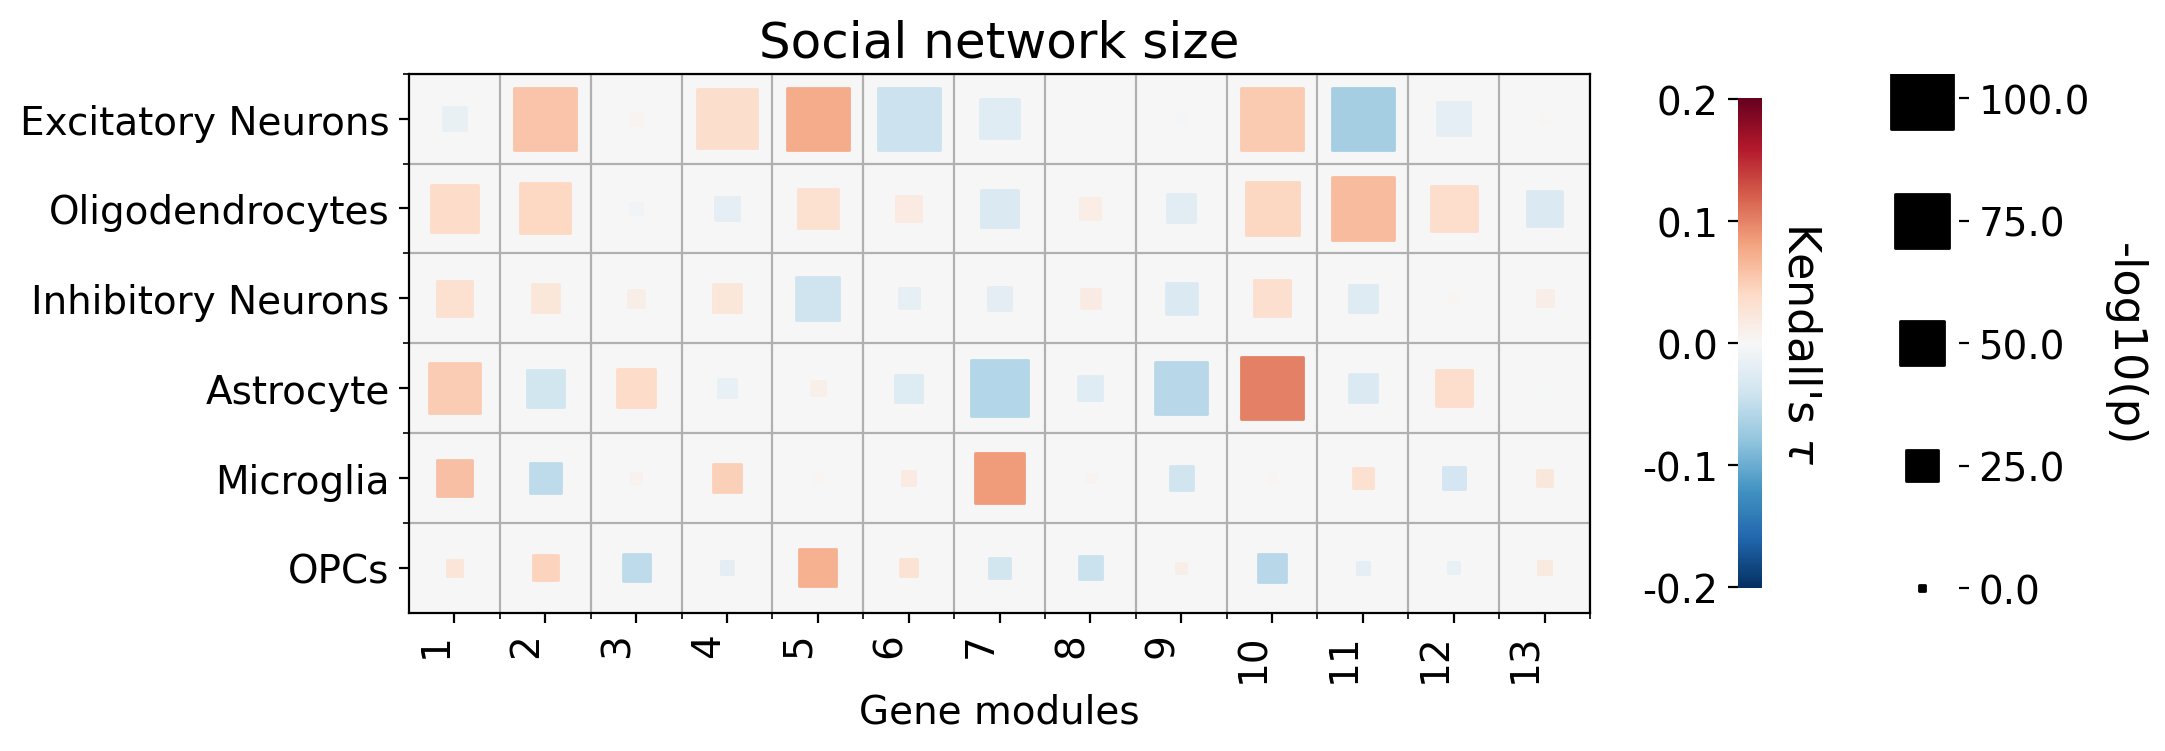

Physical activity
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


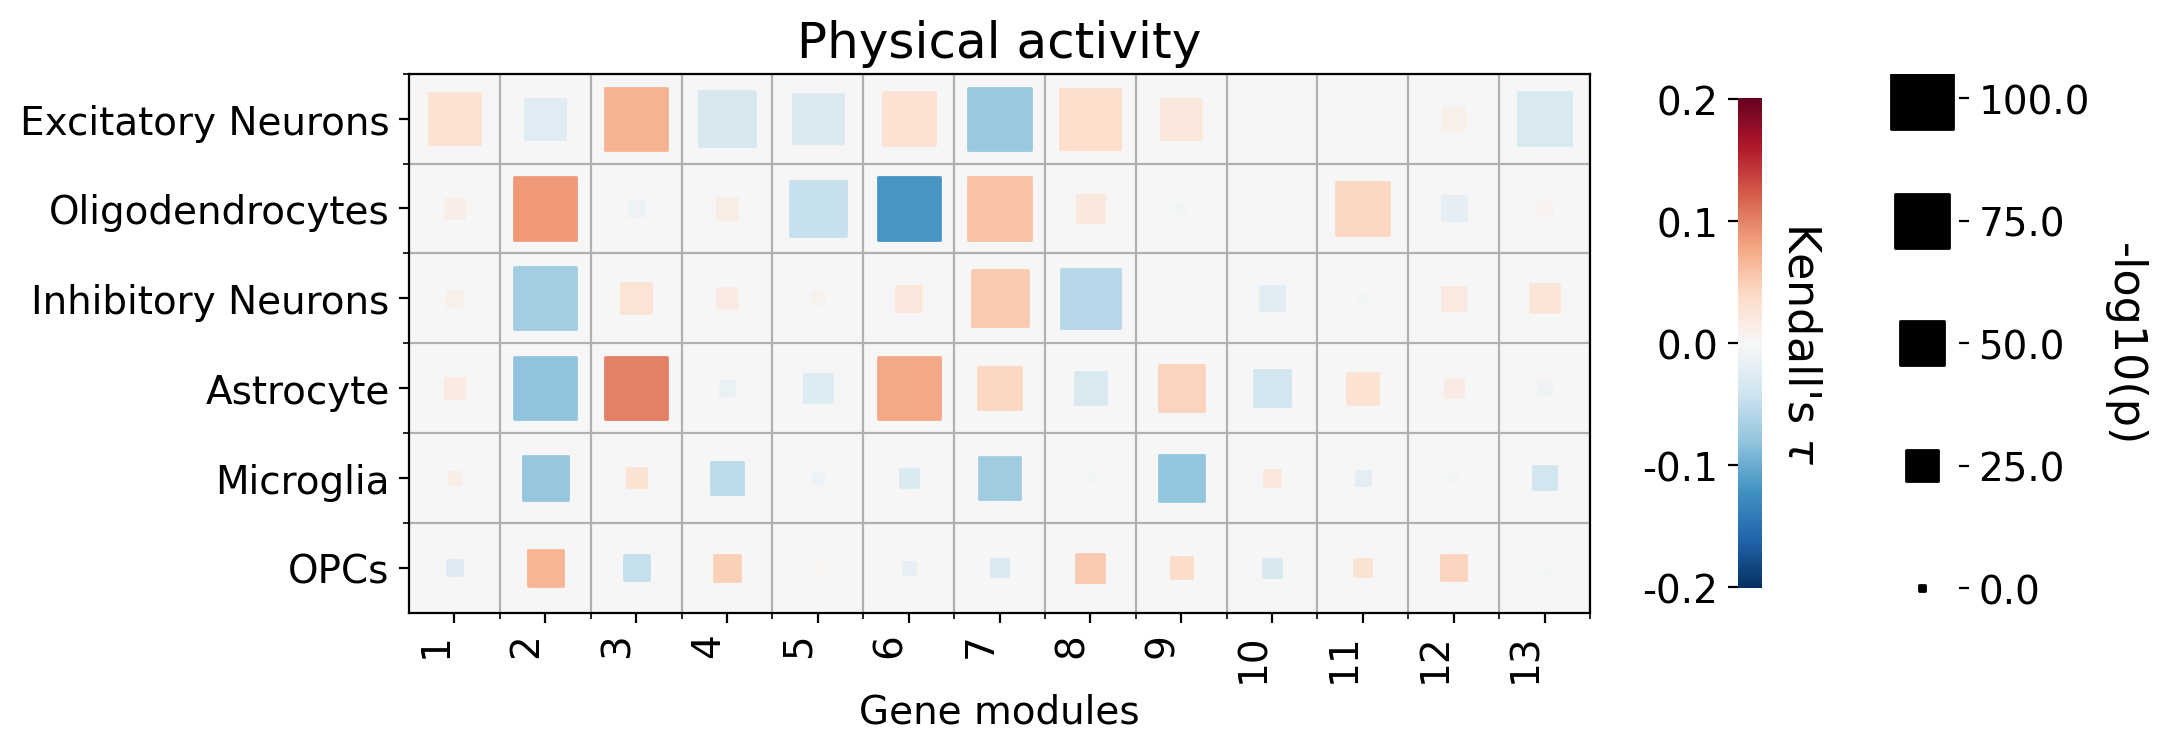

Parental education


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


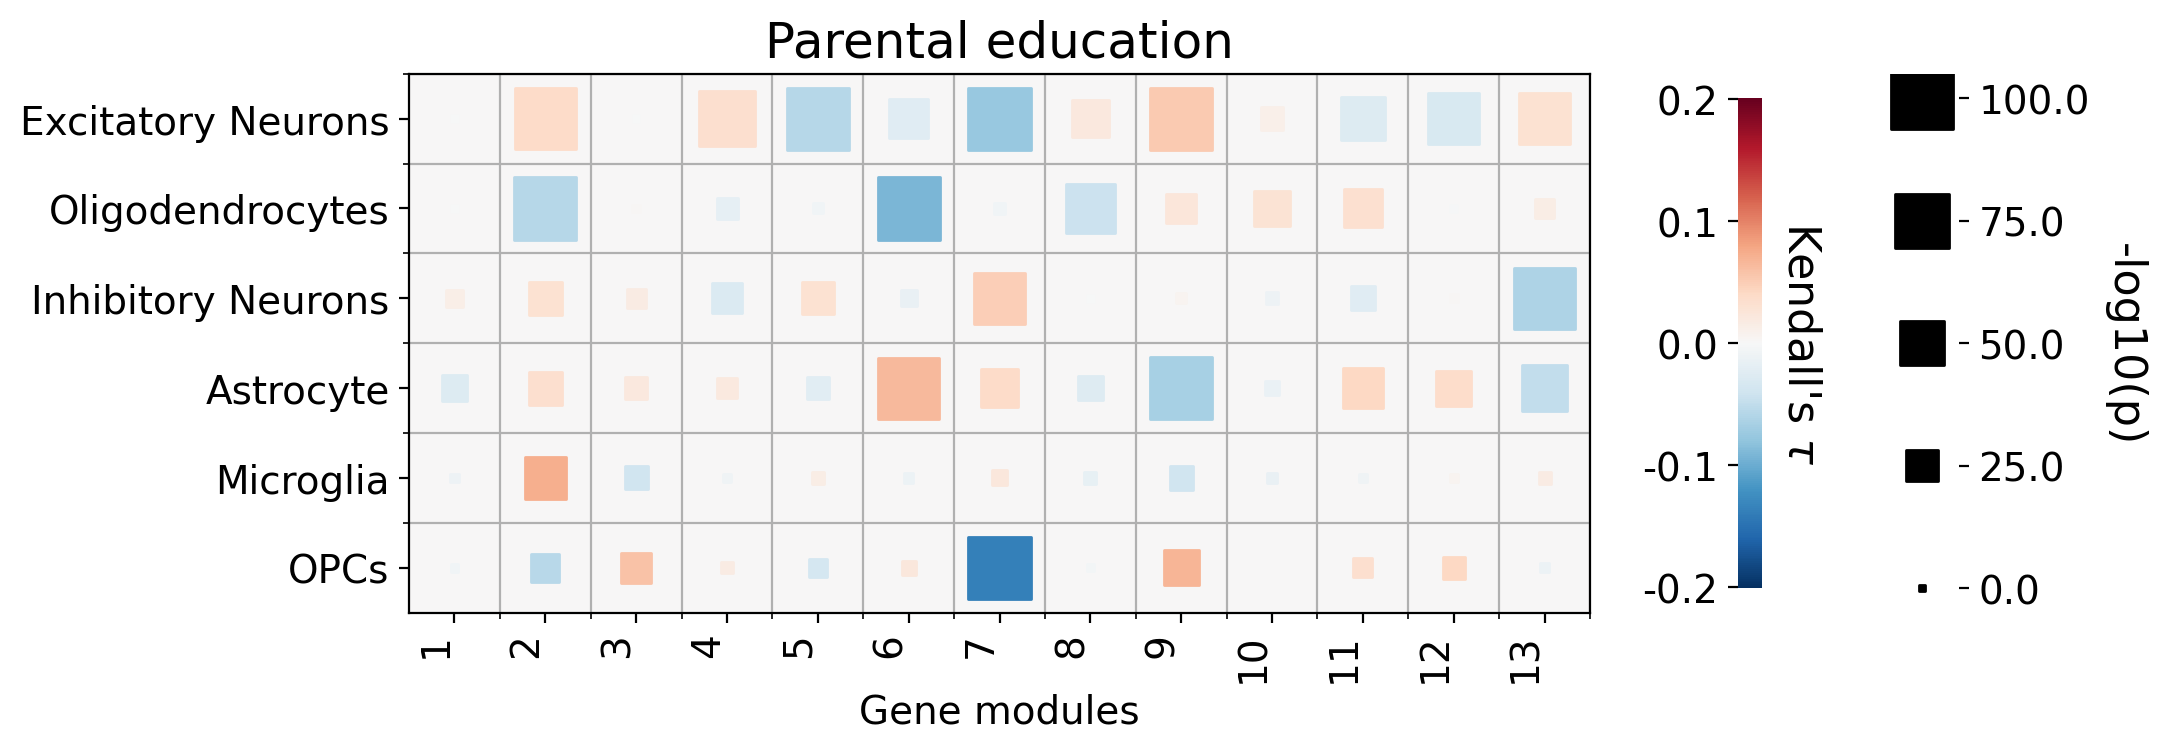

Neuroticism
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


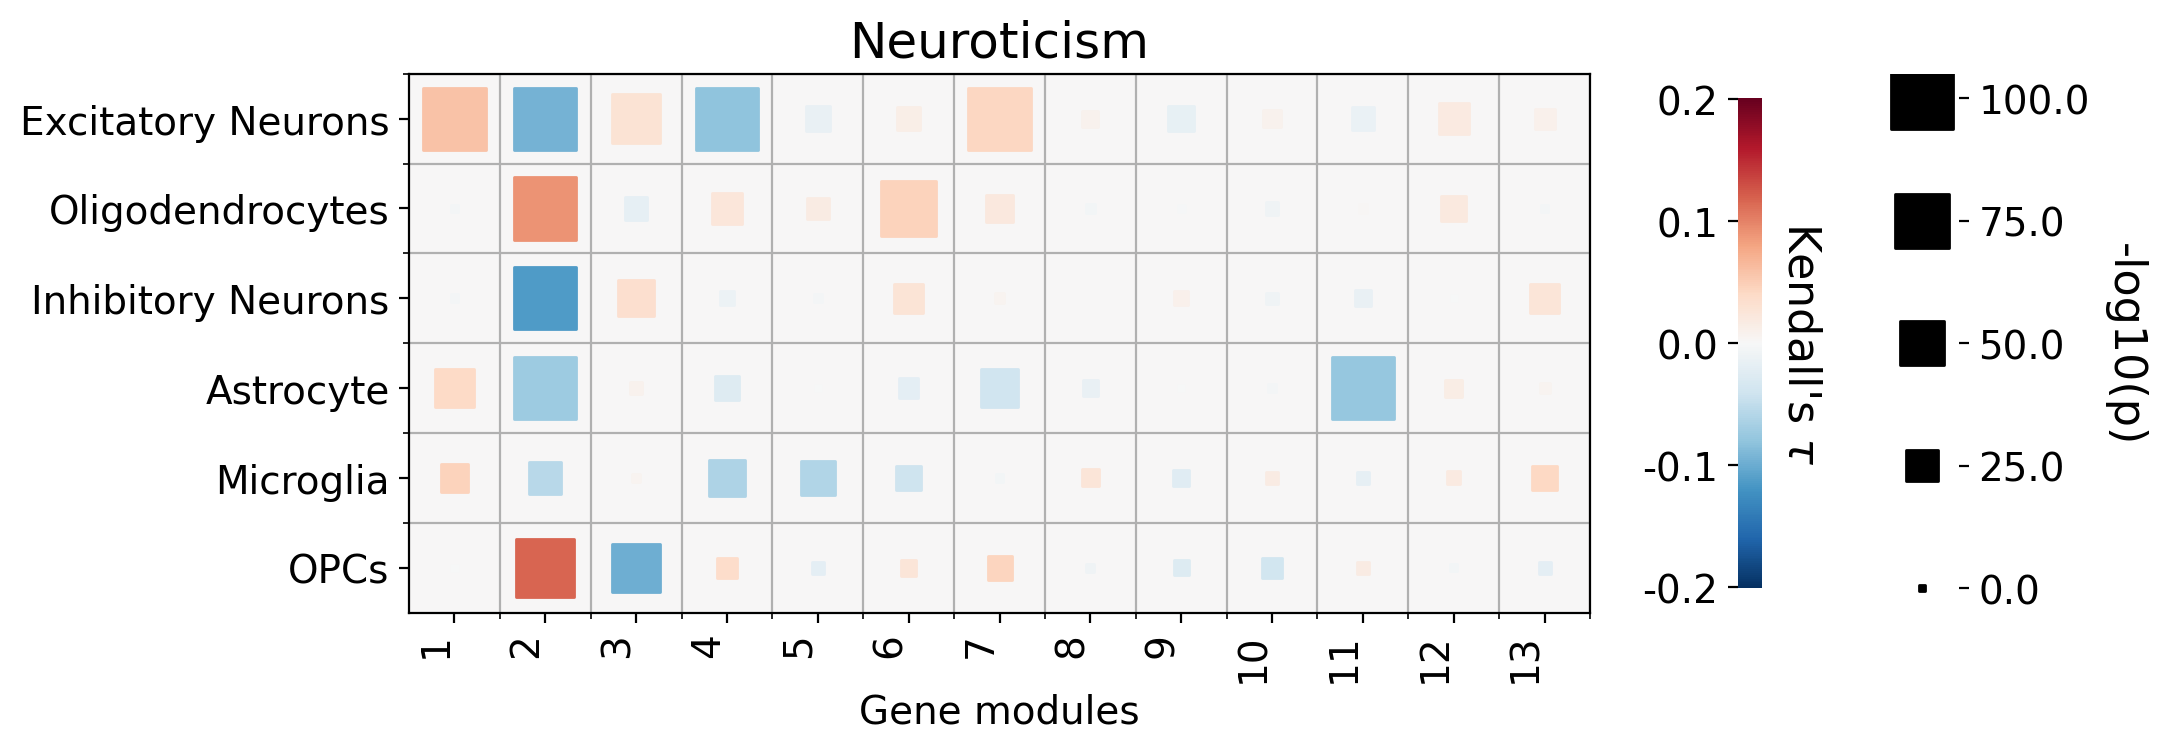

Education
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


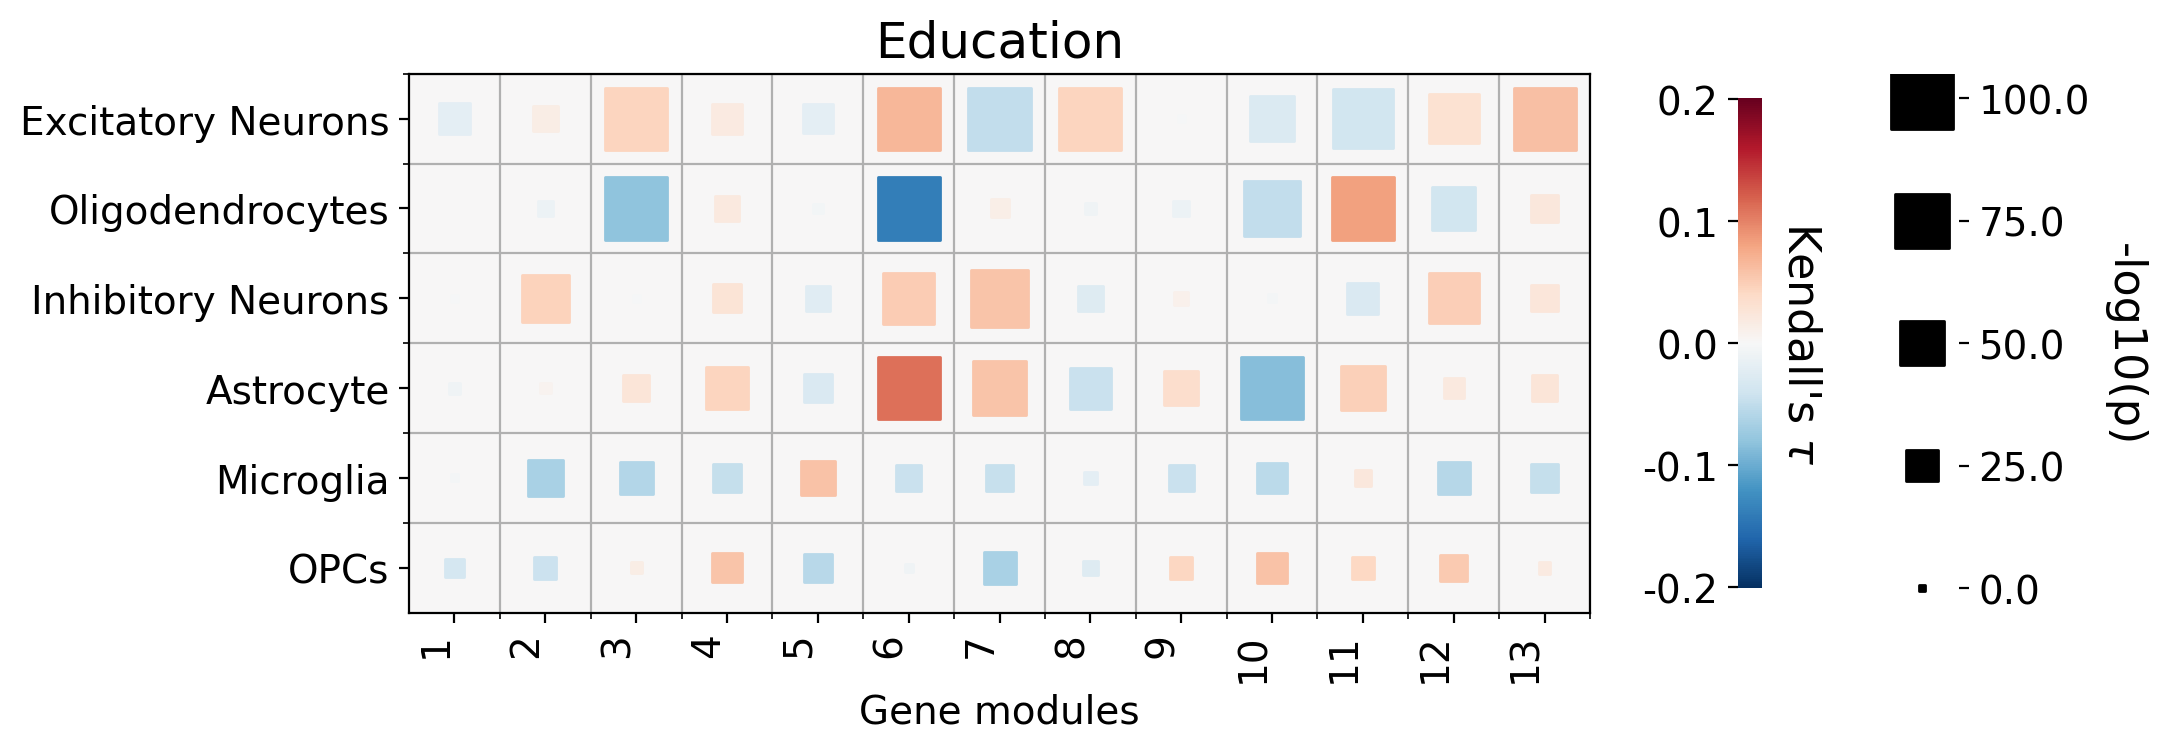

Lifetime daily alcohol intake
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


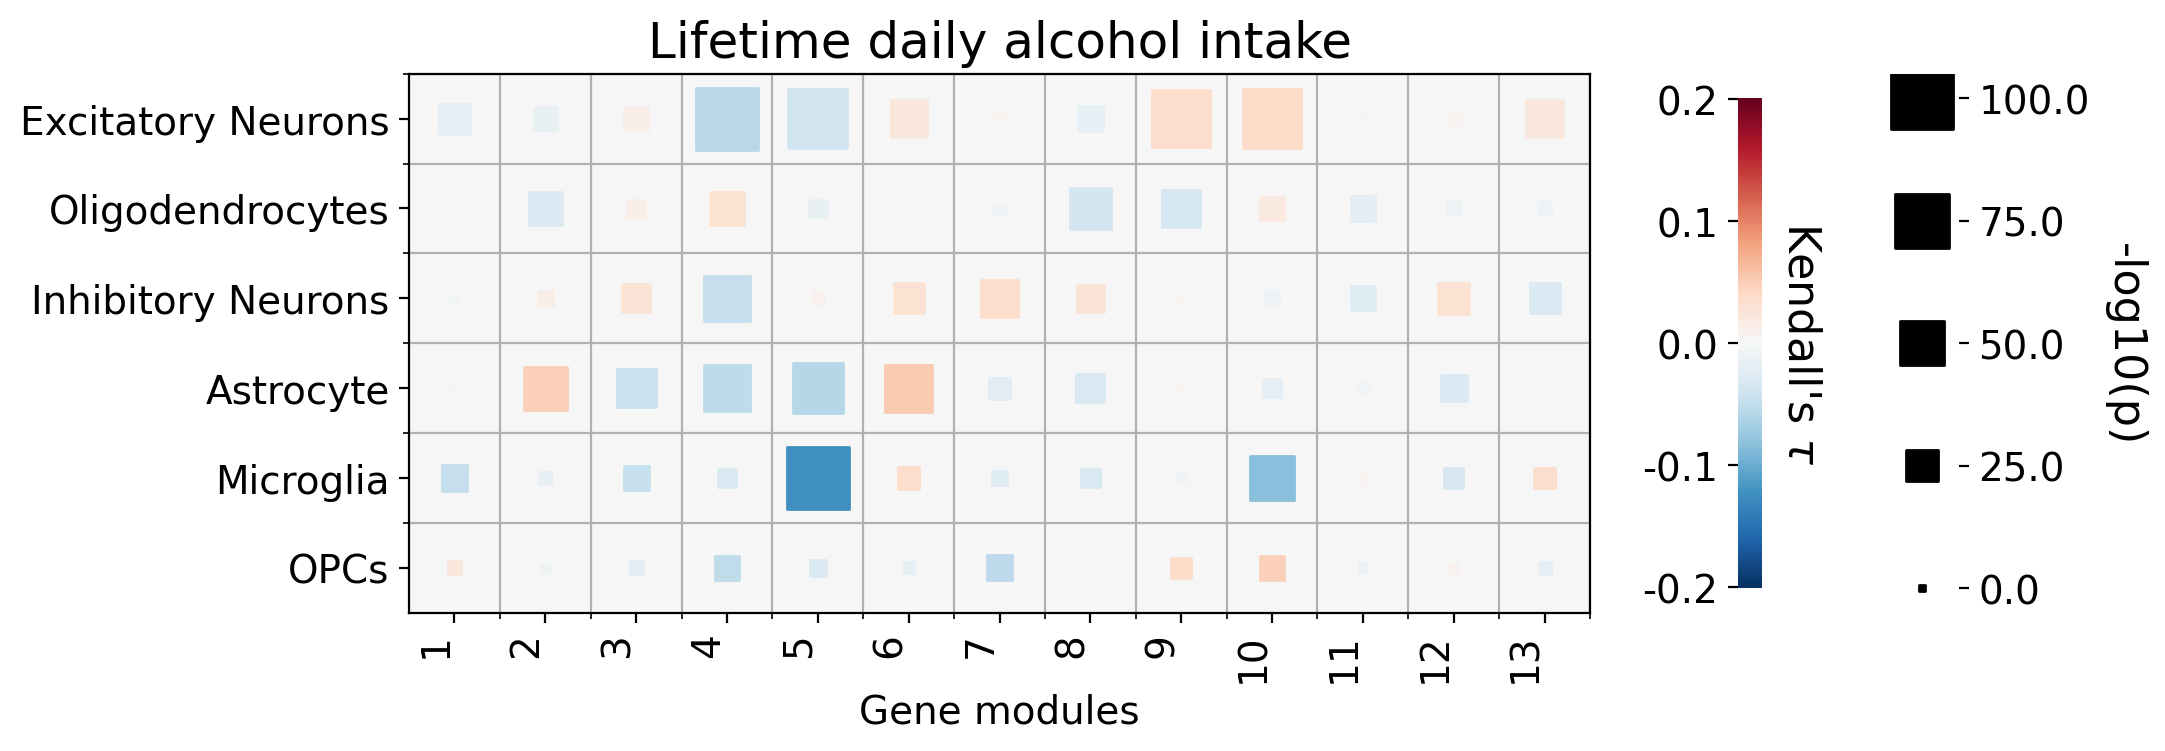

Baseline smoking status


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


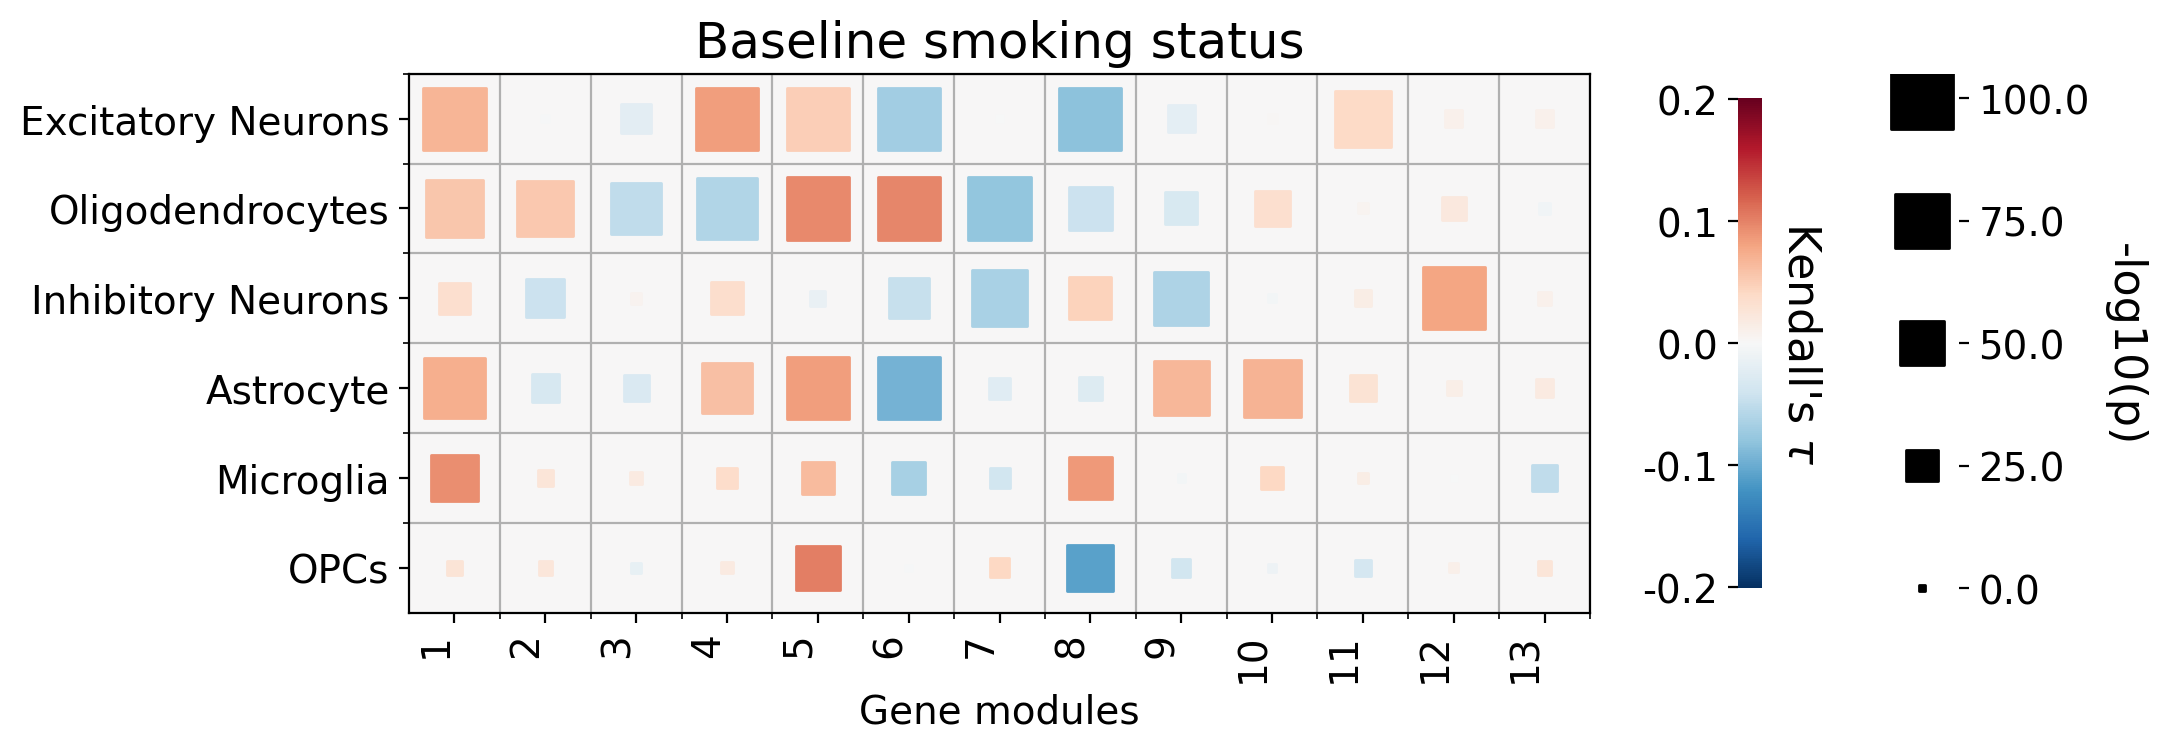

Age at death
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


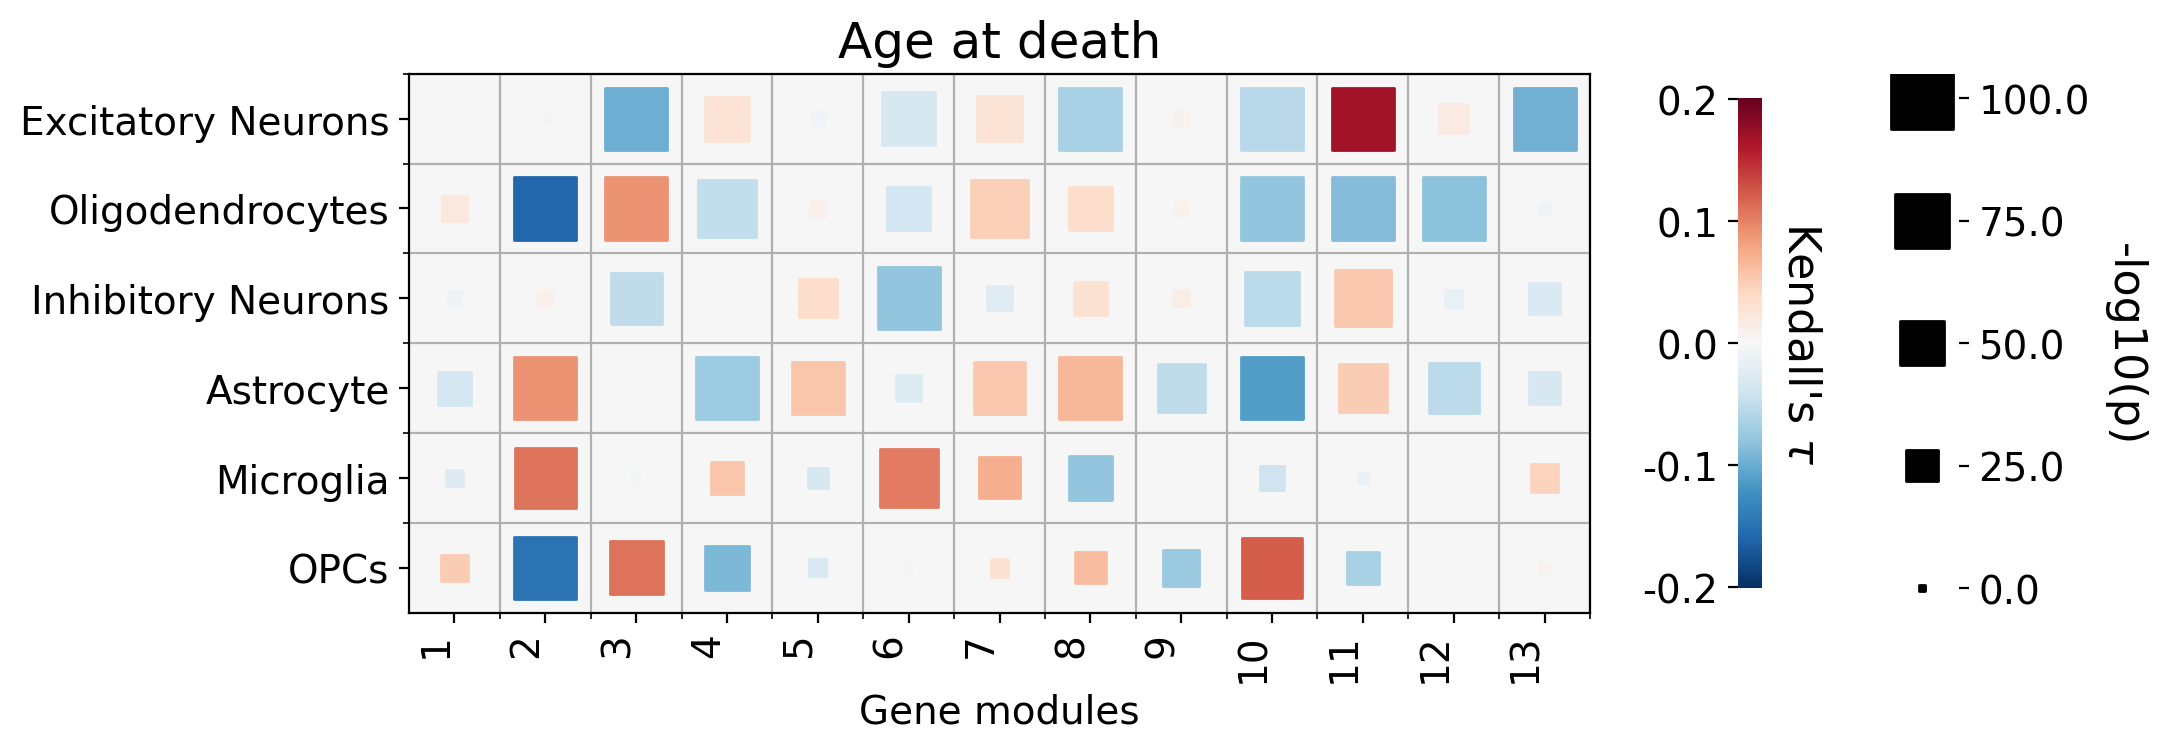

Hypertension
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


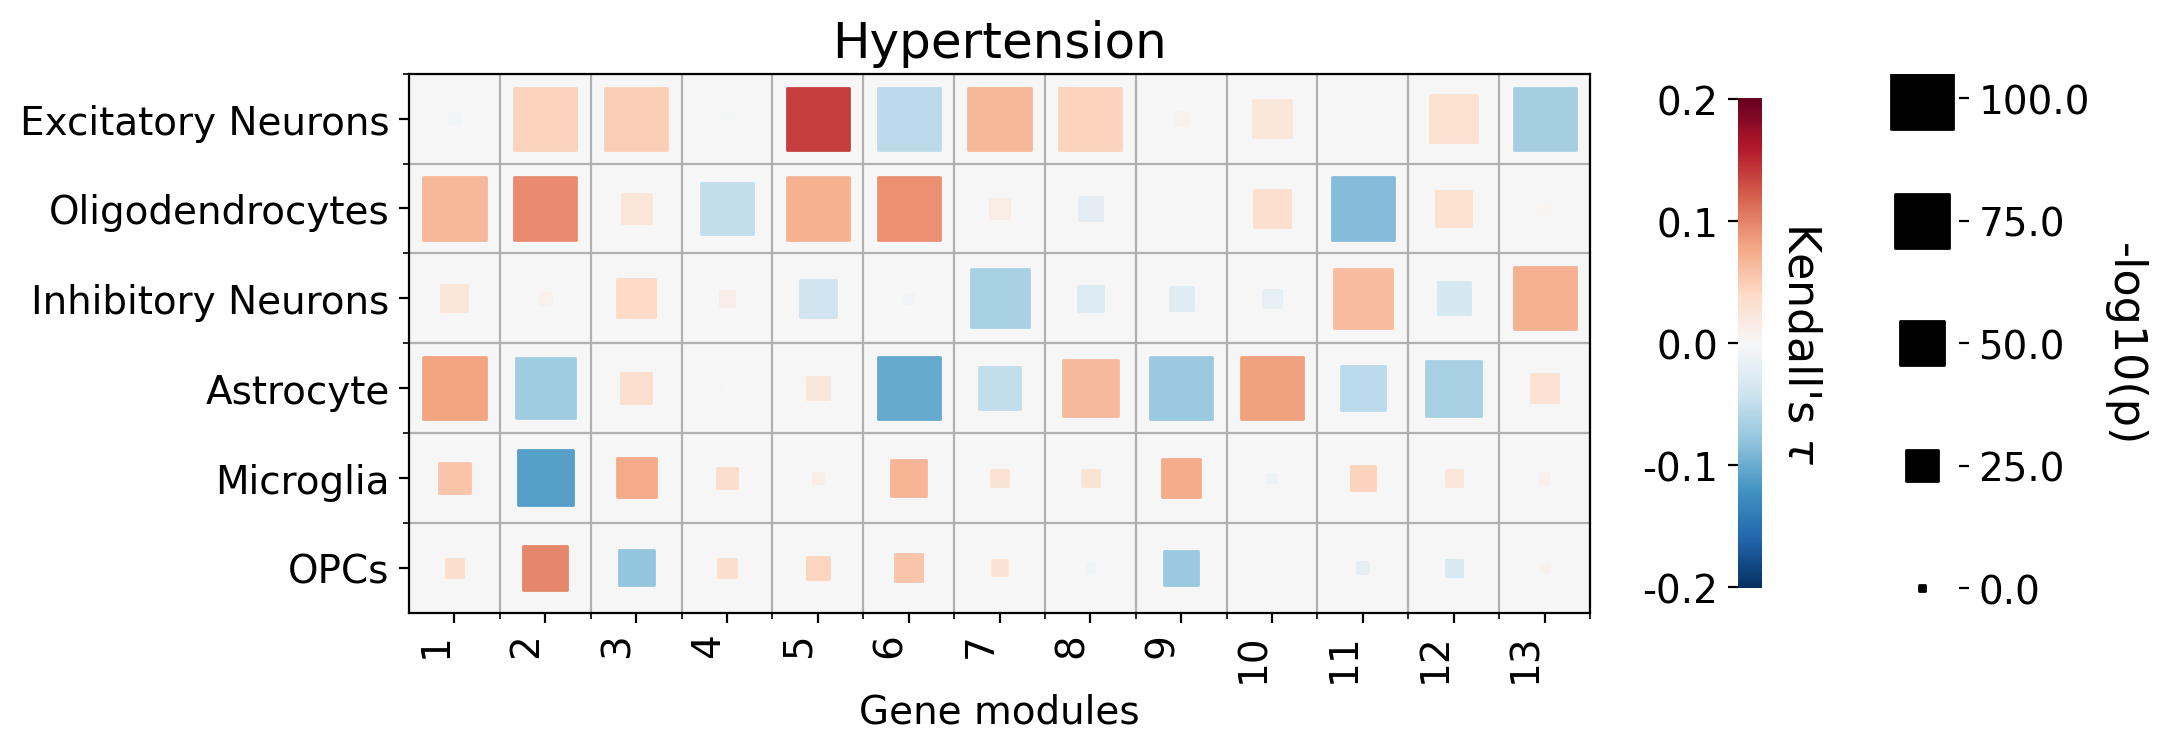

History of diabetes


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


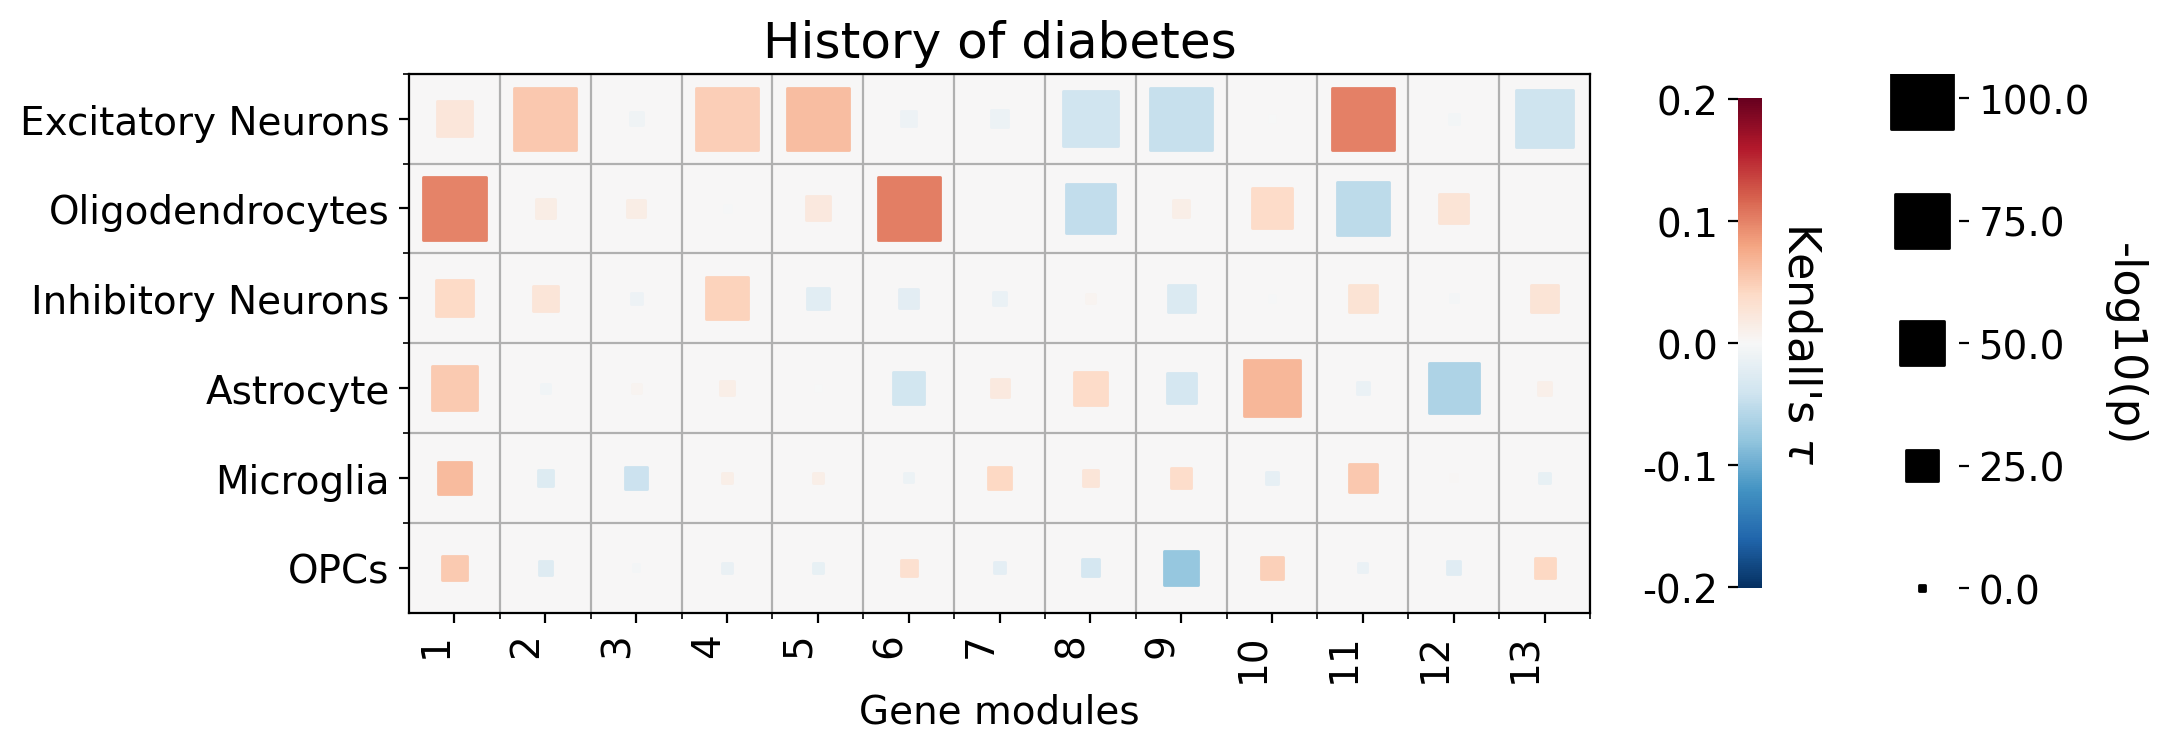

Cancer
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


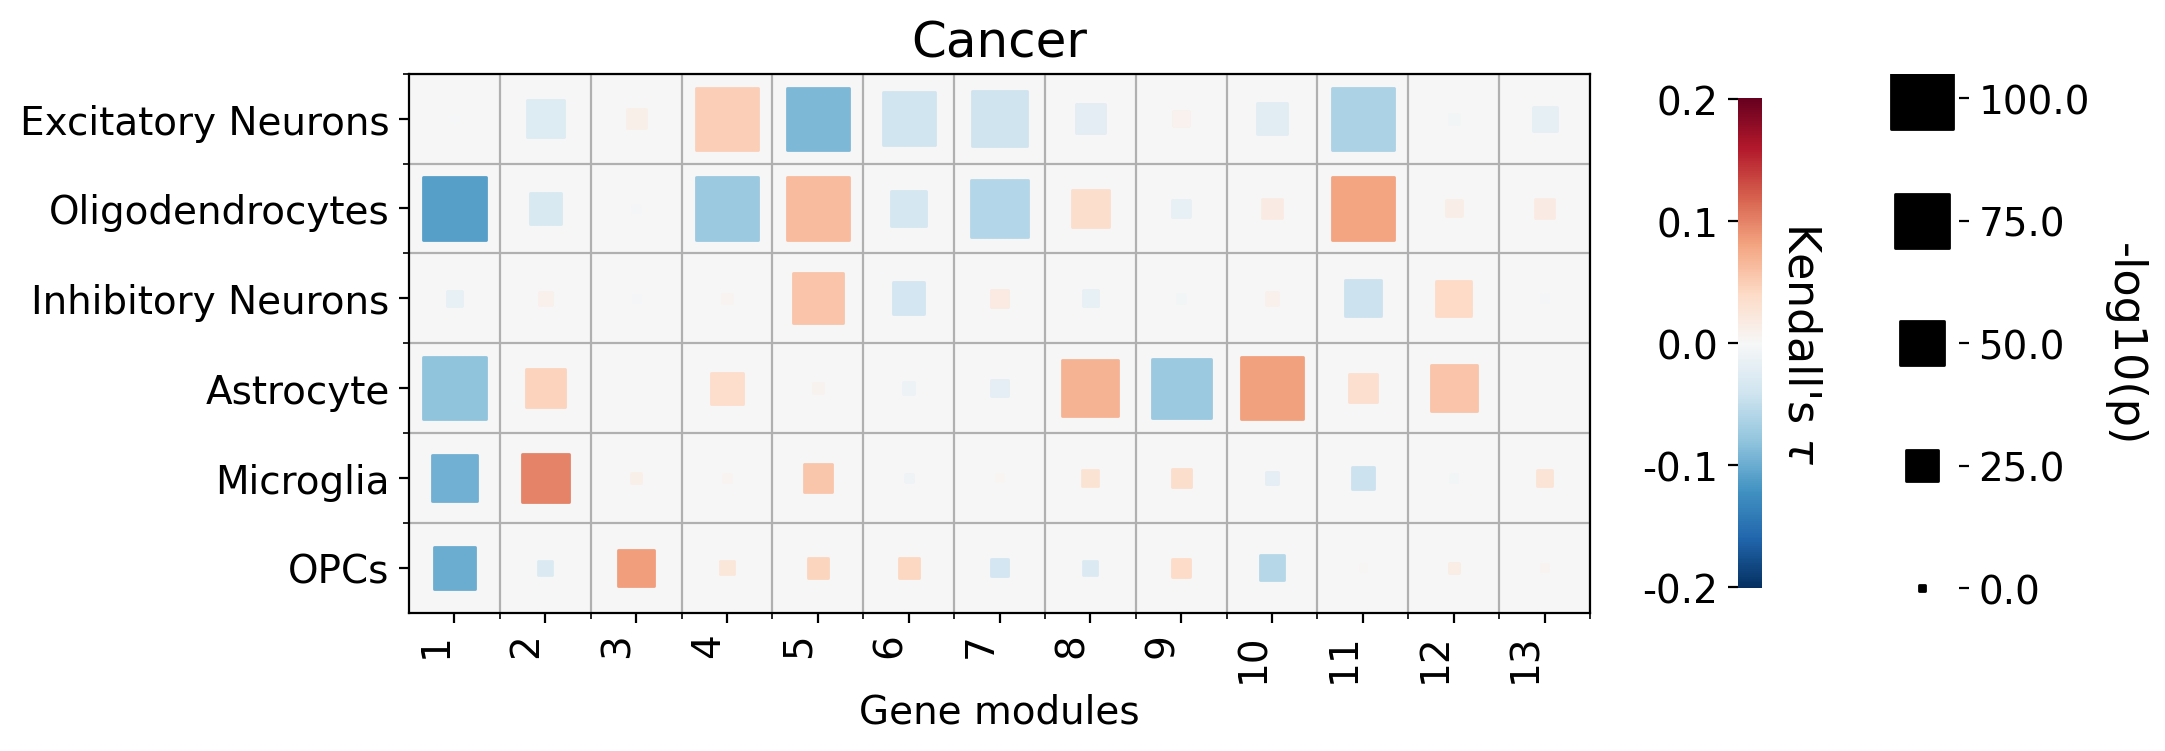

BMI
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


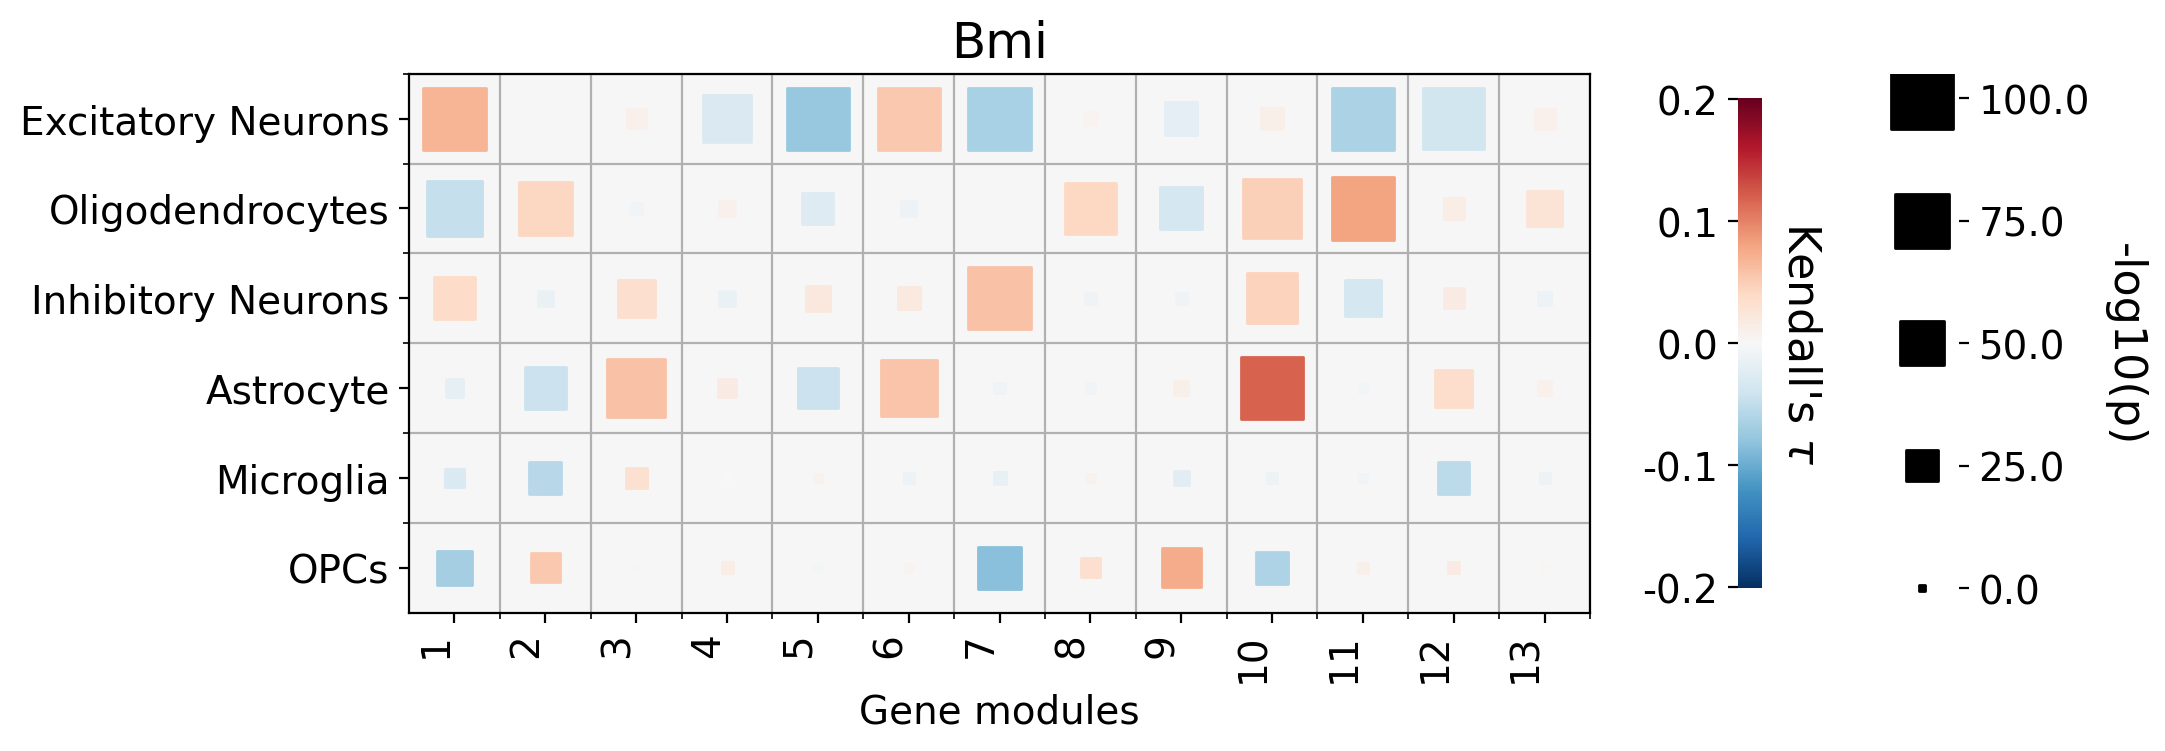

Clinical depression


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


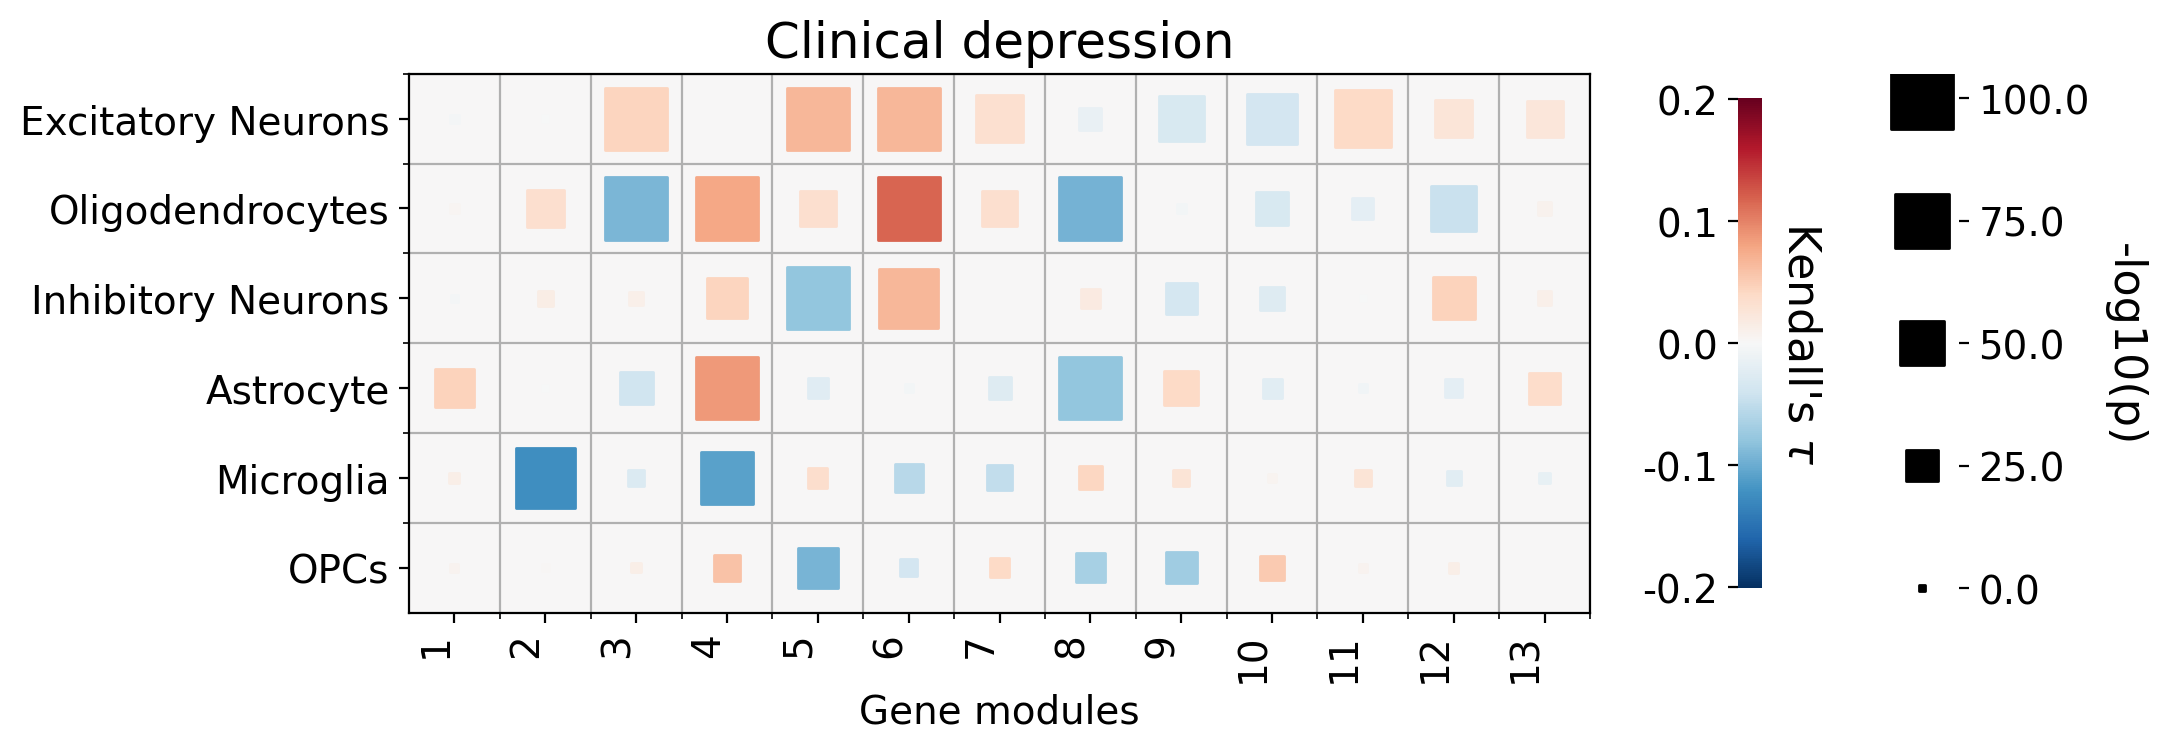

Presence of one or more chronic infarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


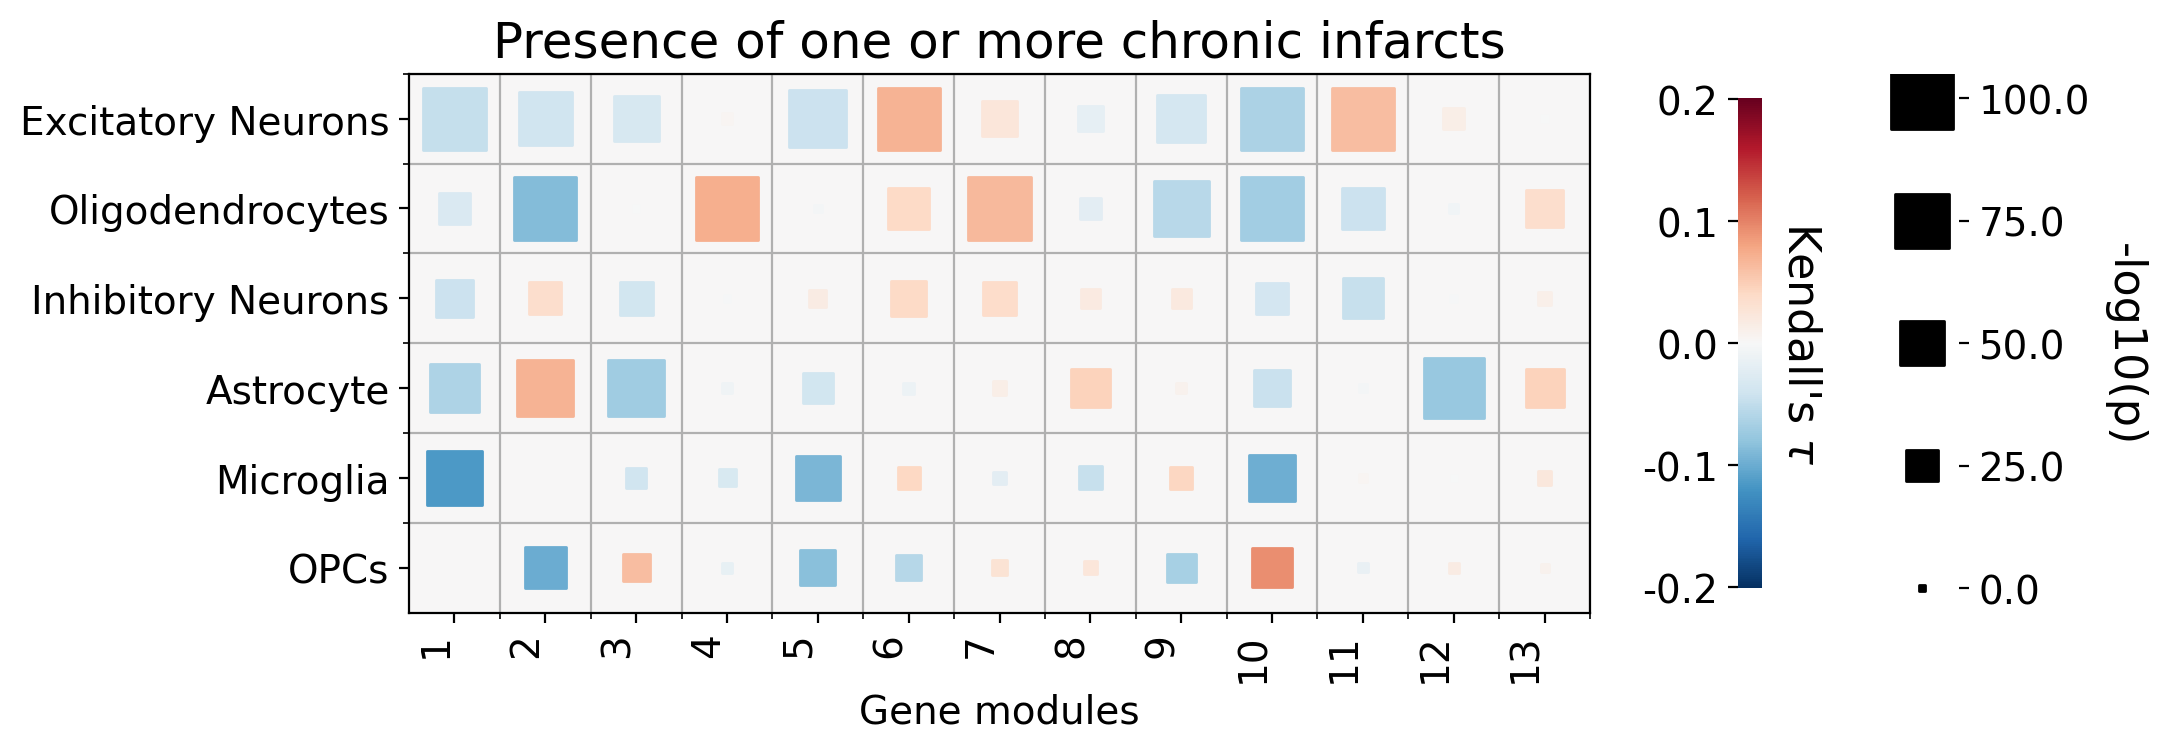

Chronic microinfarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


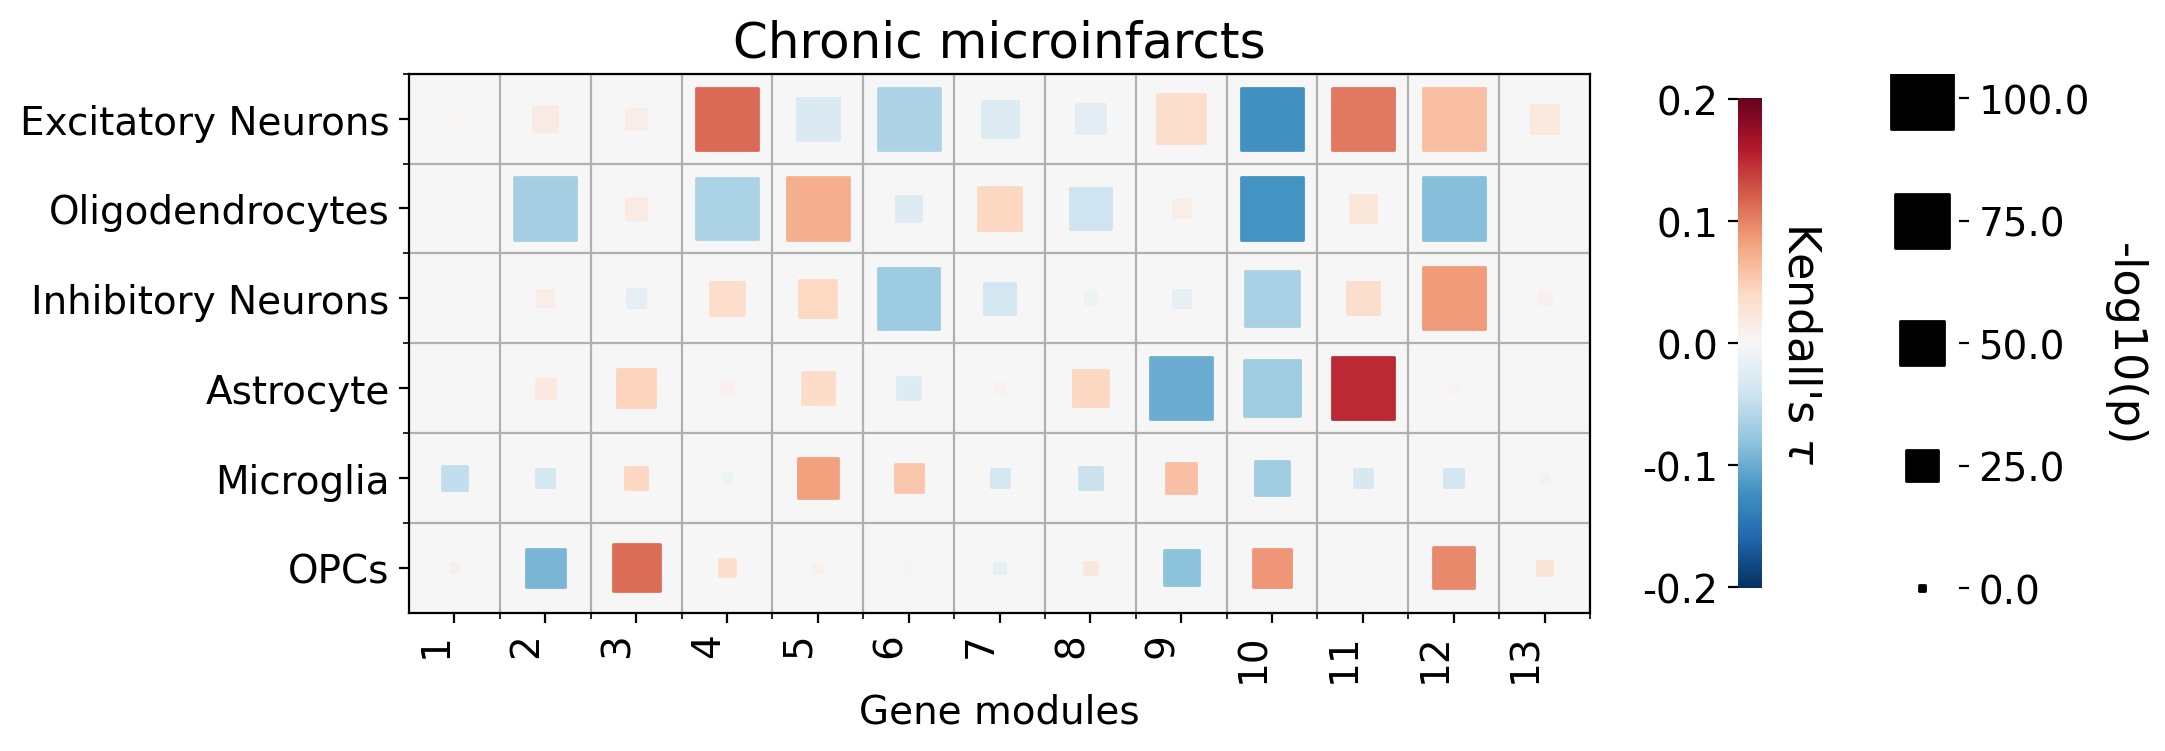

Gross chronic infarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


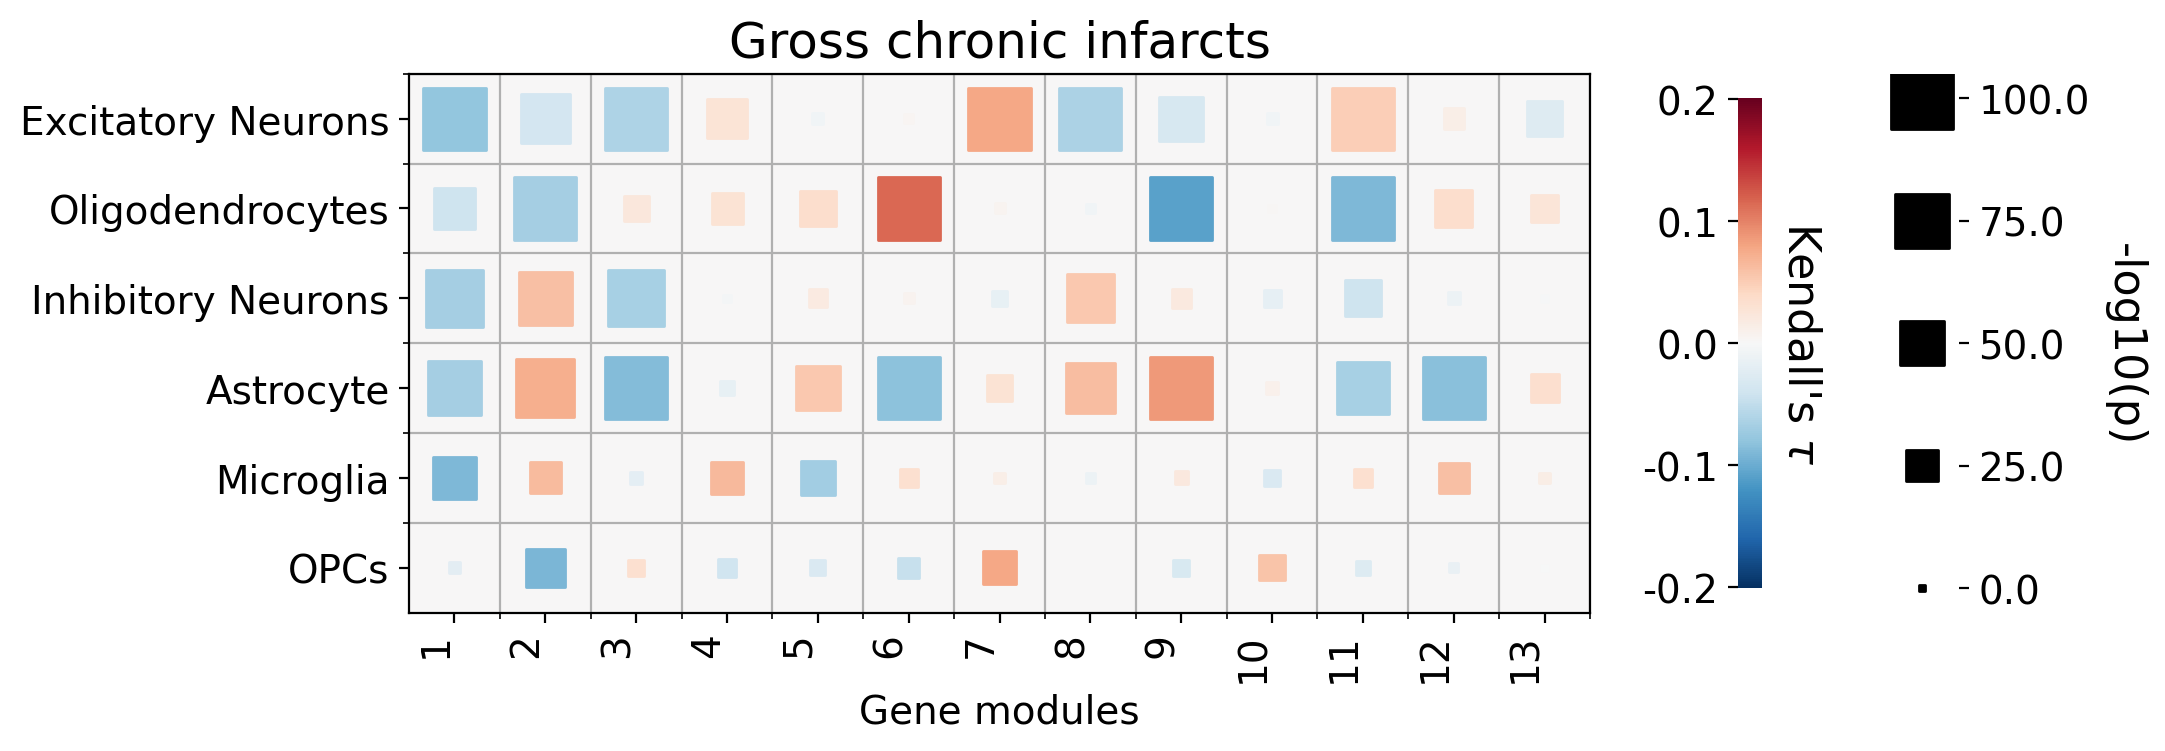

Arteriolosclerosis


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


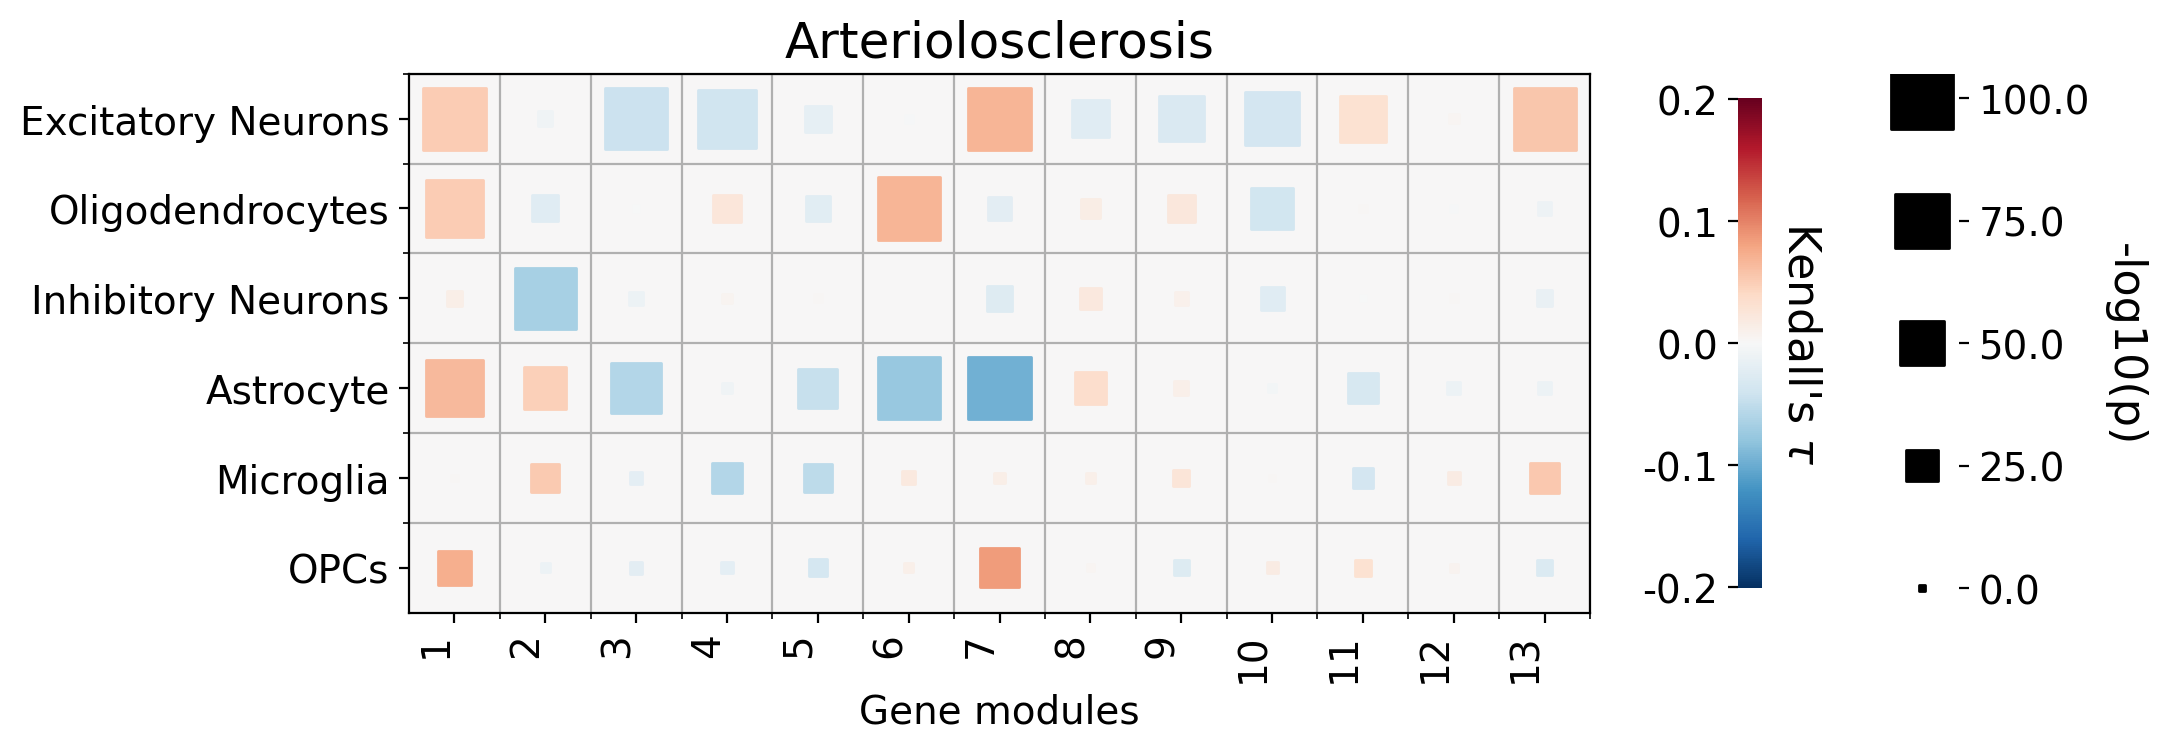

Cerebral atherosclerosis
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


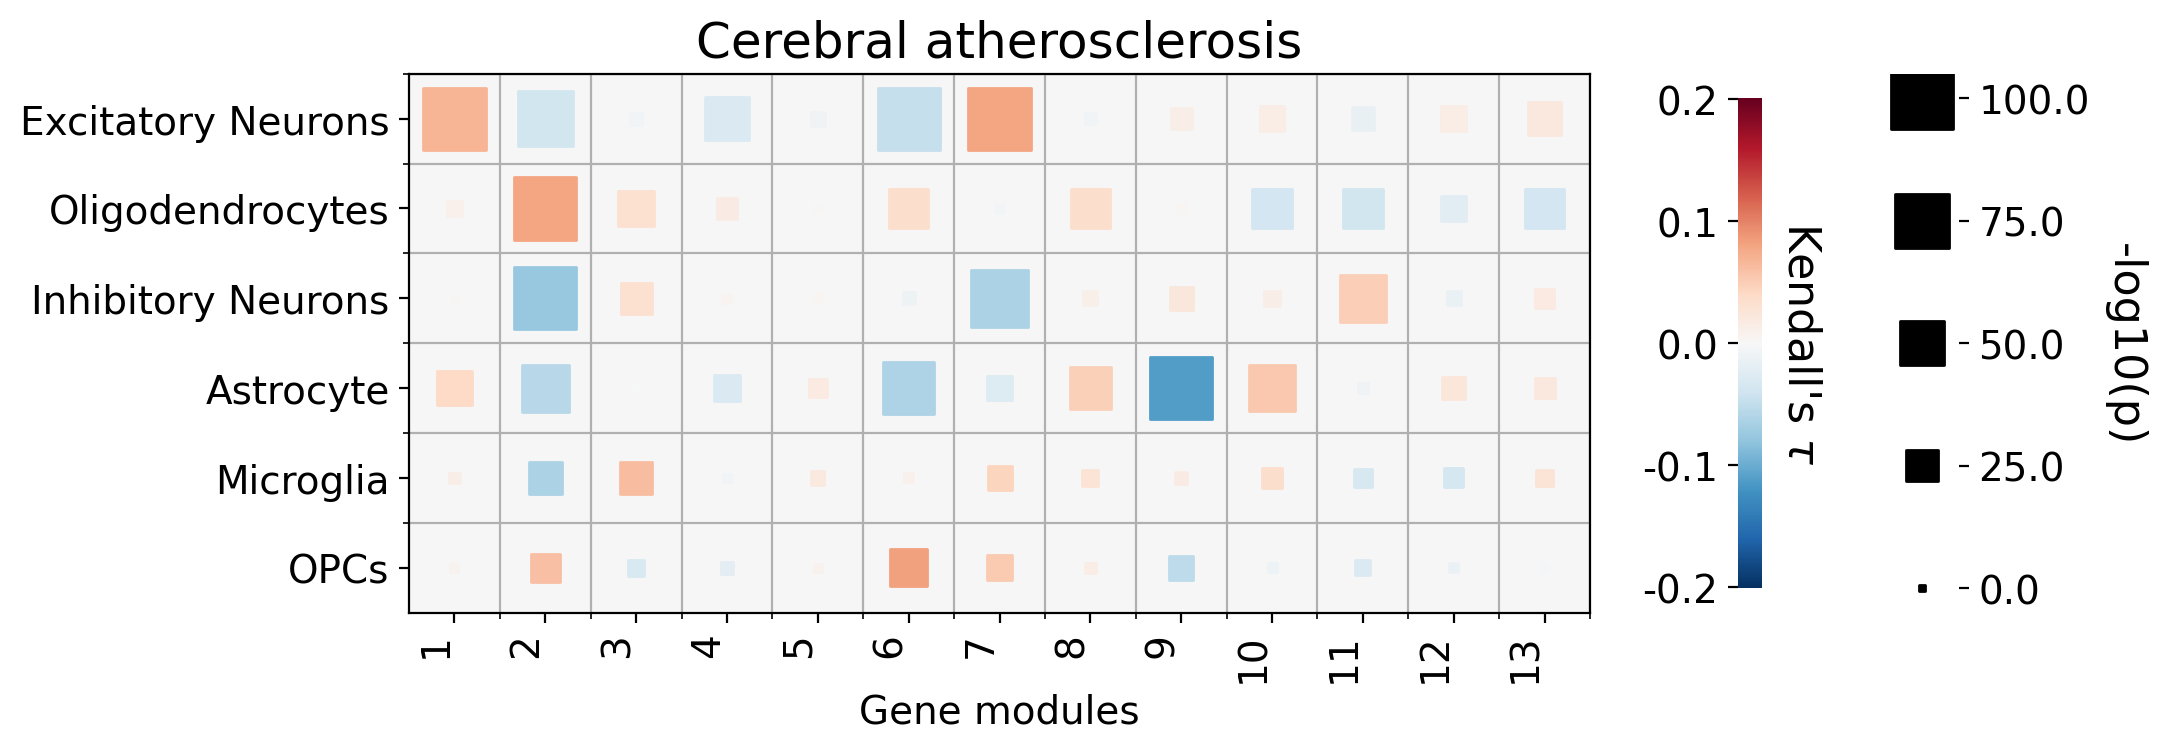

Cerebral amyloid angiopathy
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


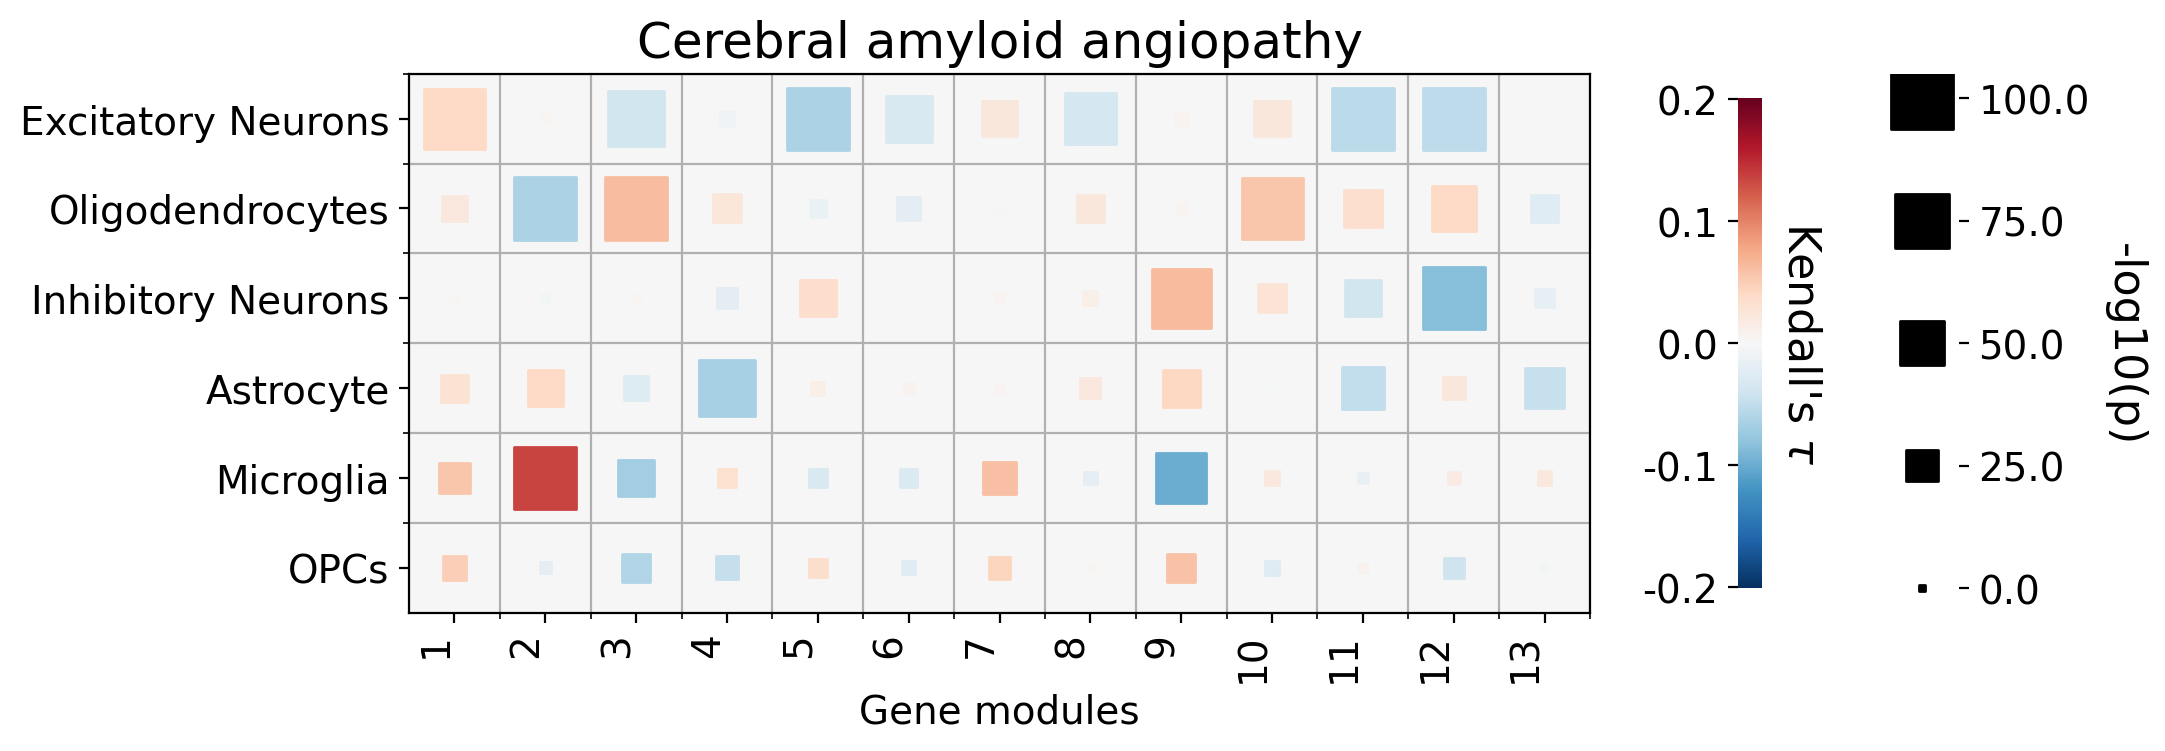

Lewy body load


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


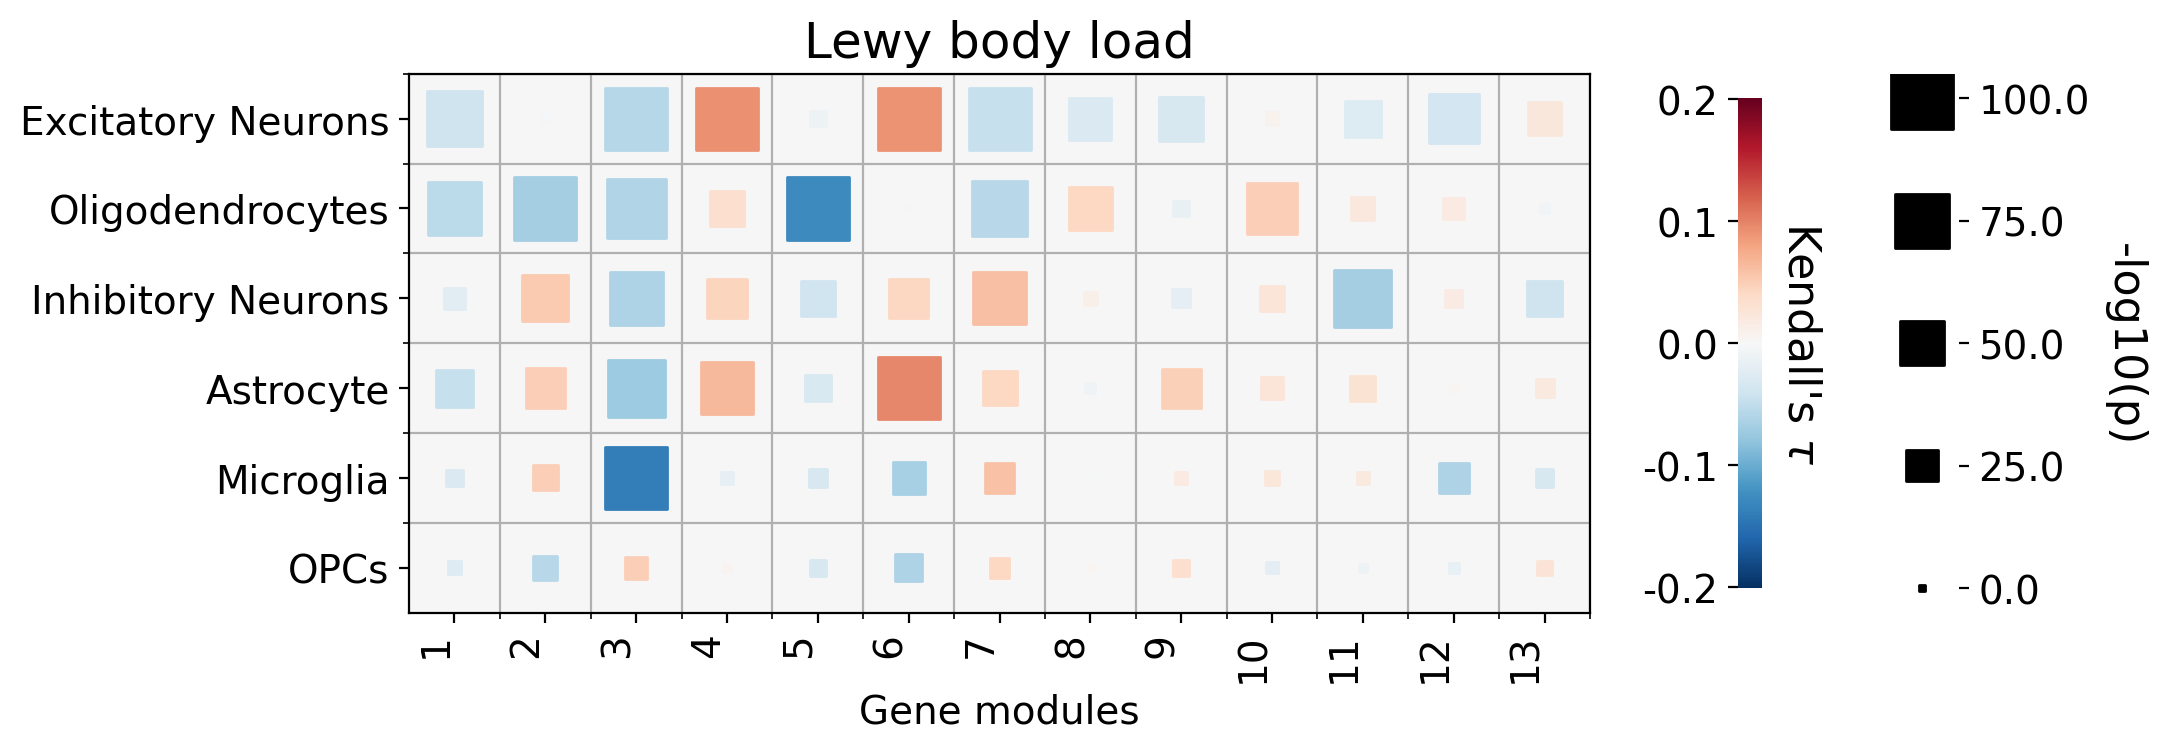

TDP-43 stage
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


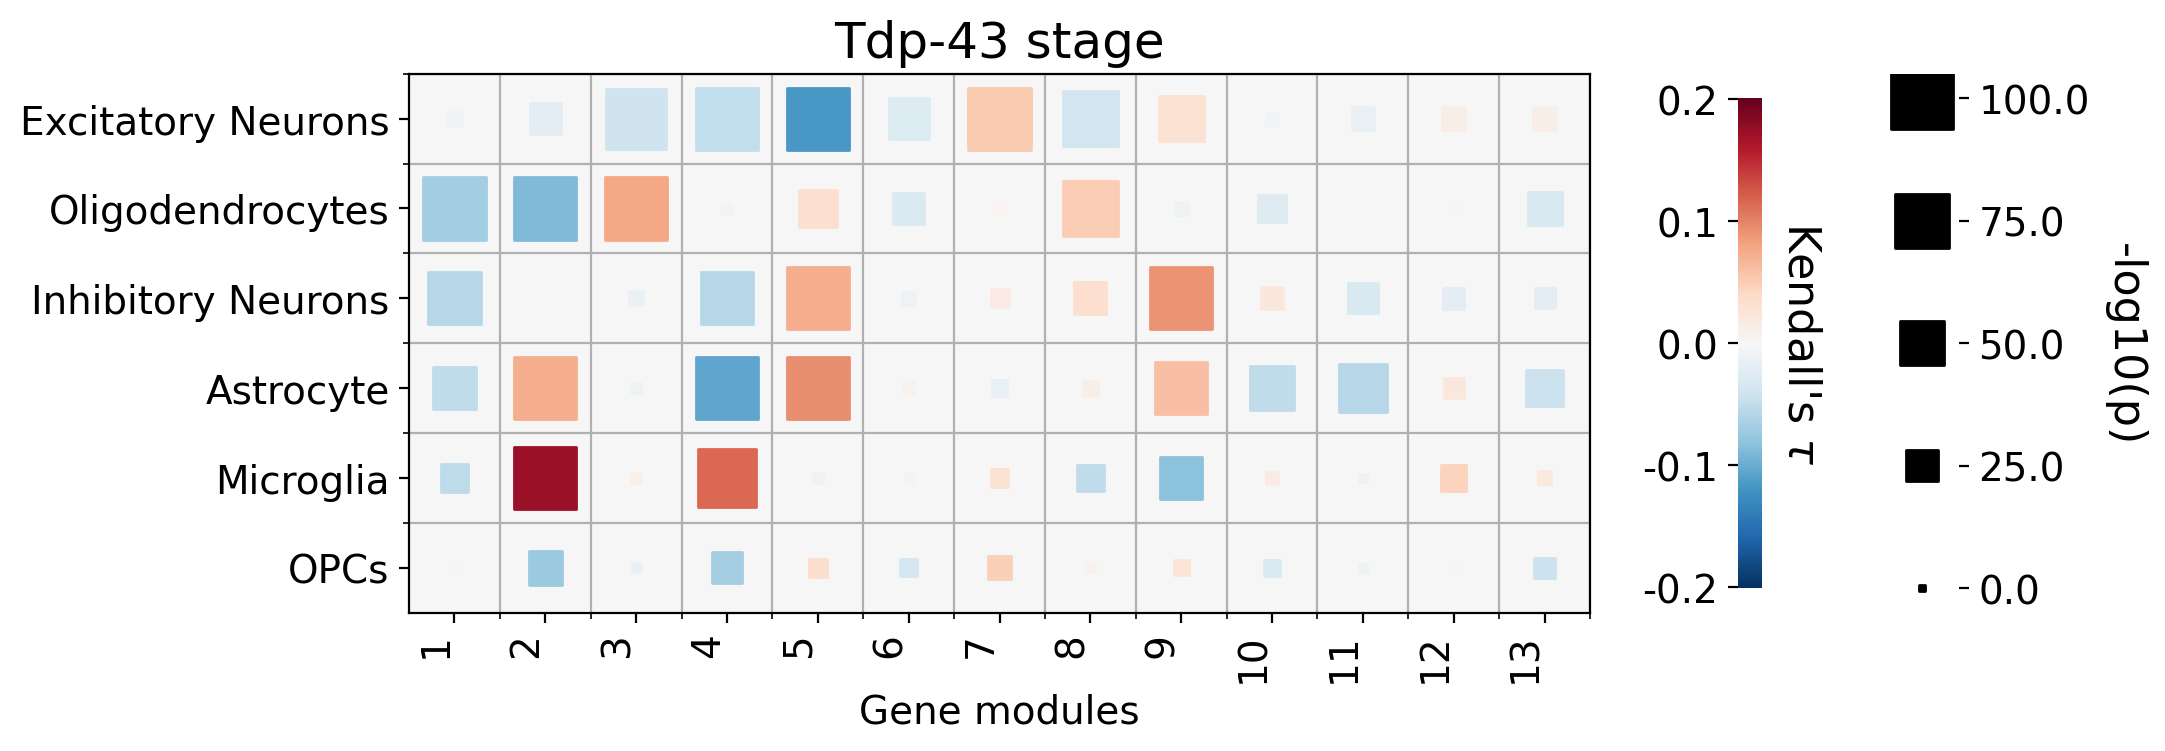

Pathologic diagnosis of Lewy Body disease
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


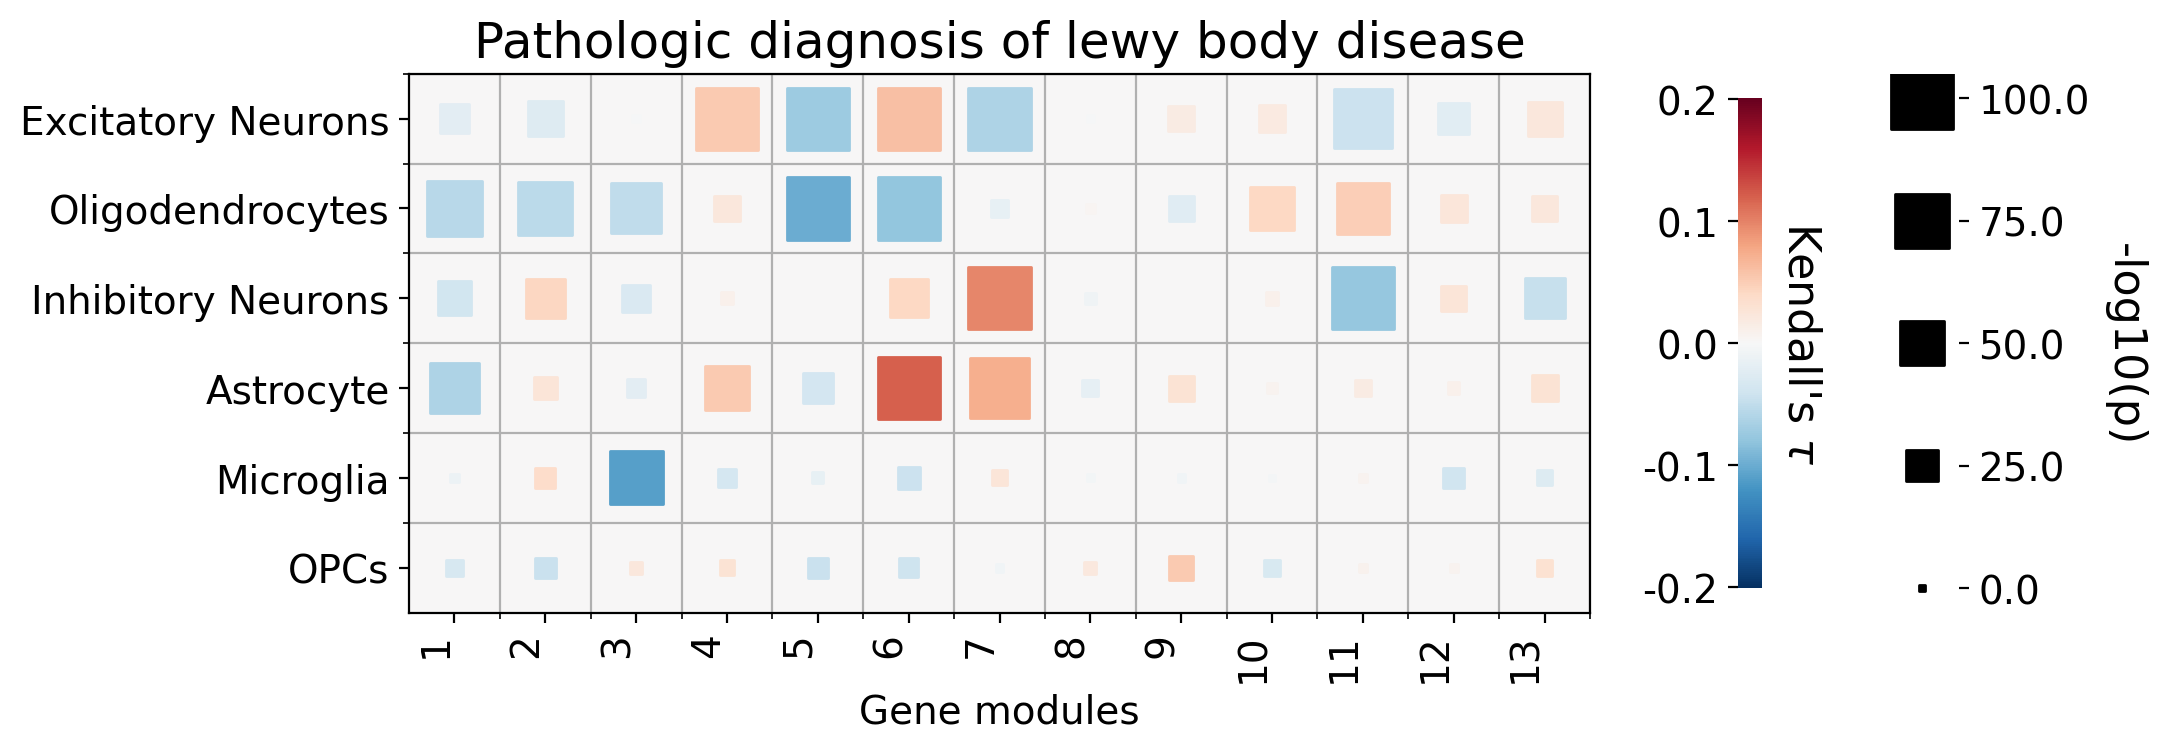

Parkinson's-like symptoms


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


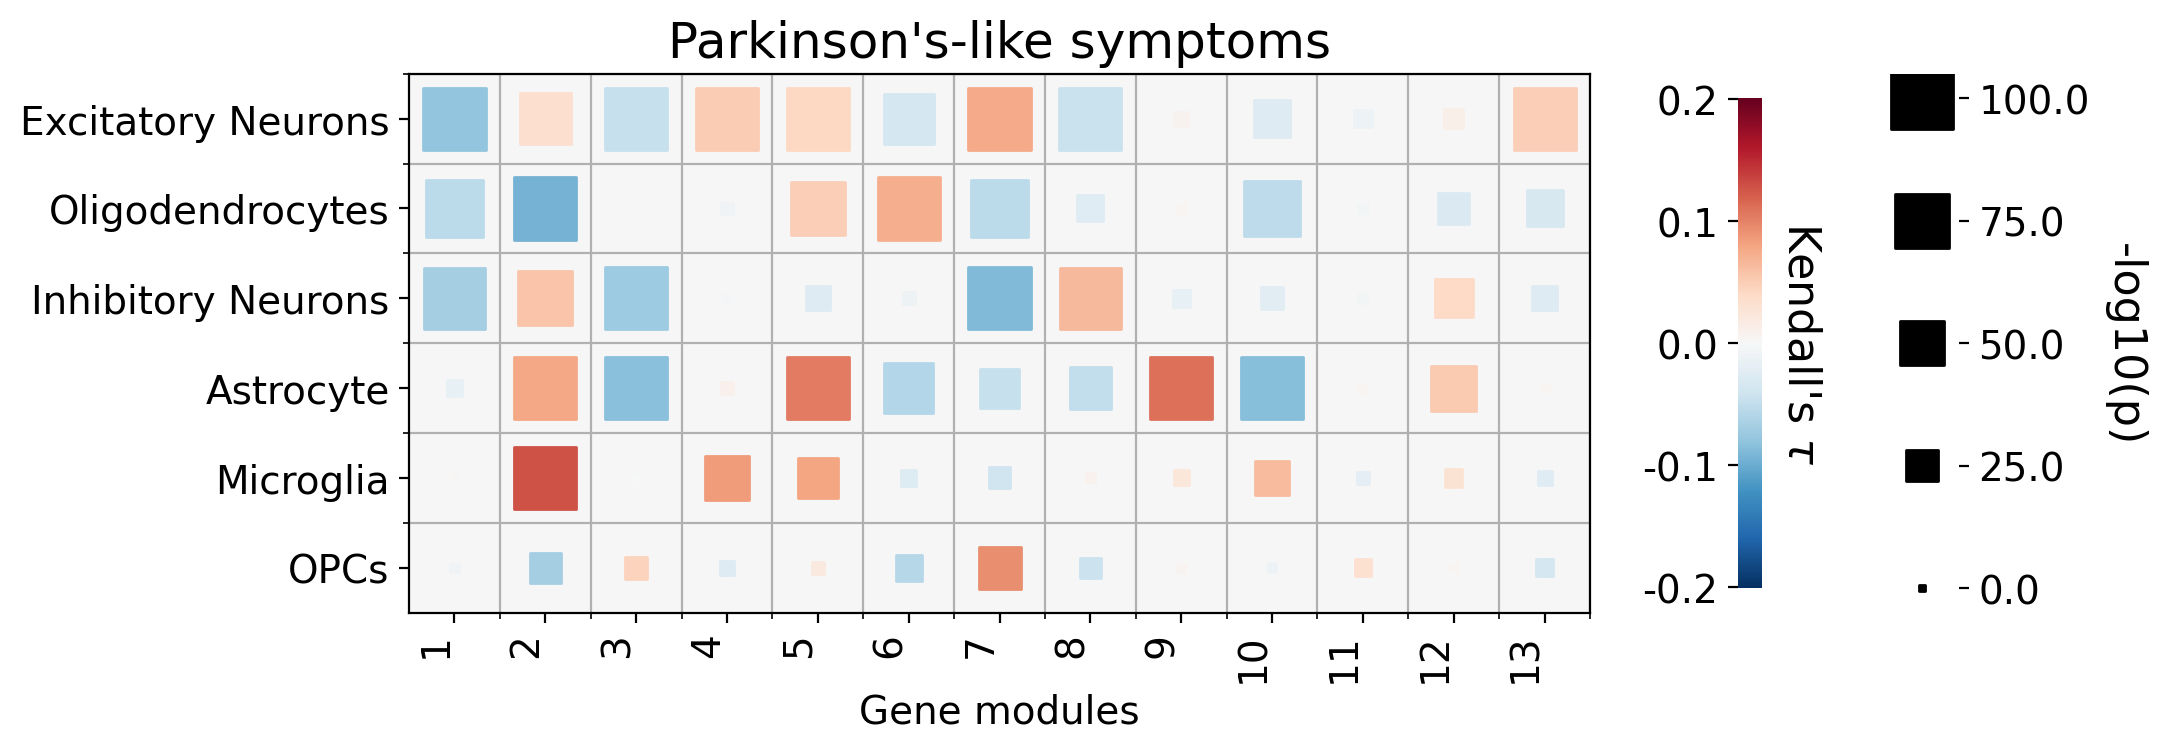

CERAD score
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


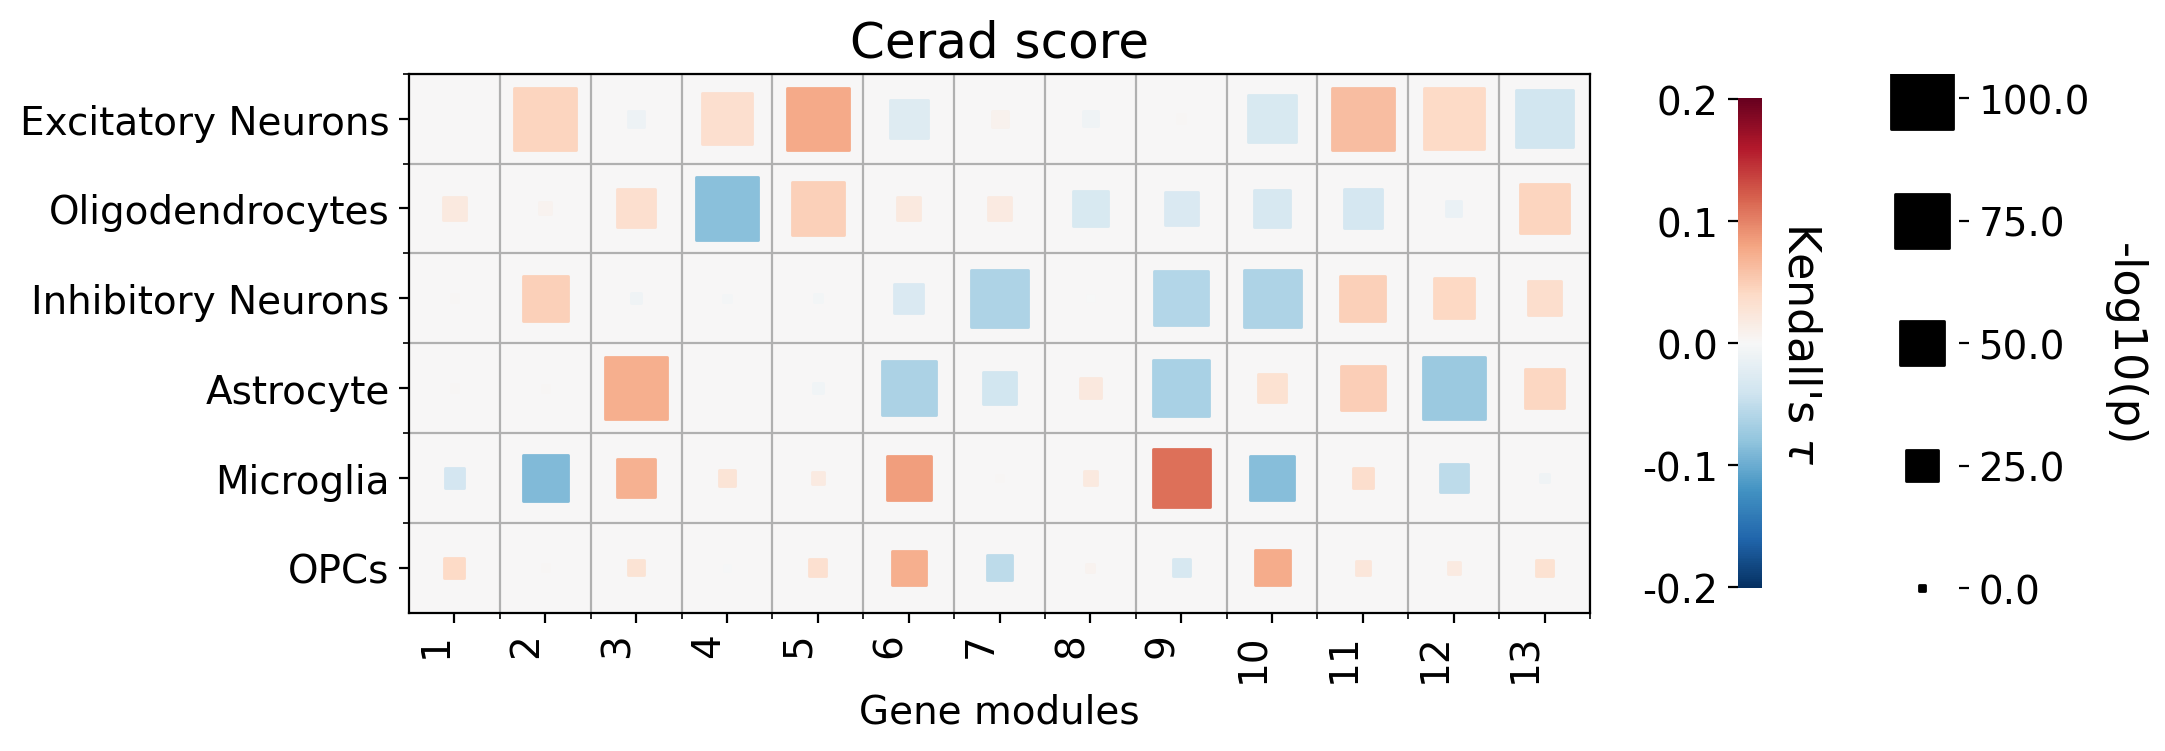

ε4 status
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


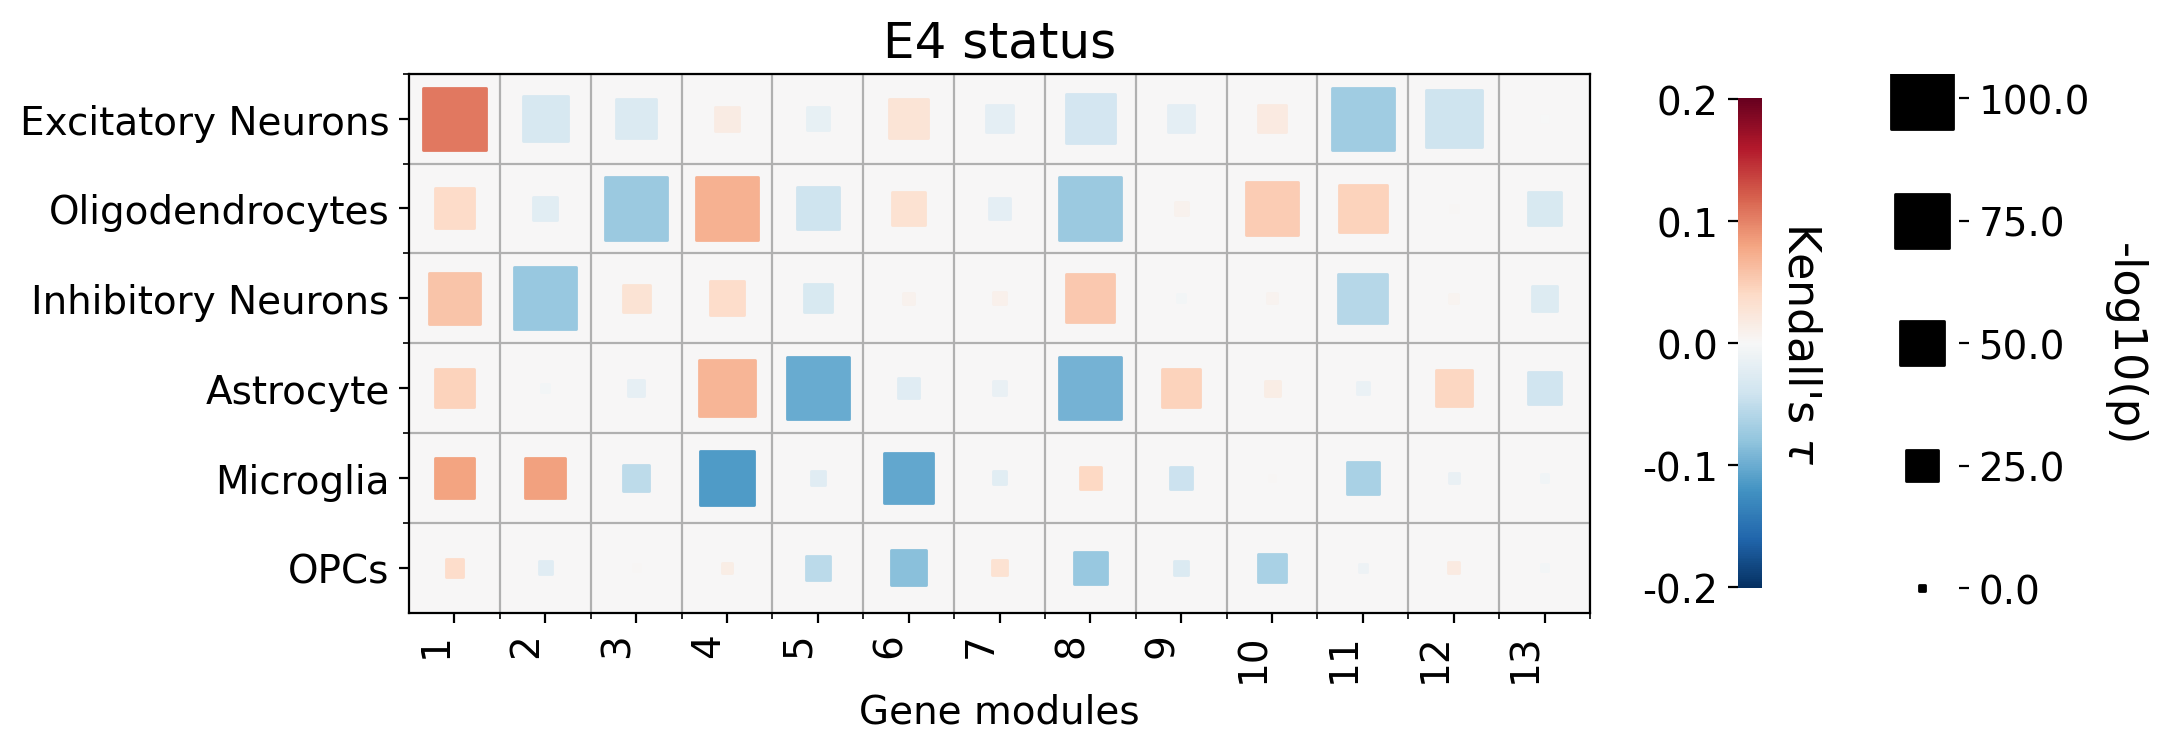

Neurofibrillary tangle scores
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


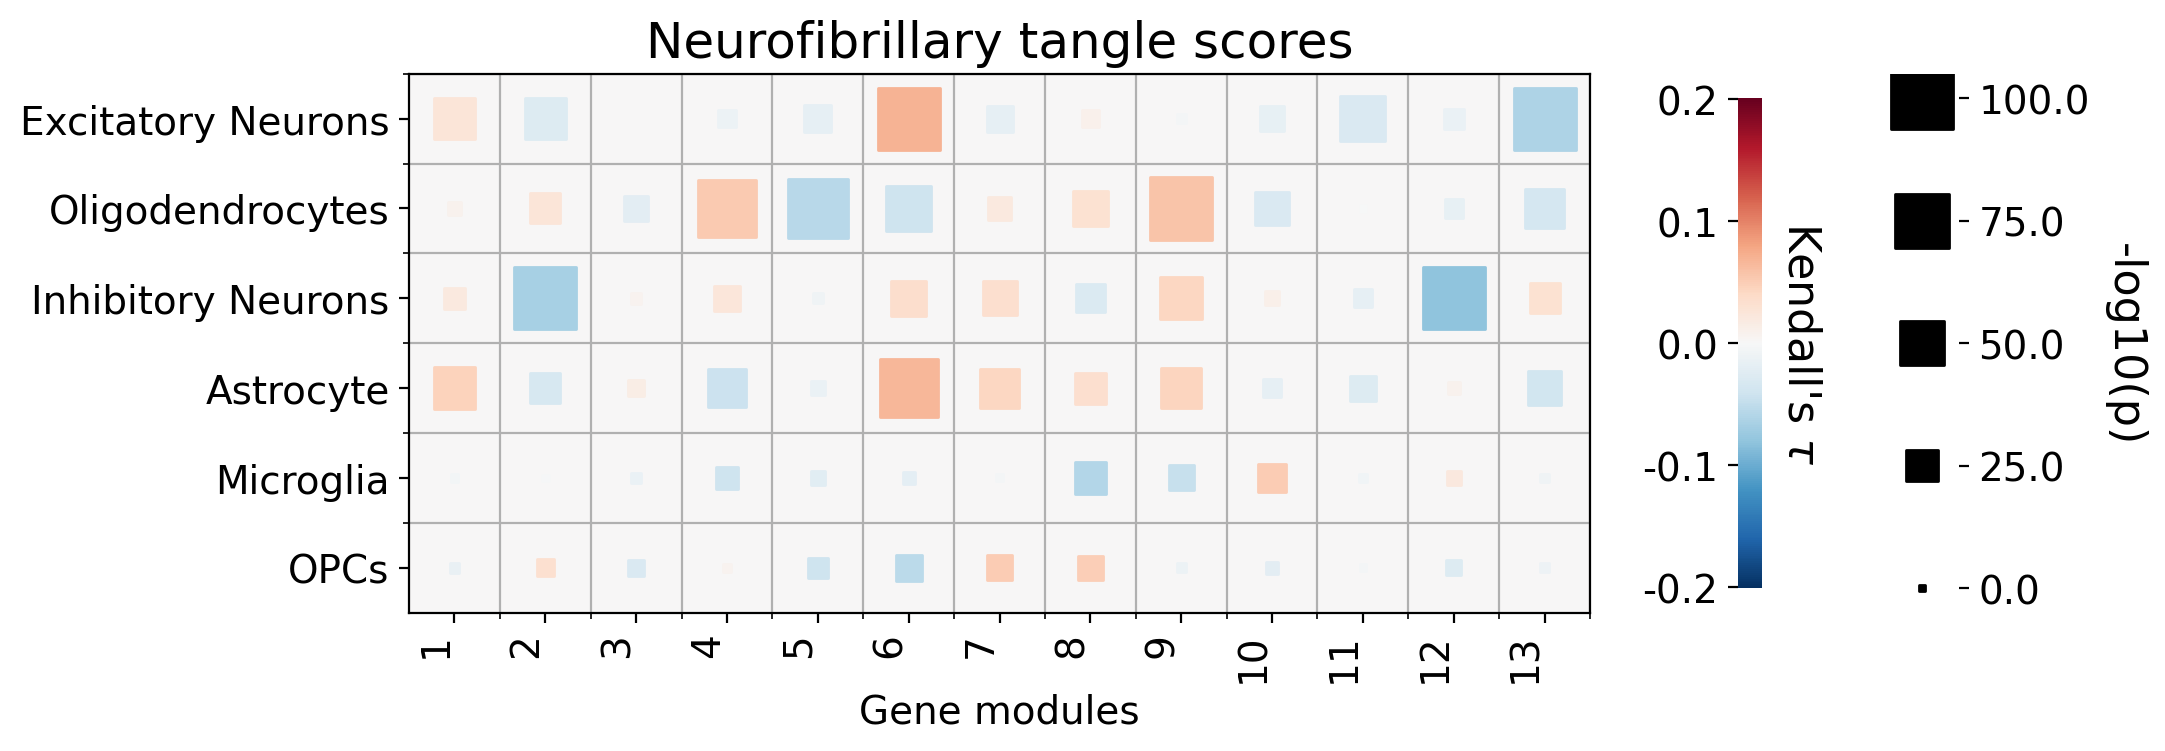

Neurofibrillary tangle burden
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


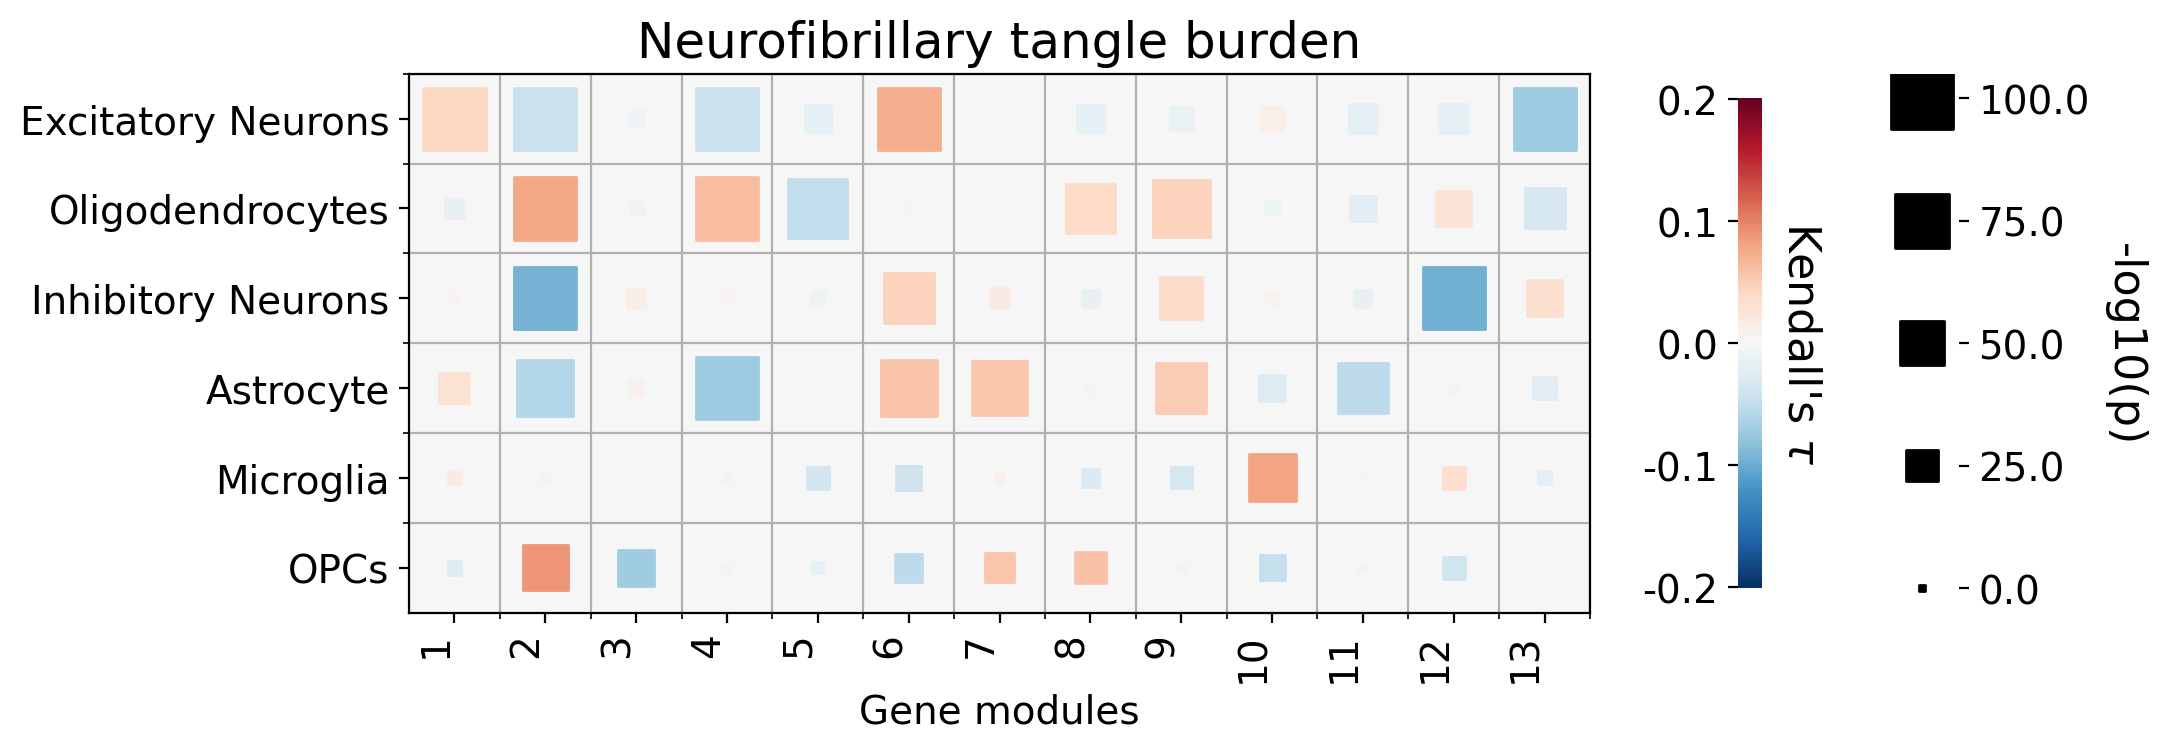

Tau Tangle Density
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


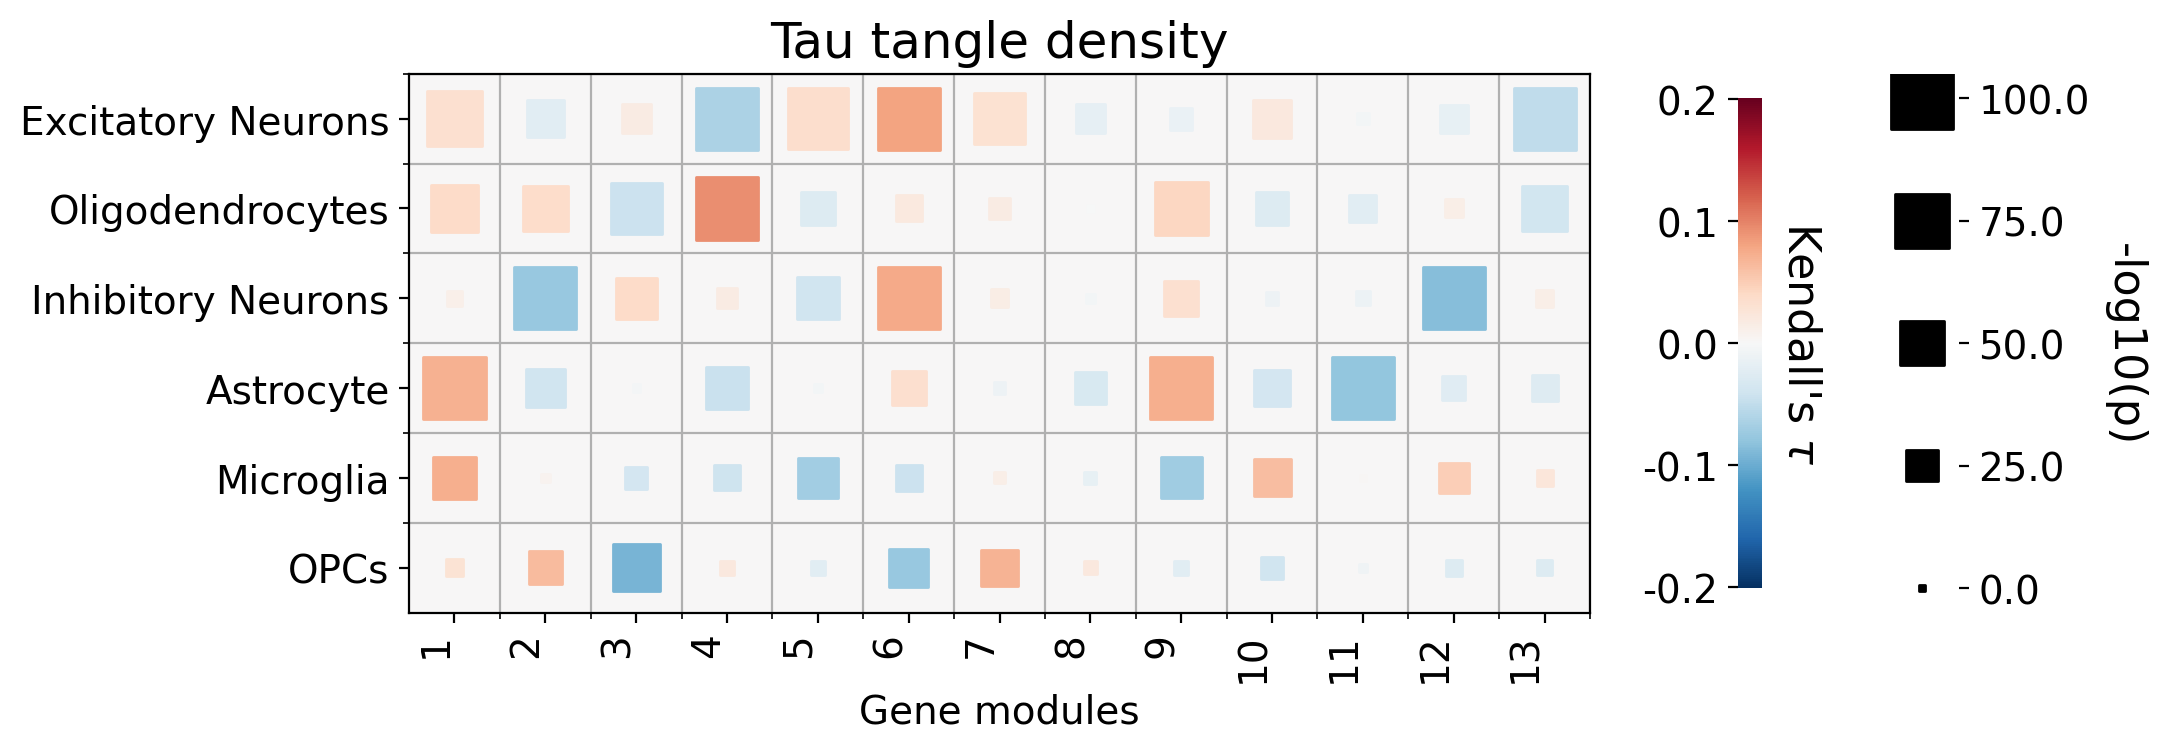

Amyloid load
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


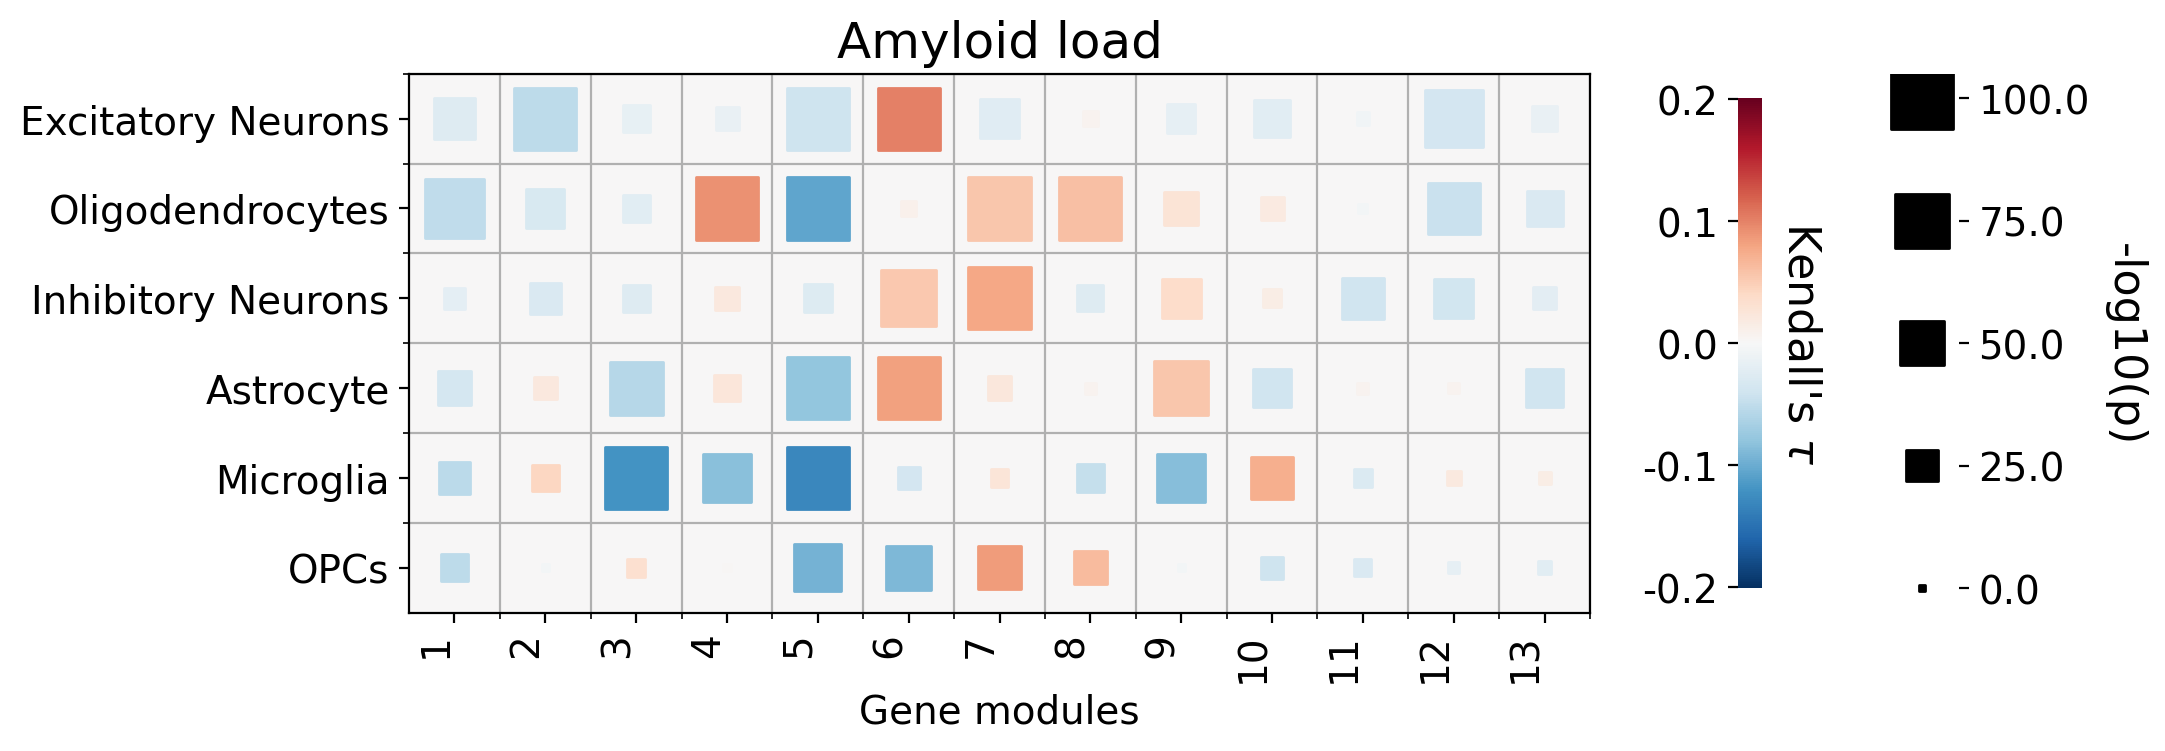

Presence of neurite plaques


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


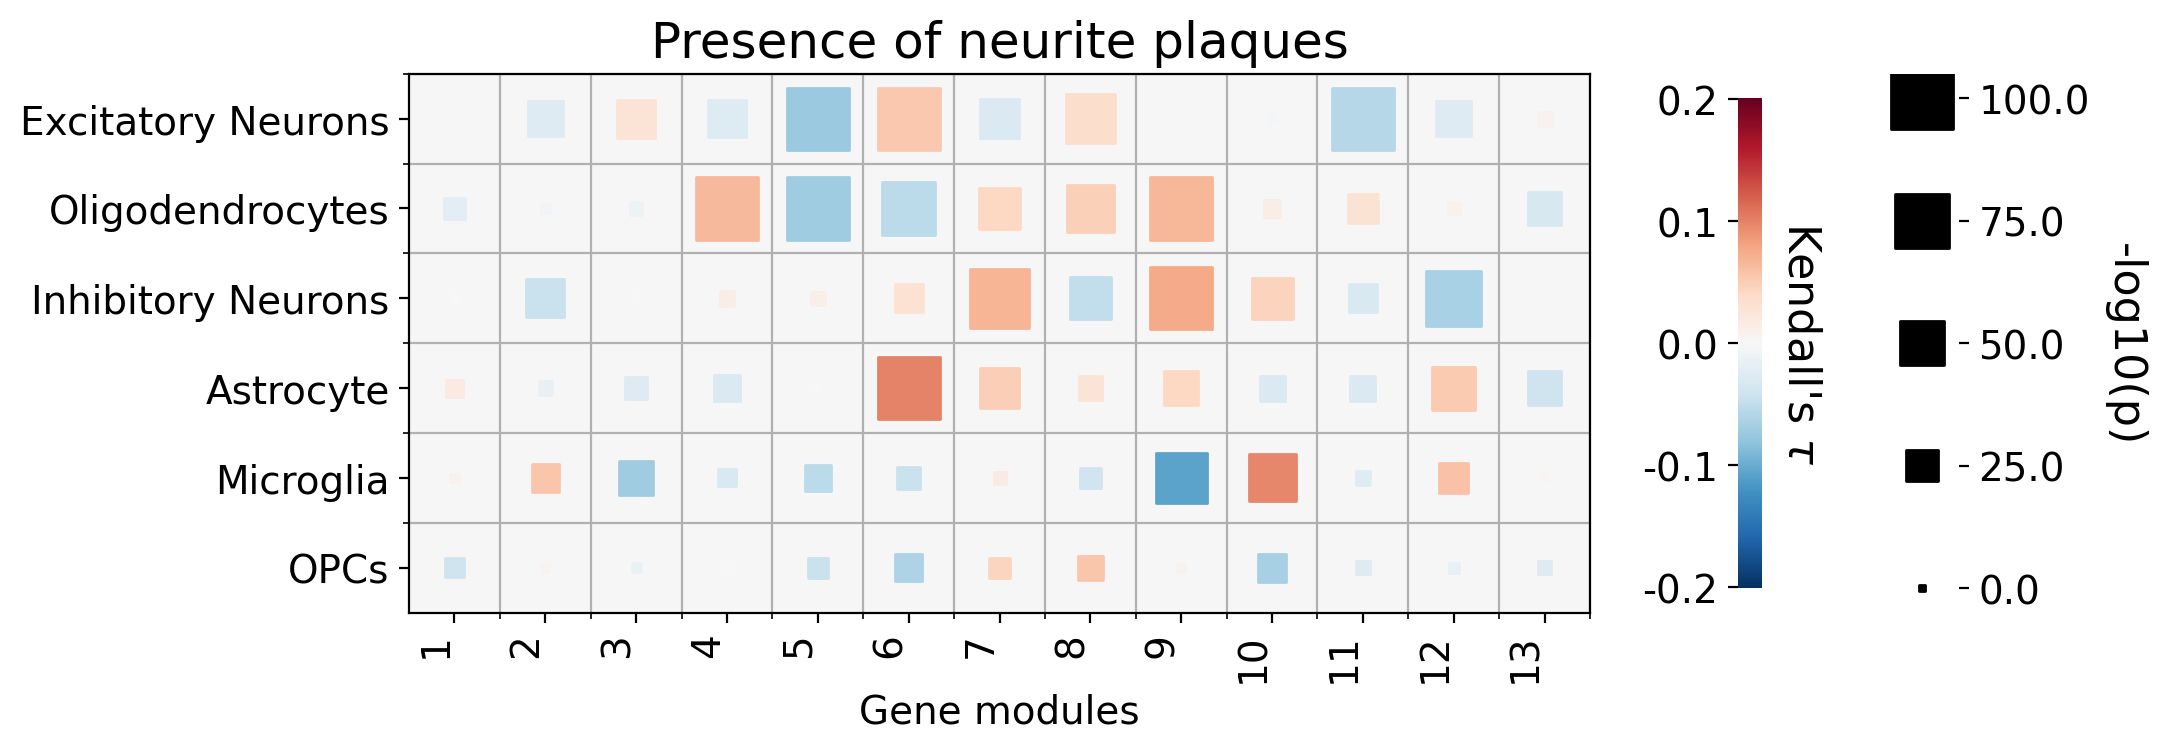

MMSE score
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


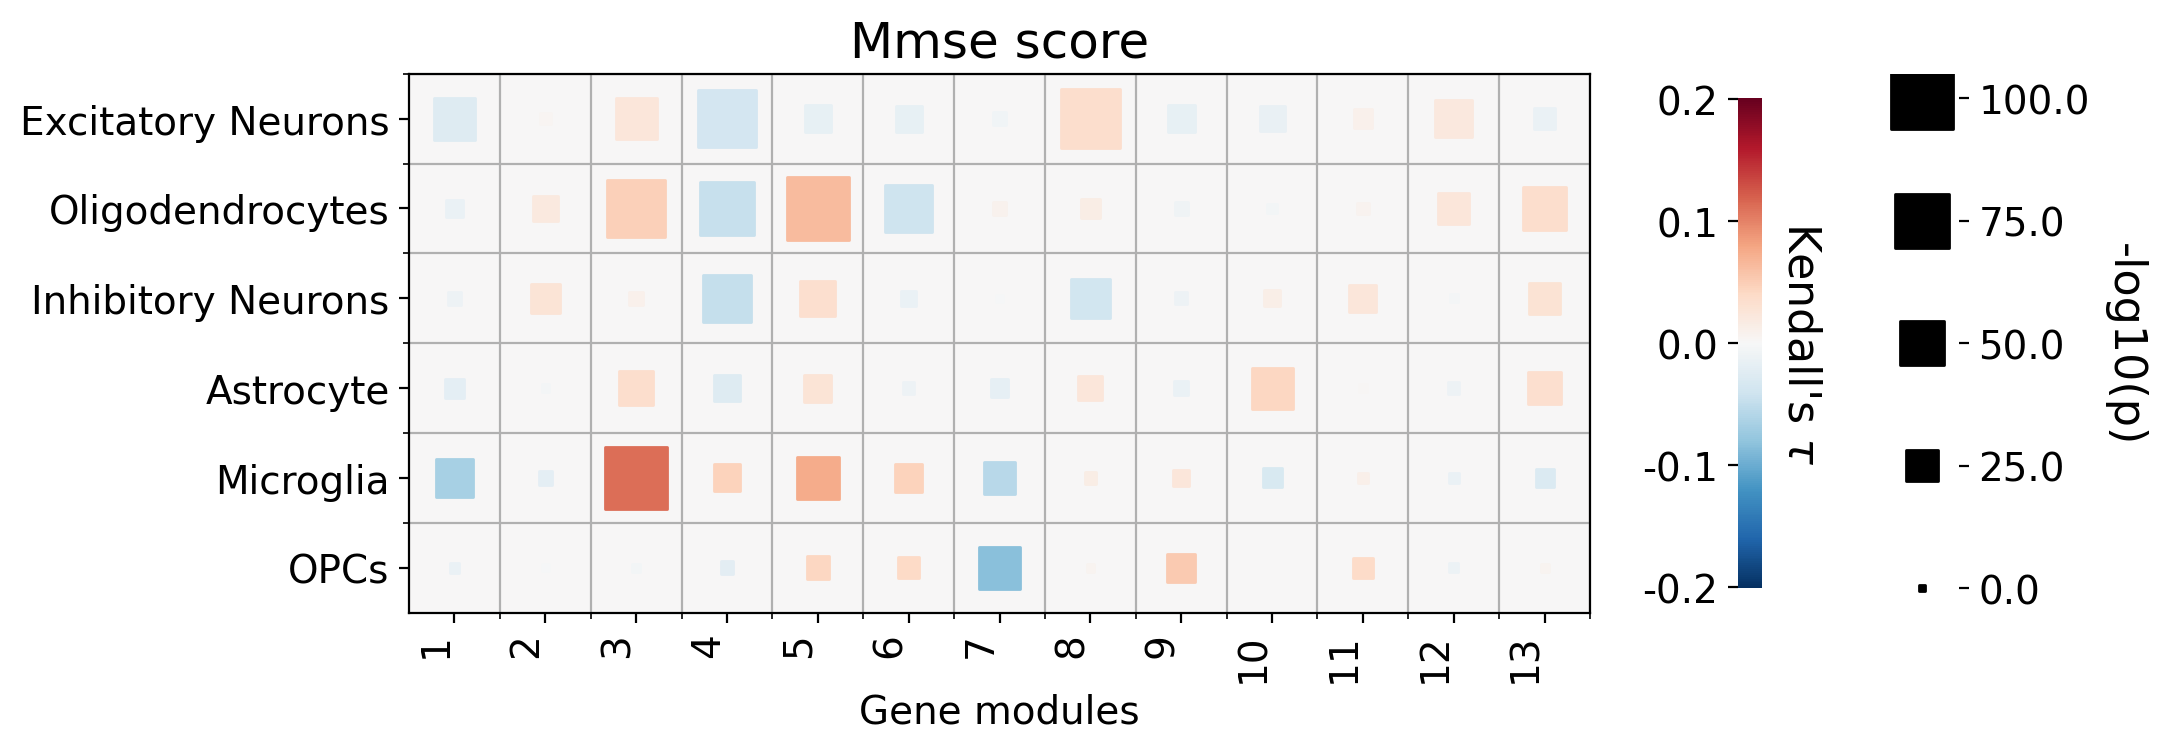

Global cognitive function
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


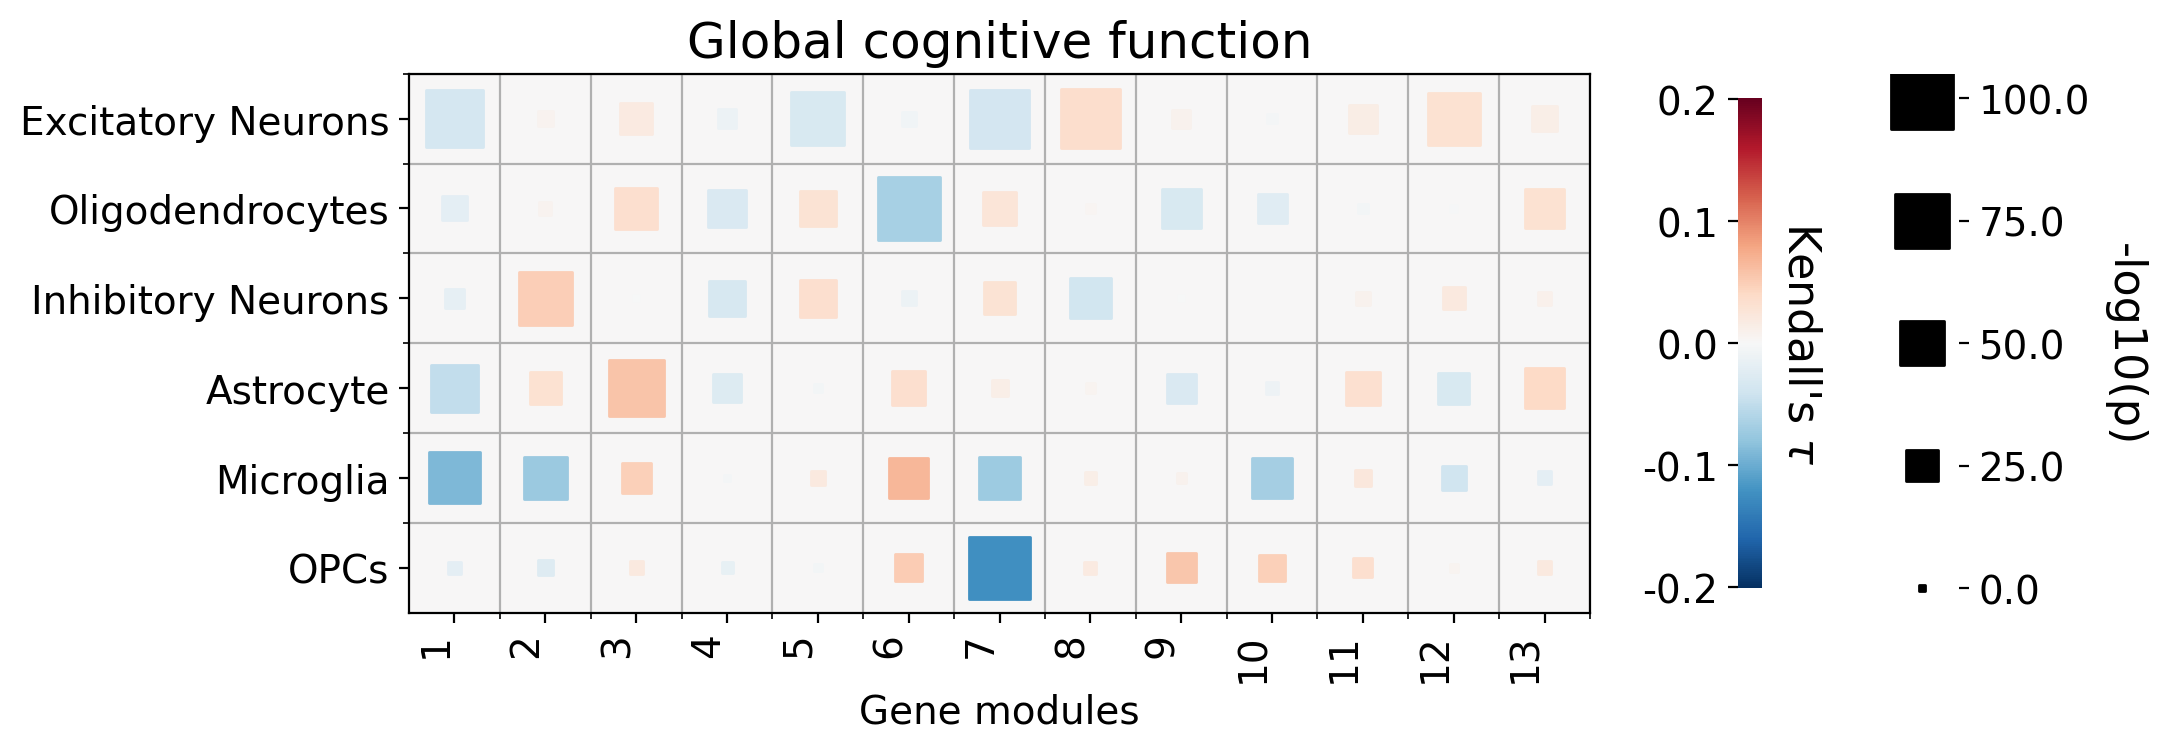

Global AD pathology burden


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


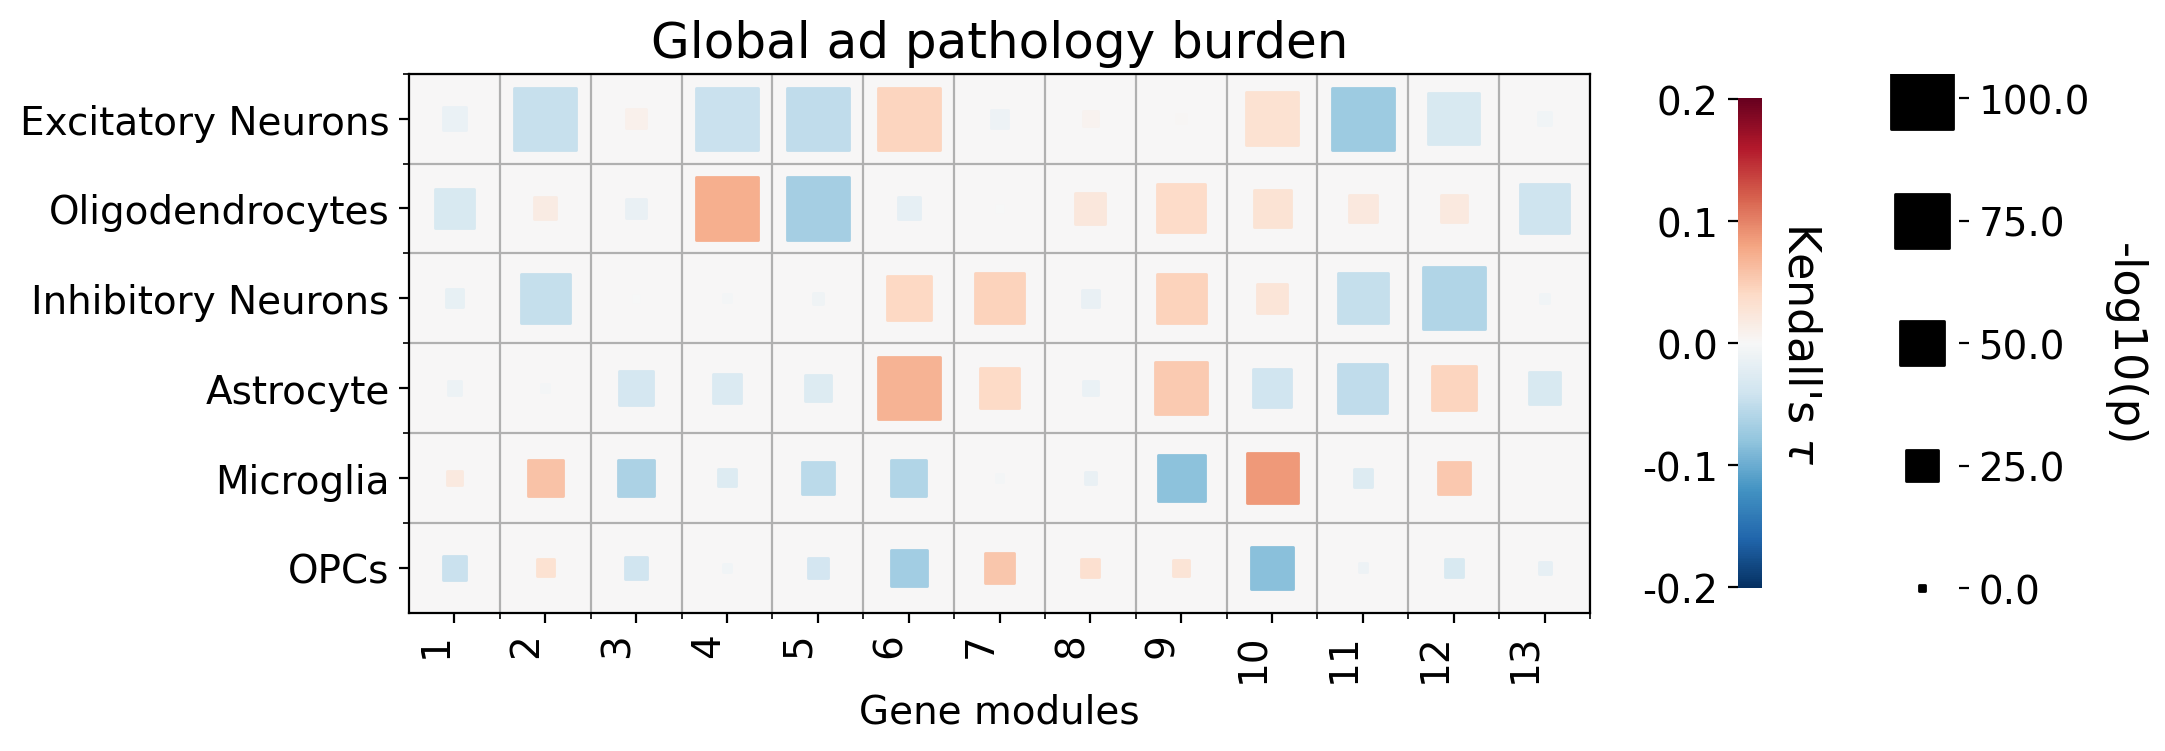

females
Social network size
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


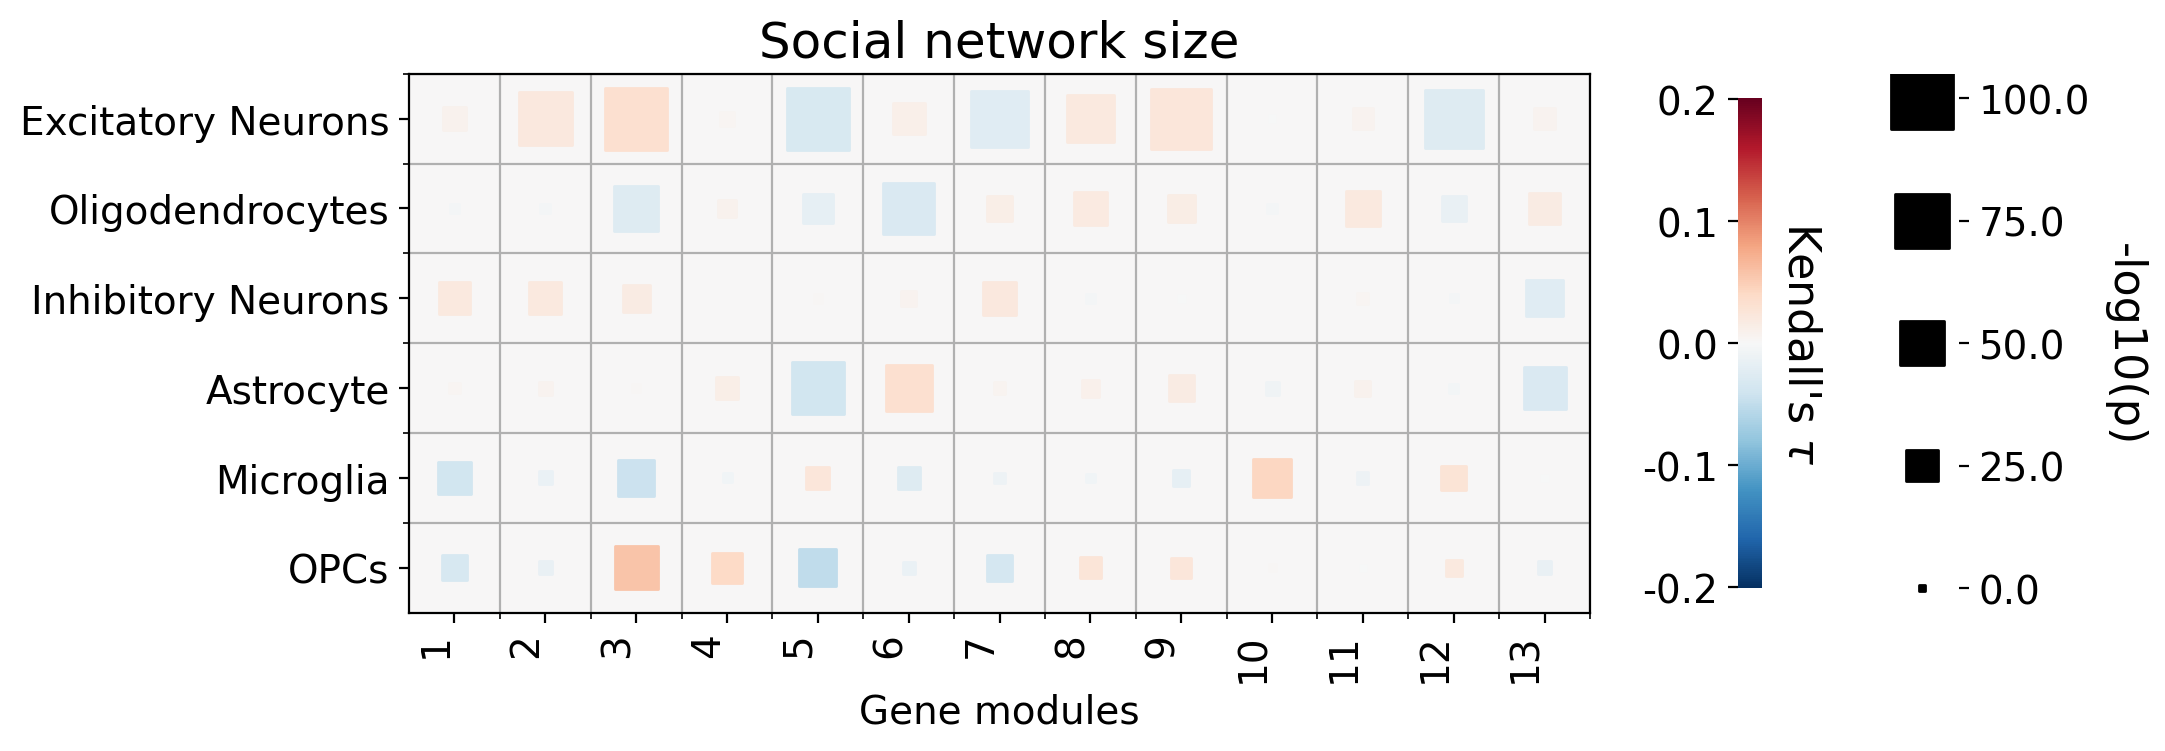

Physical activity
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


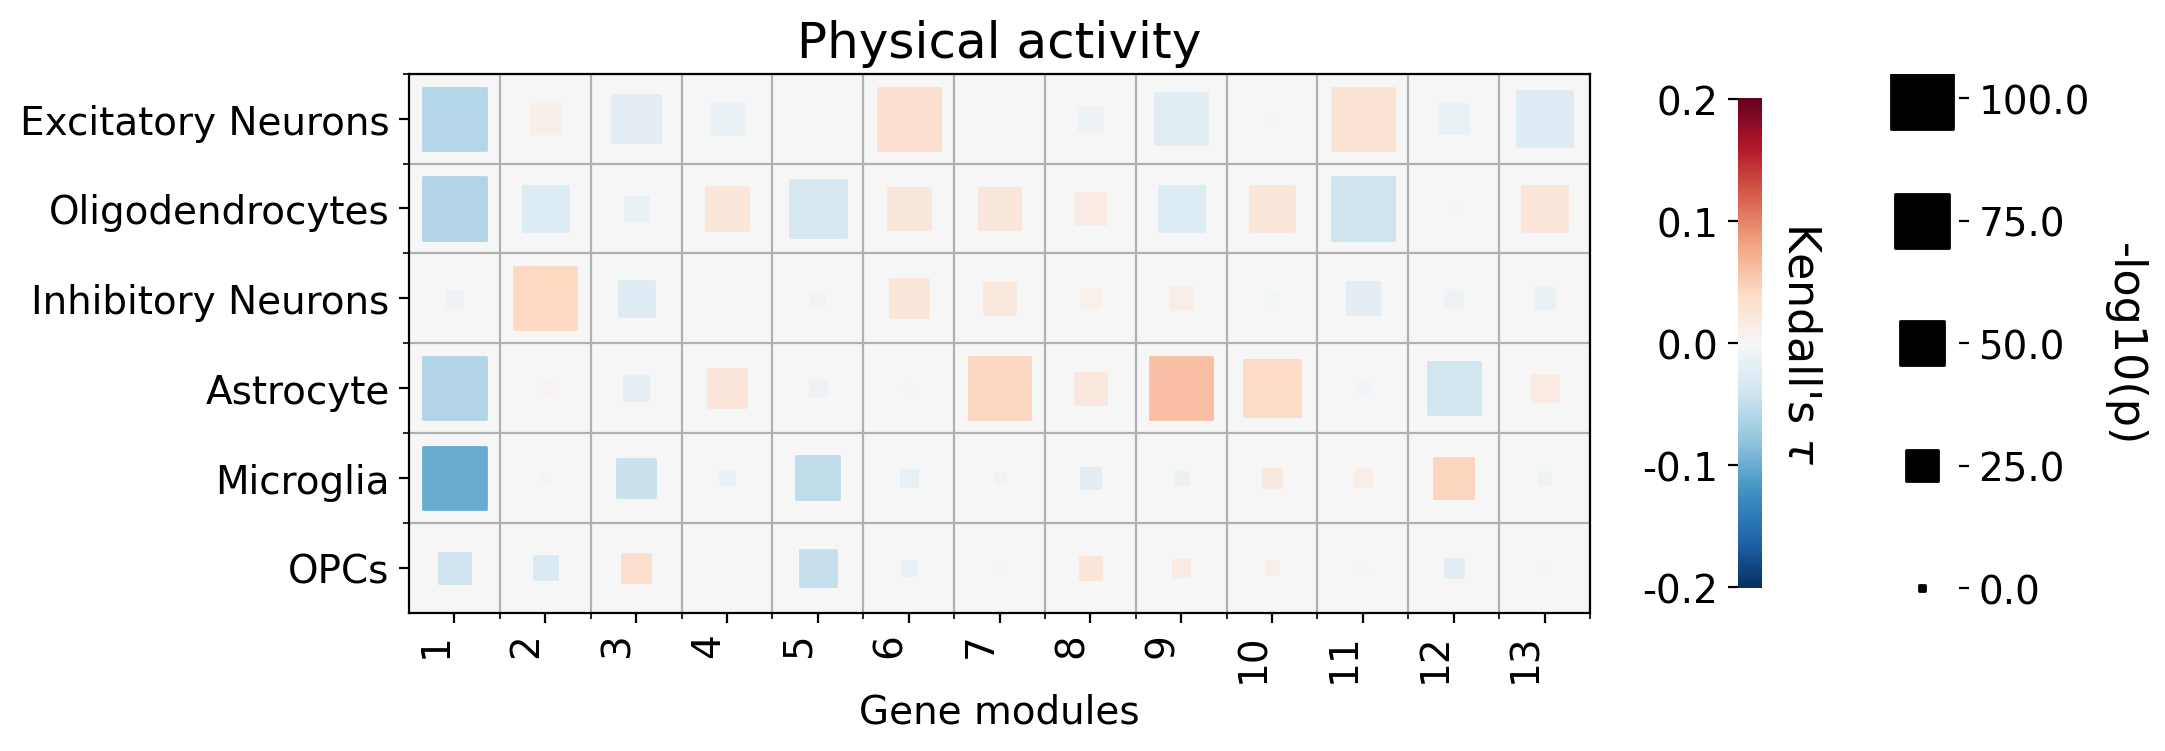

Parental education


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


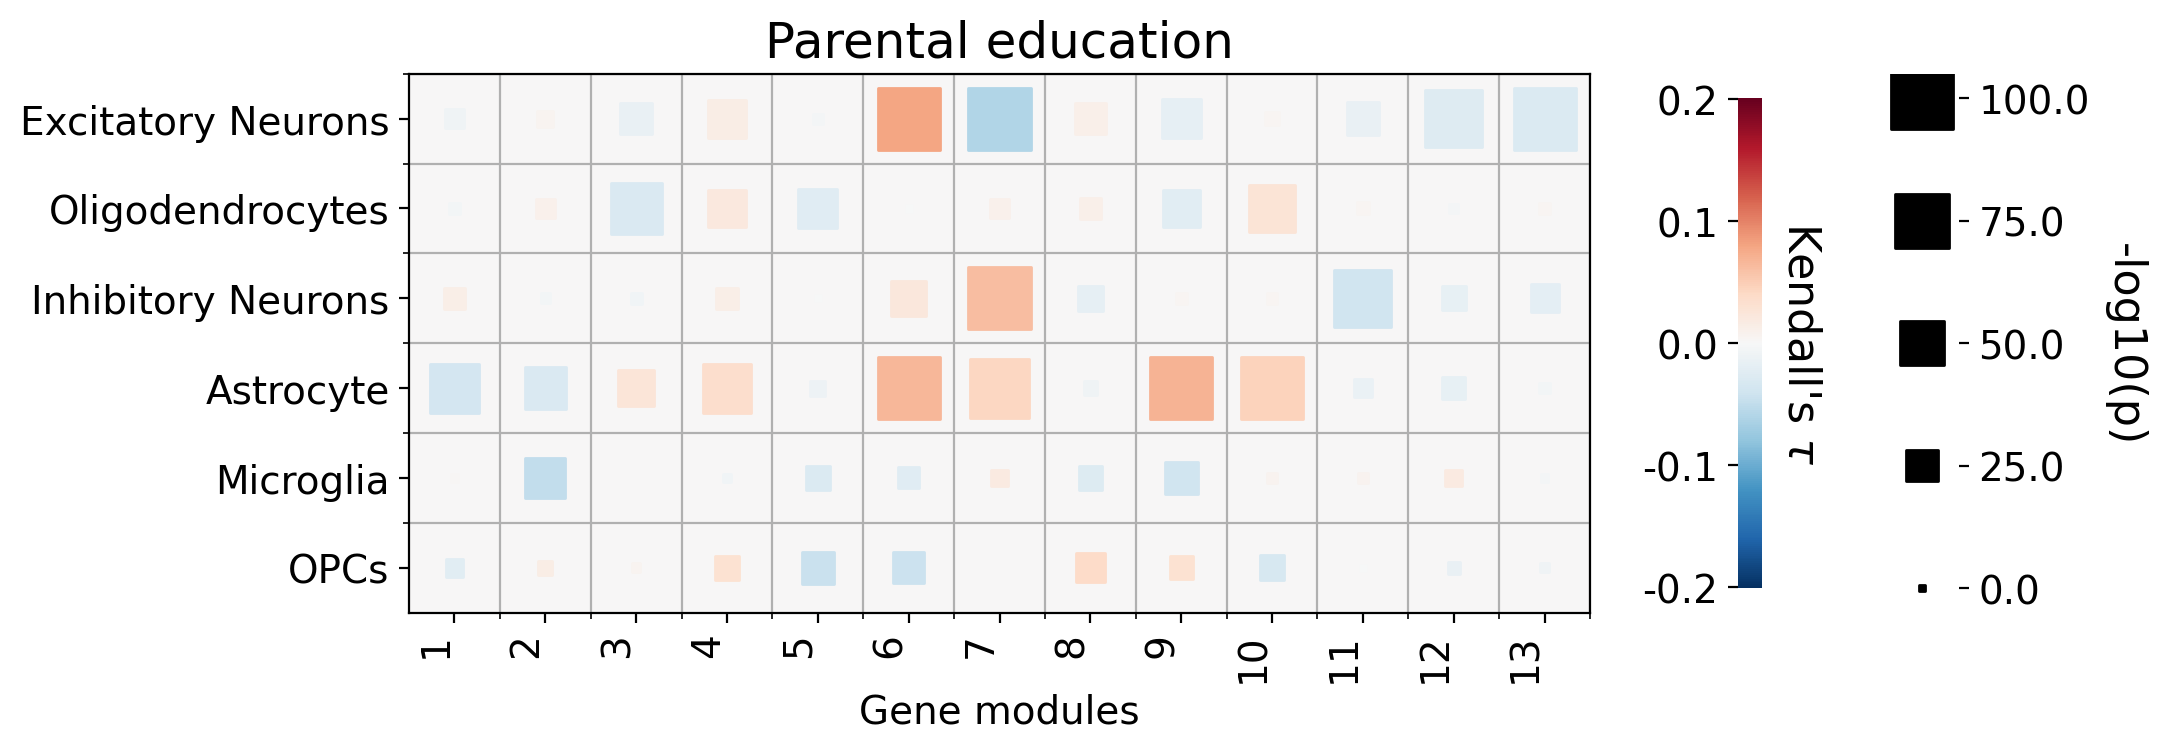

Neuroticism
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


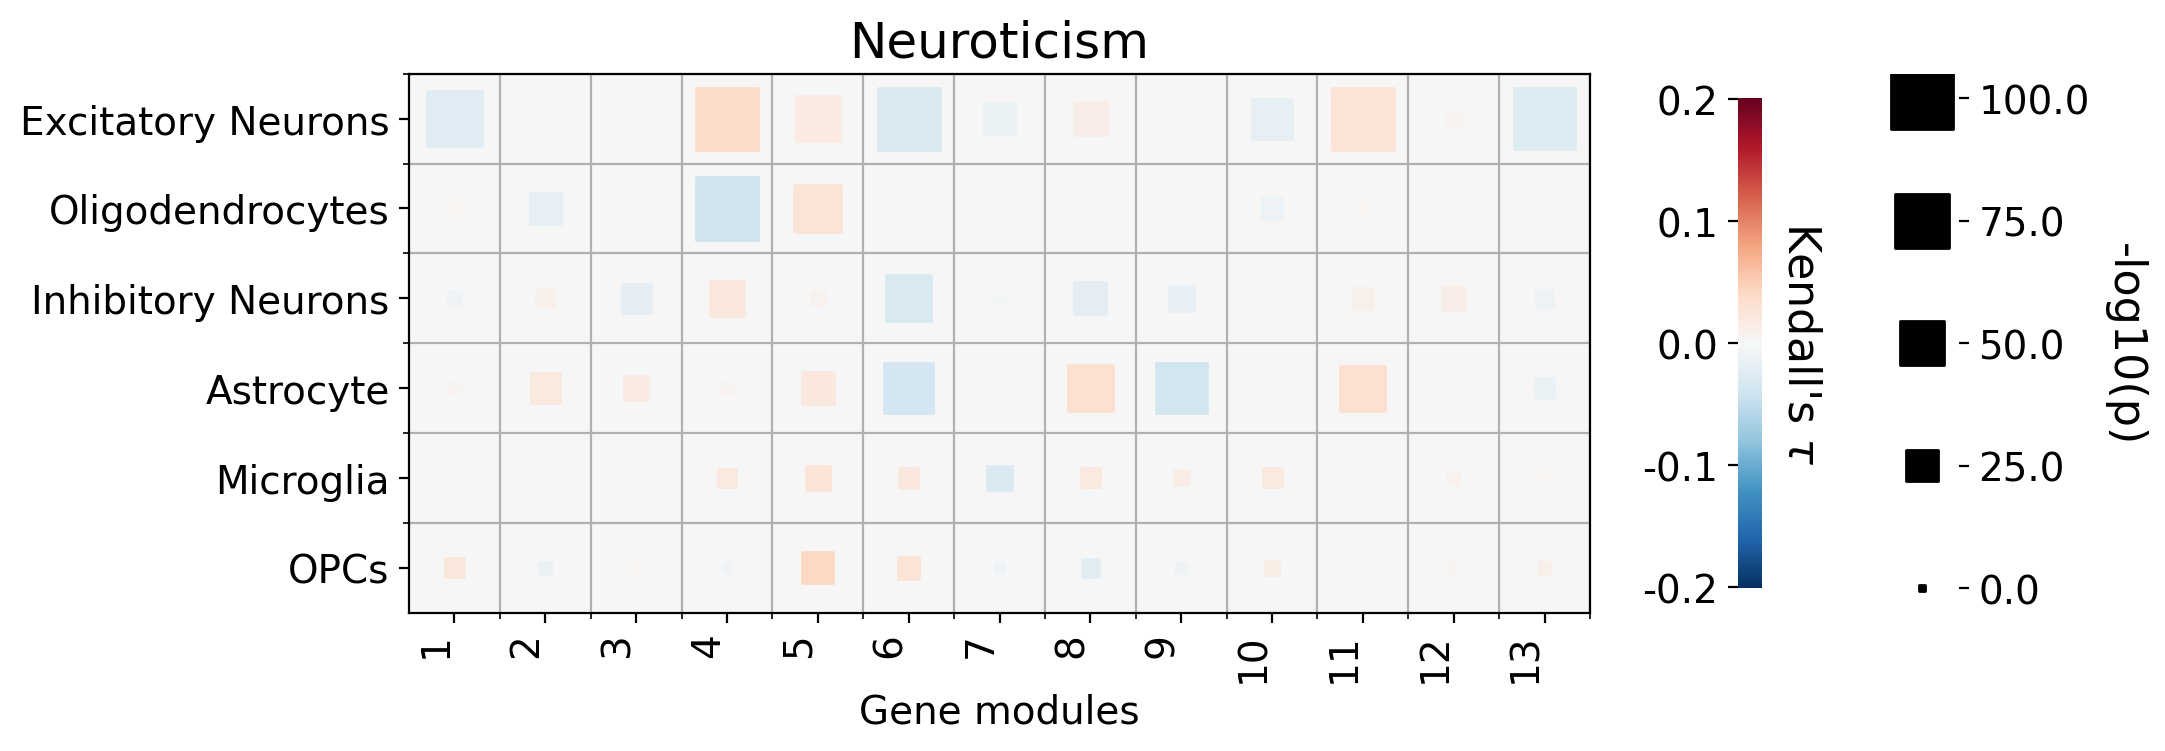

Education
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


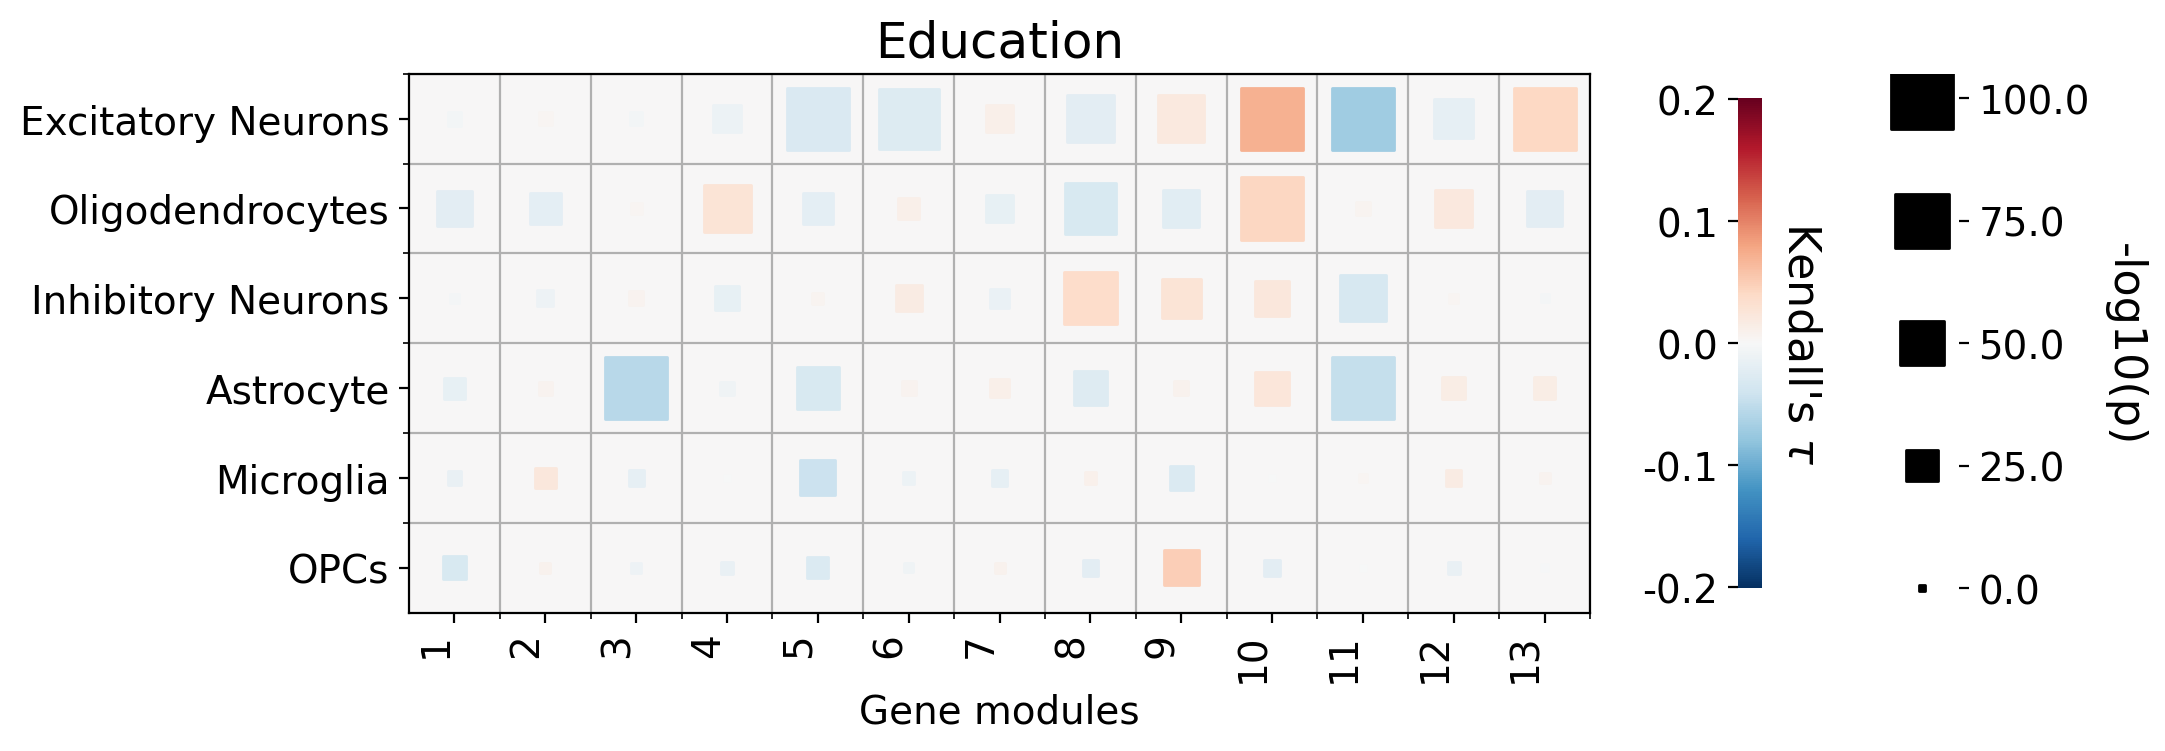

Lifetime daily alcohol intake
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


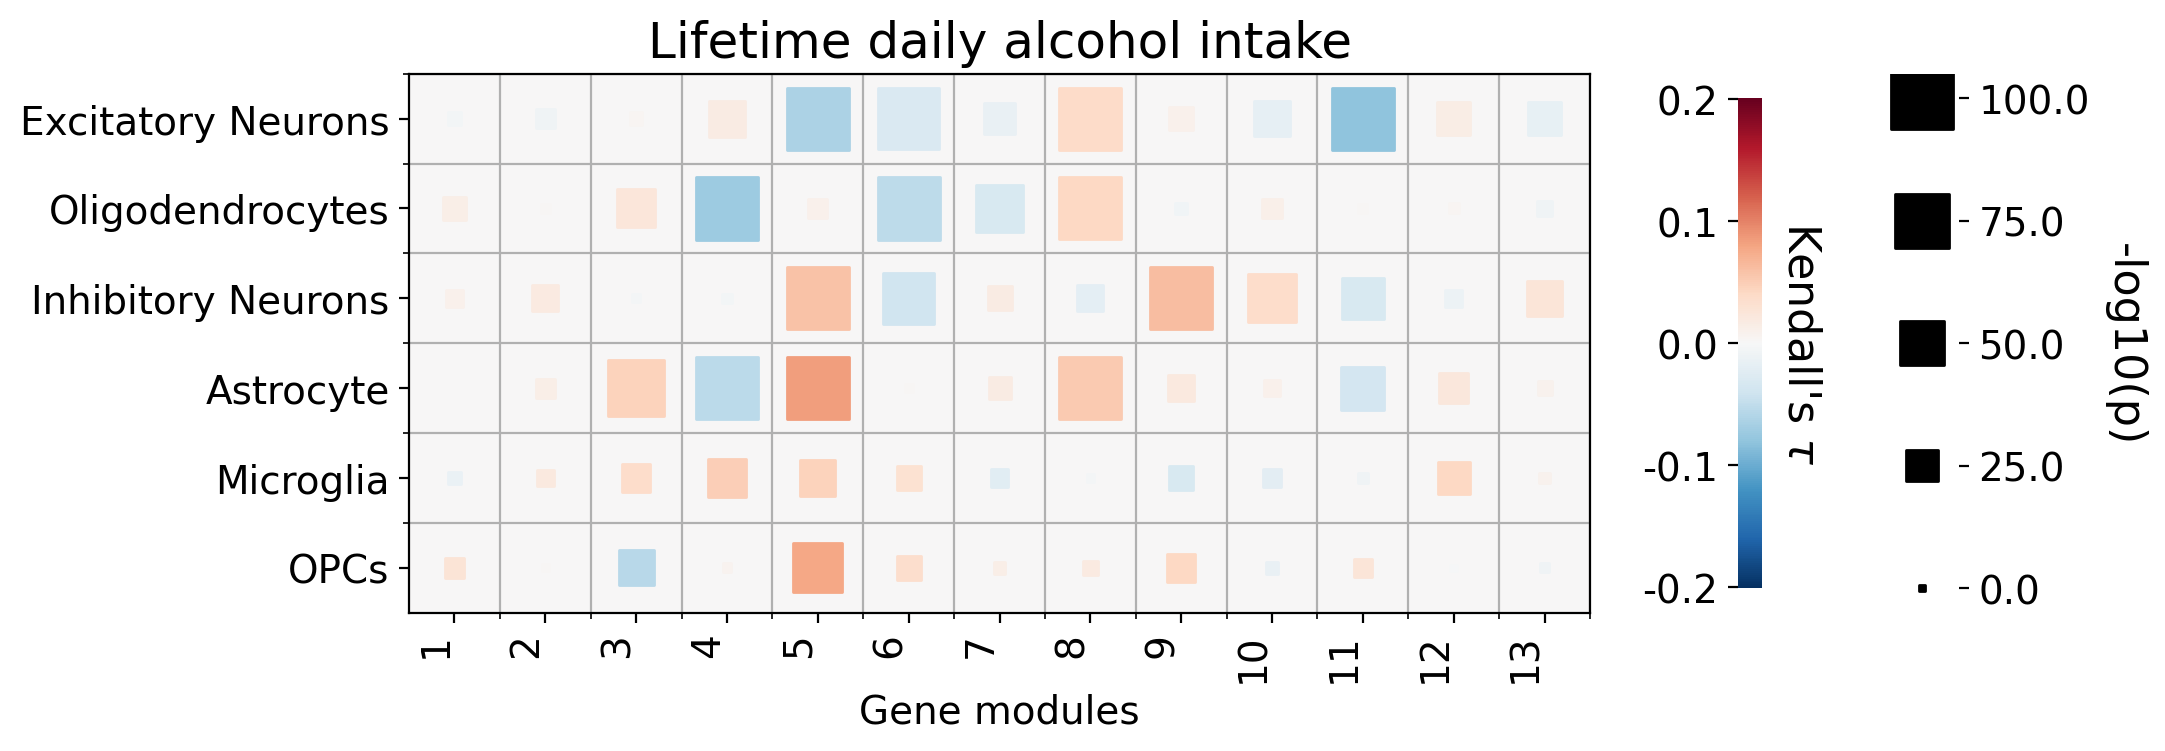

Baseline smoking status


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


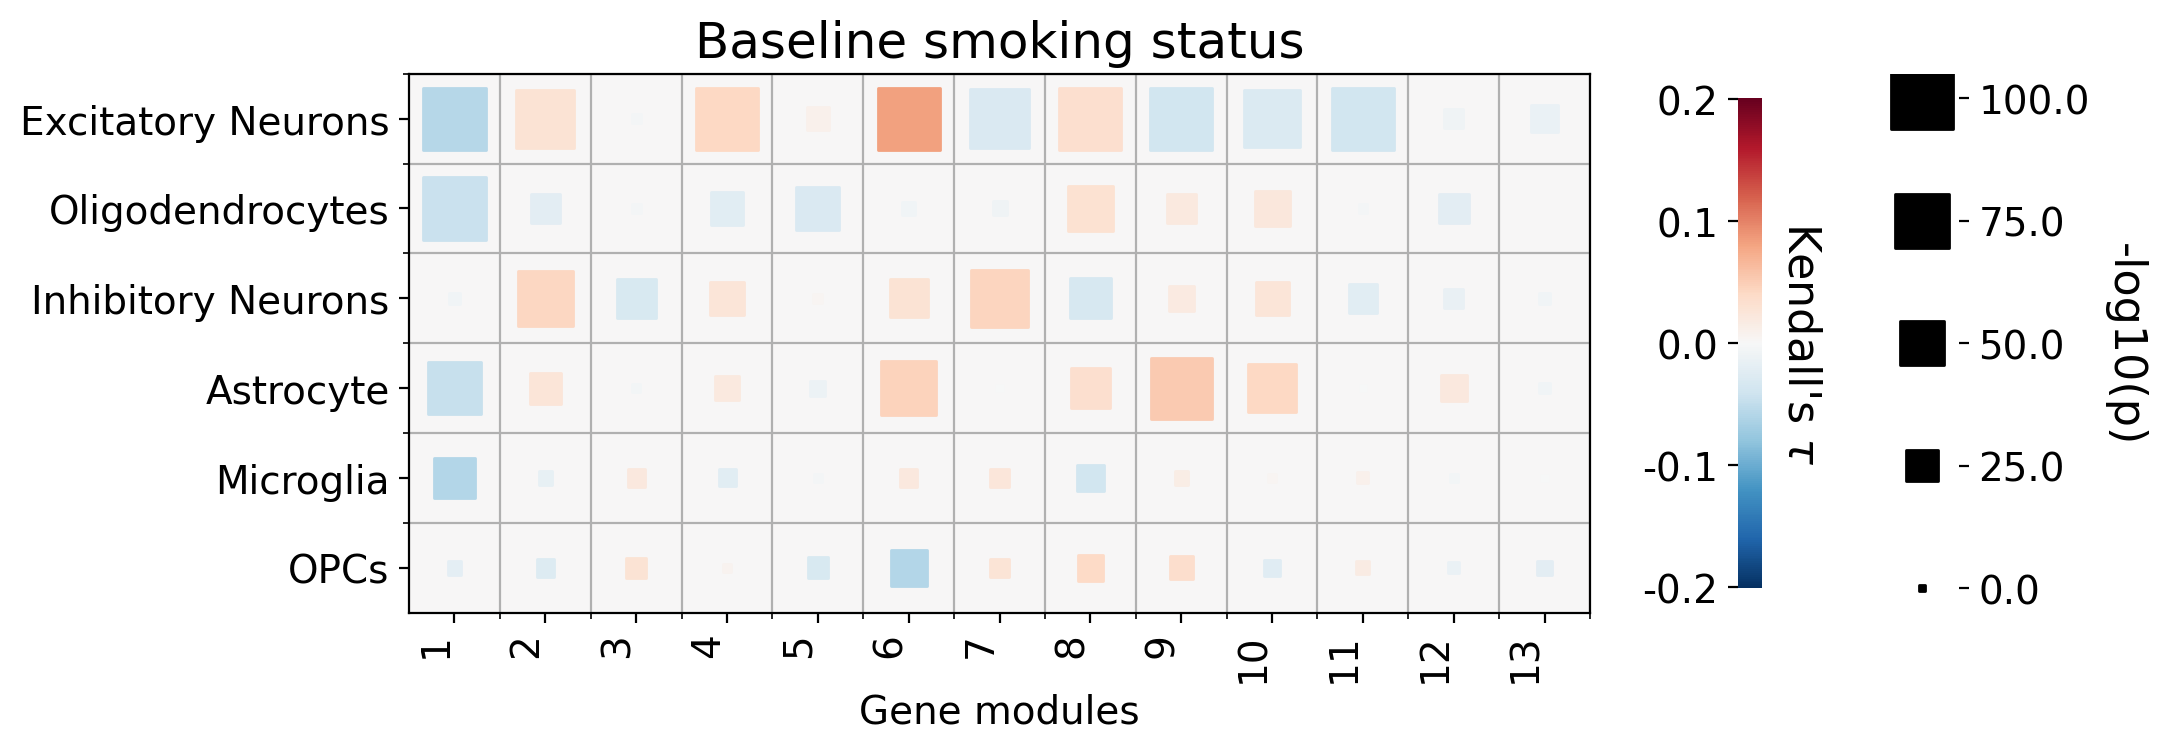

Age at death
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


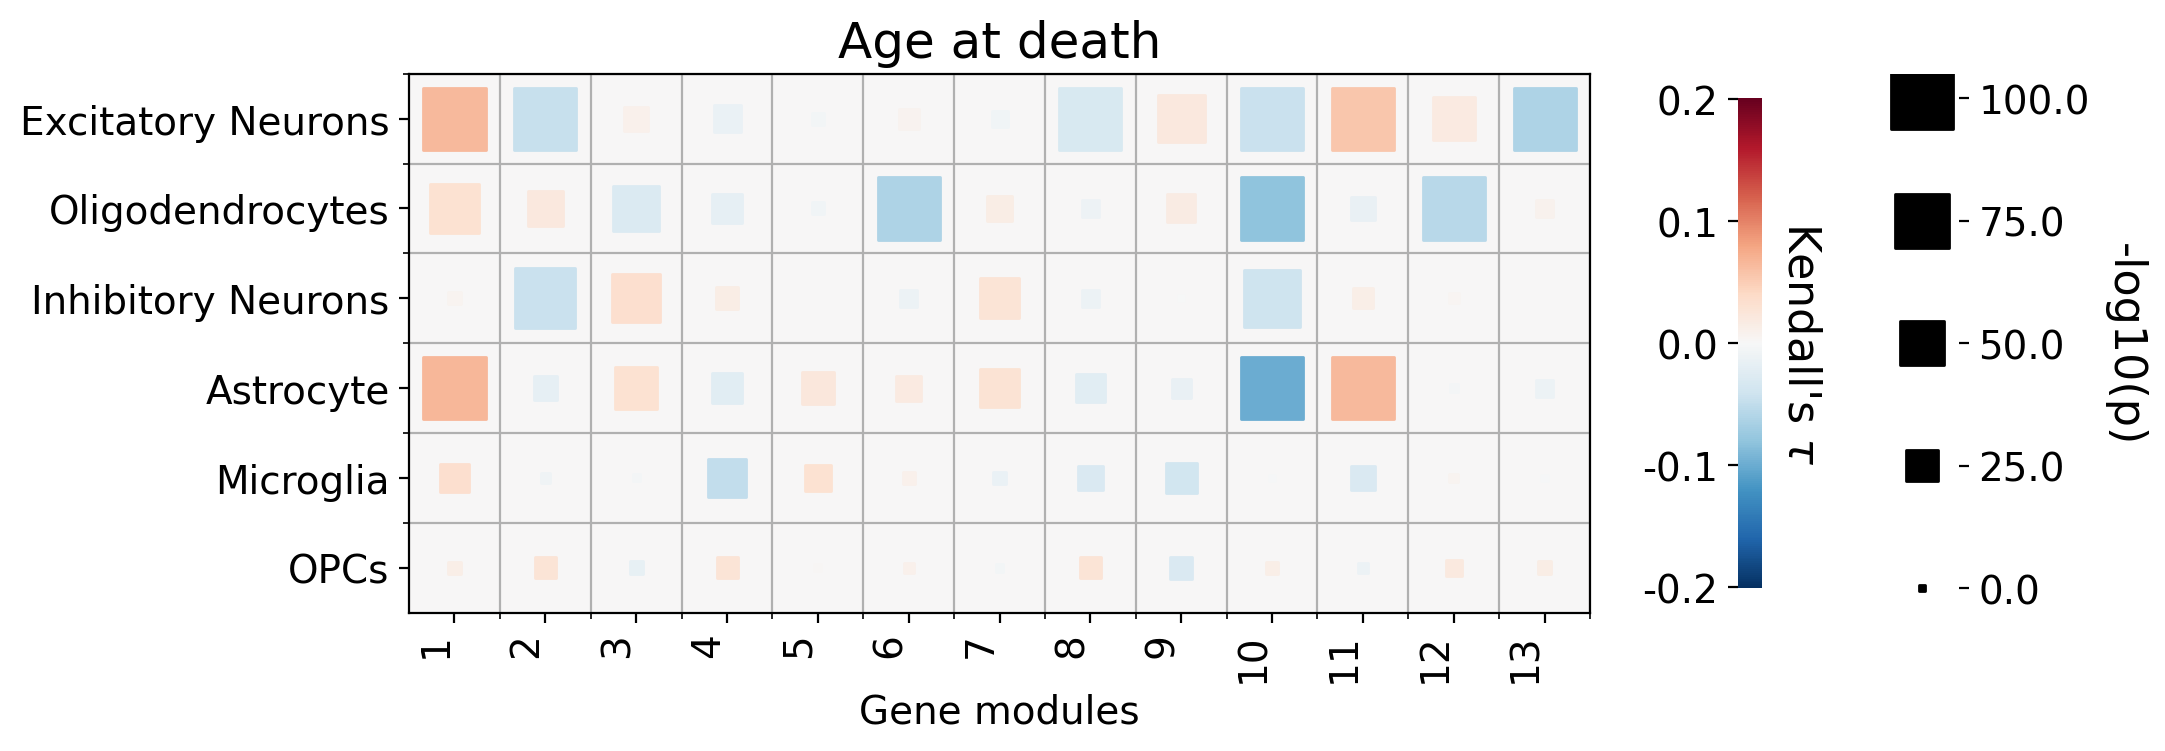

Hypertension
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


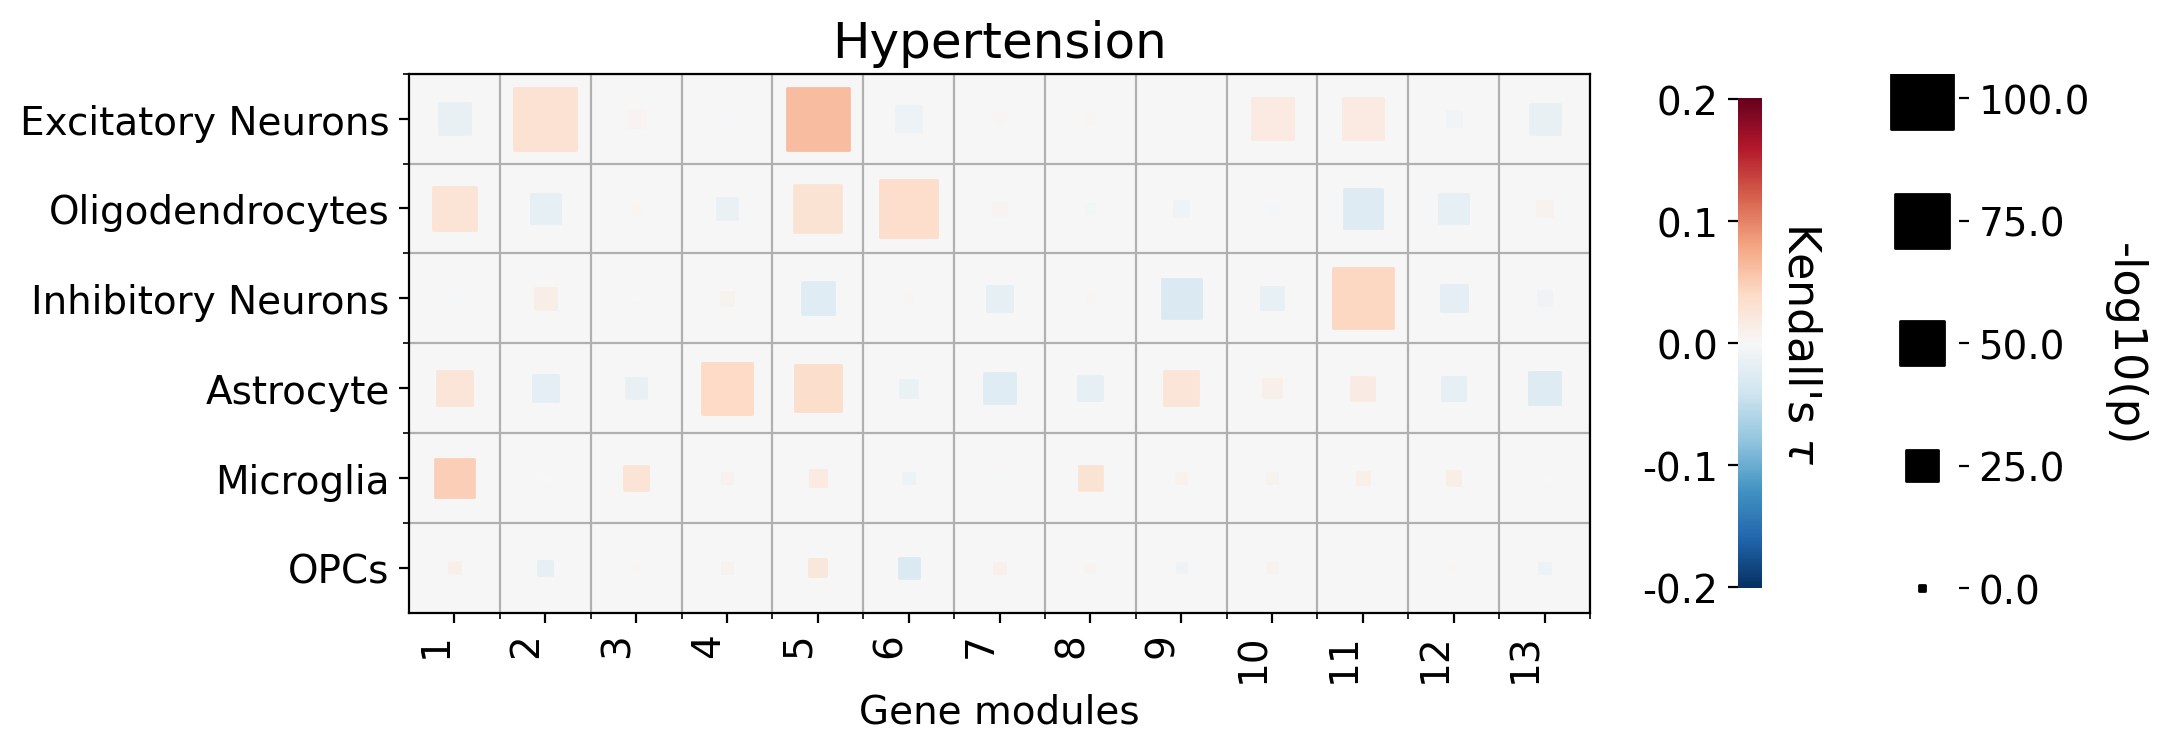

History of diabetes


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


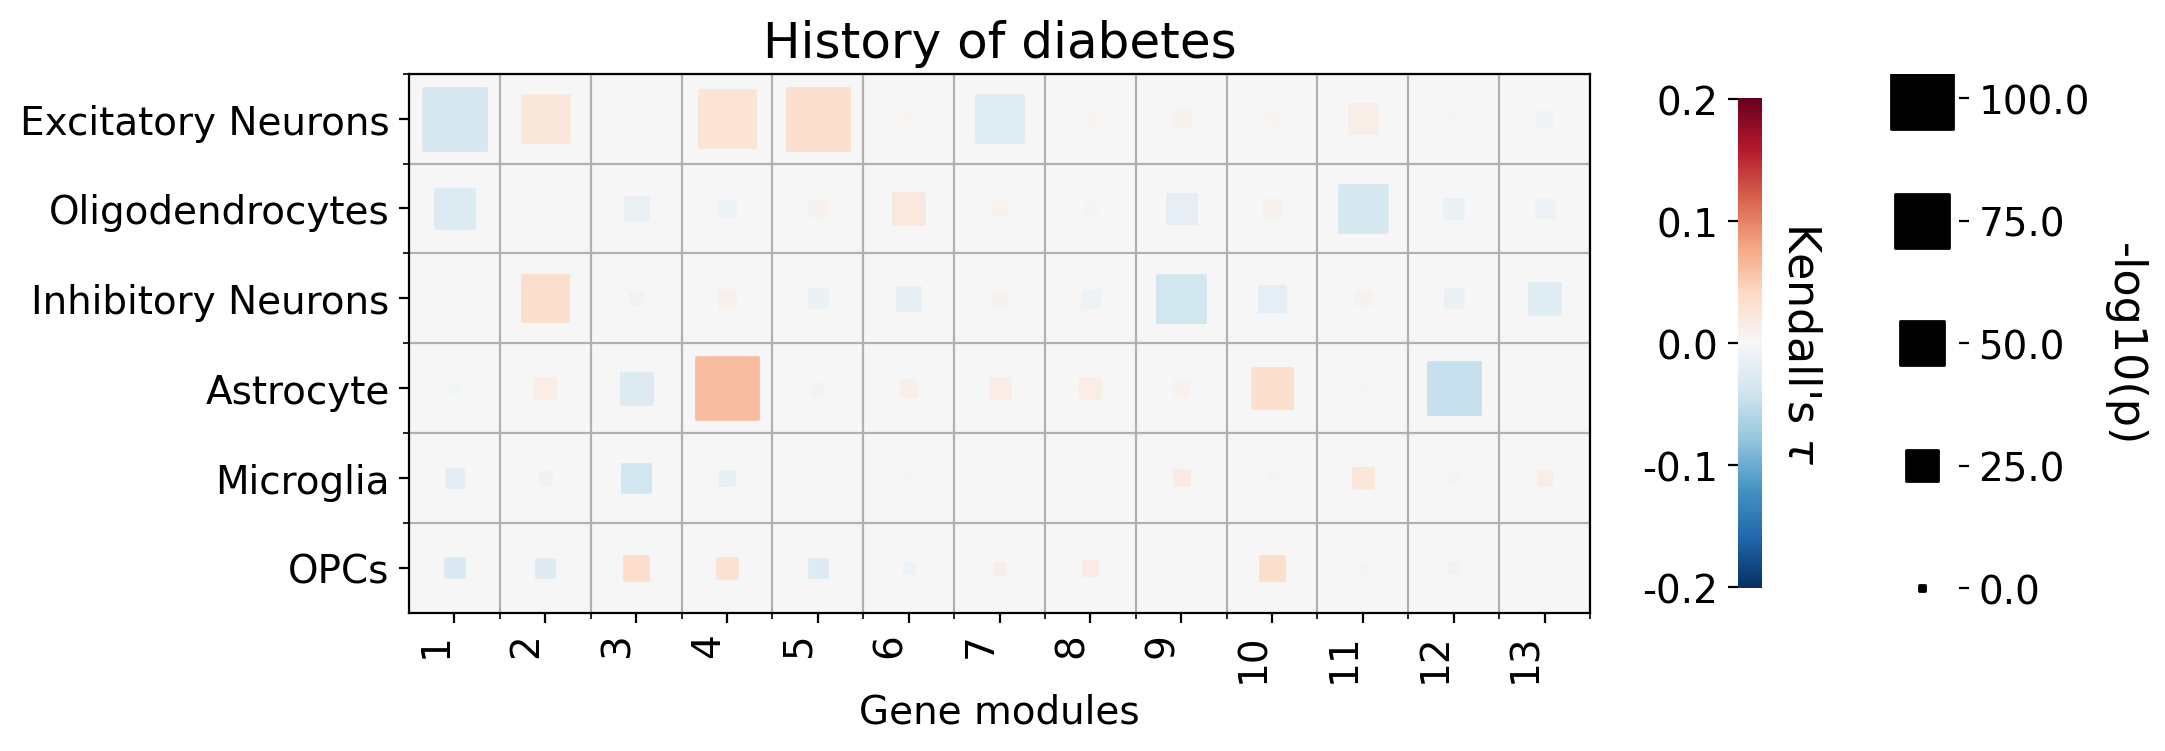

Cancer
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


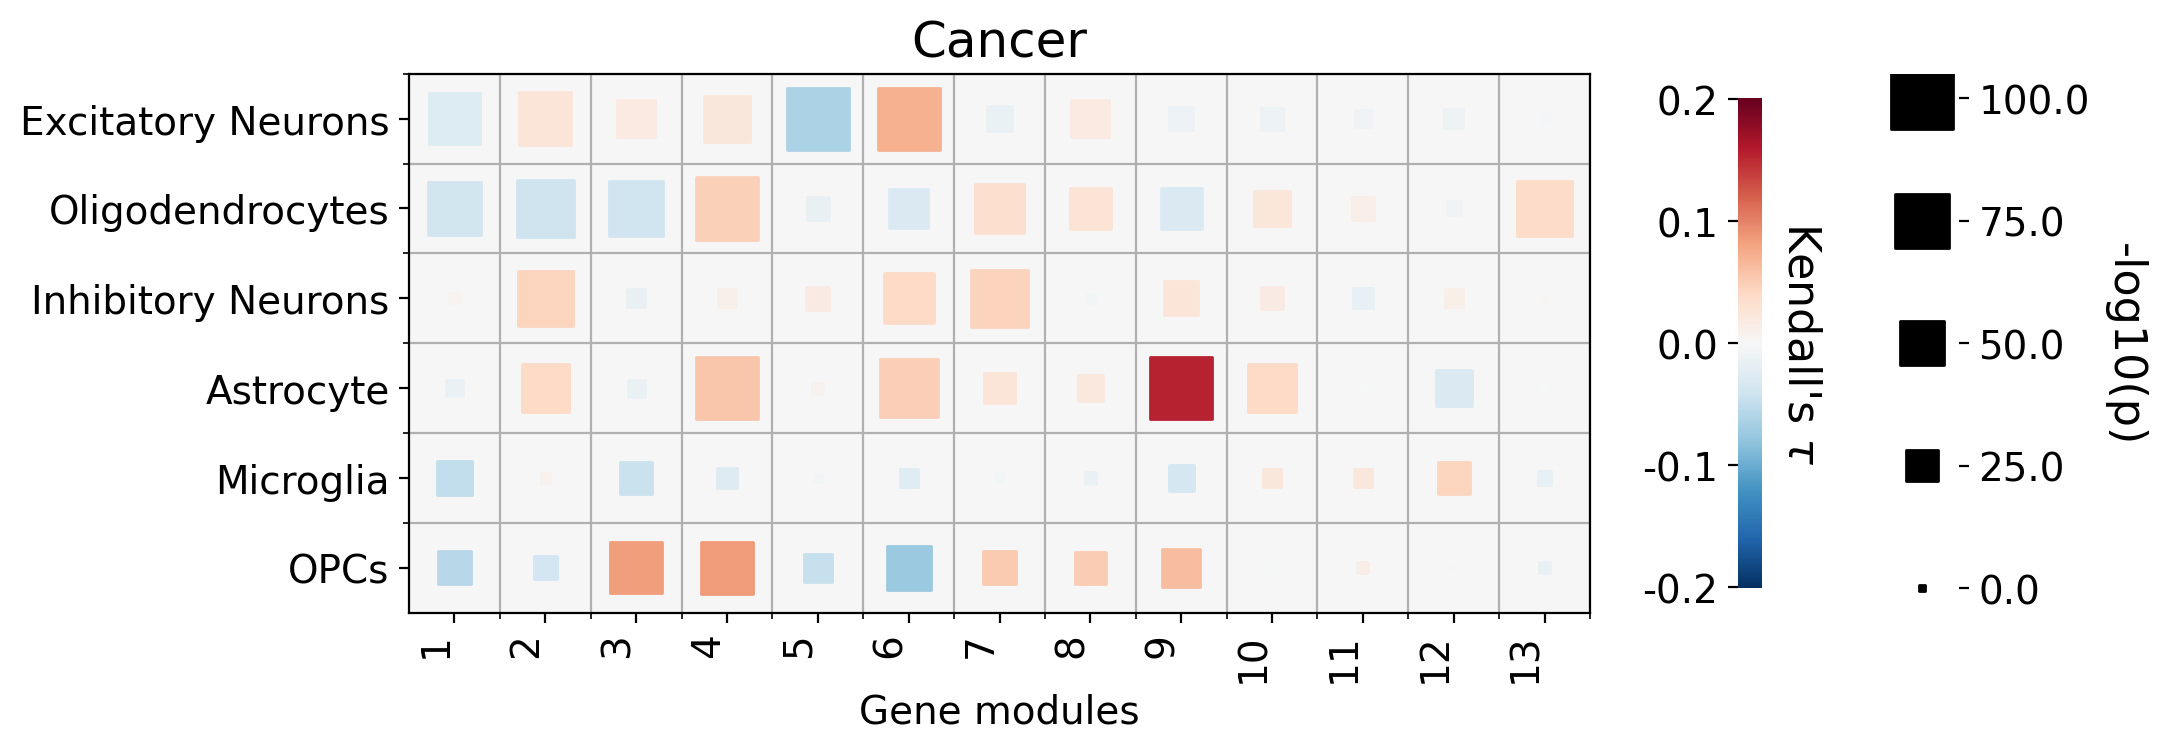

BMI
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


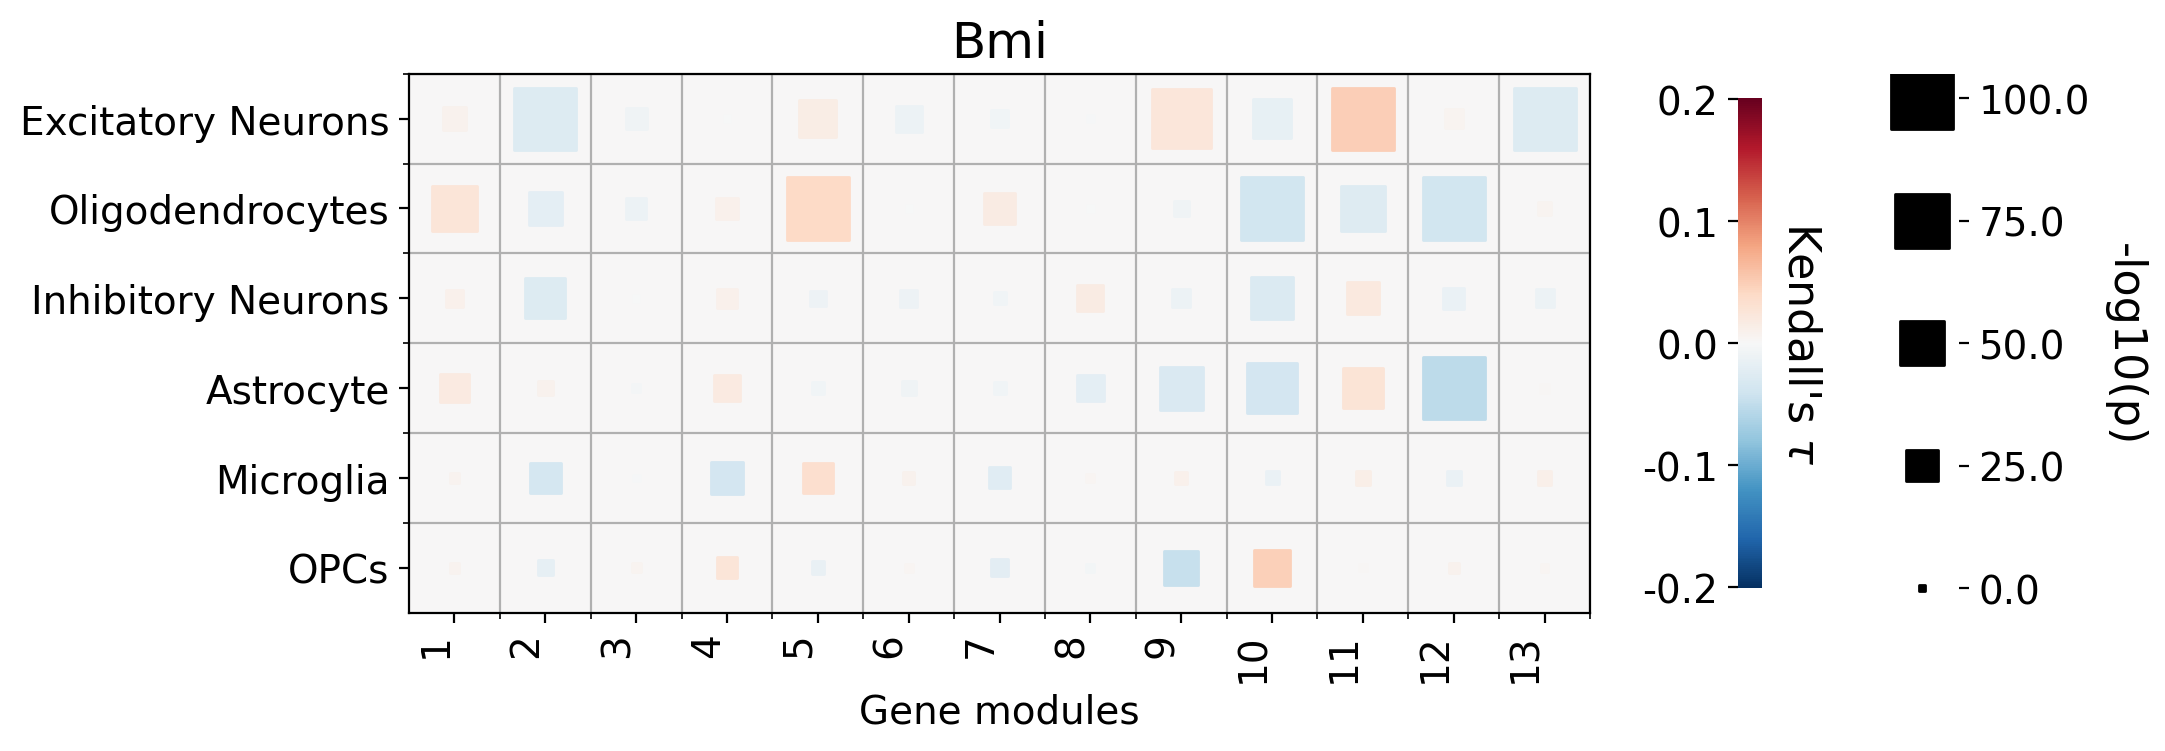

Clinical depression


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


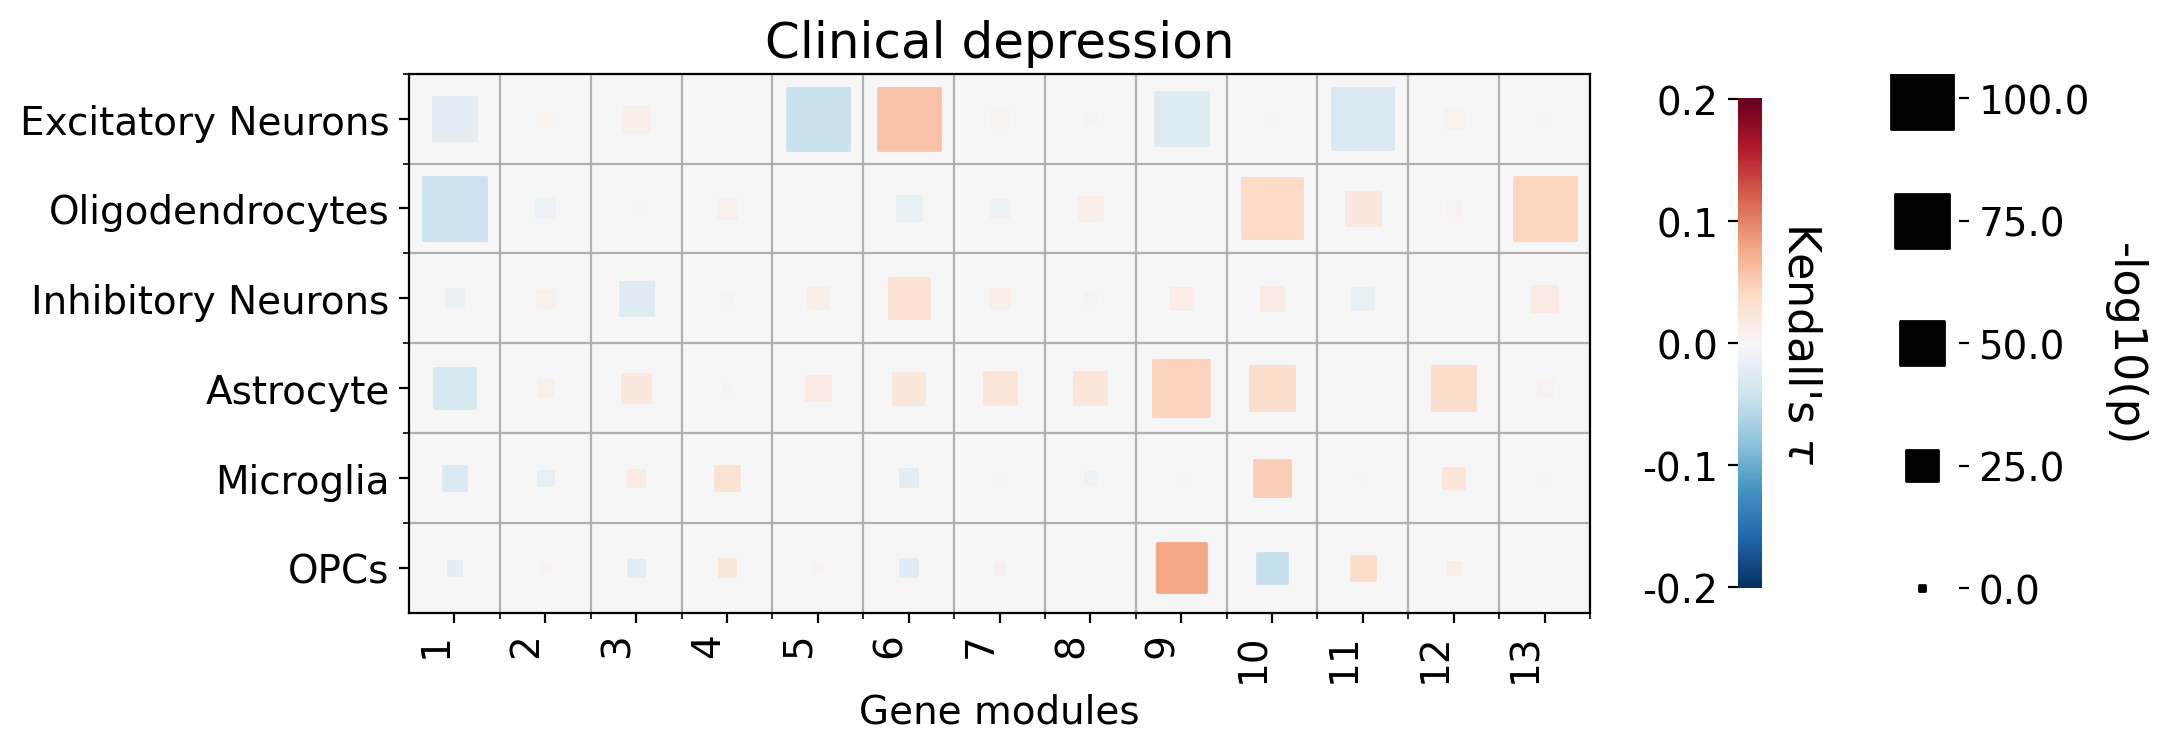

Presence of one or more chronic infarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


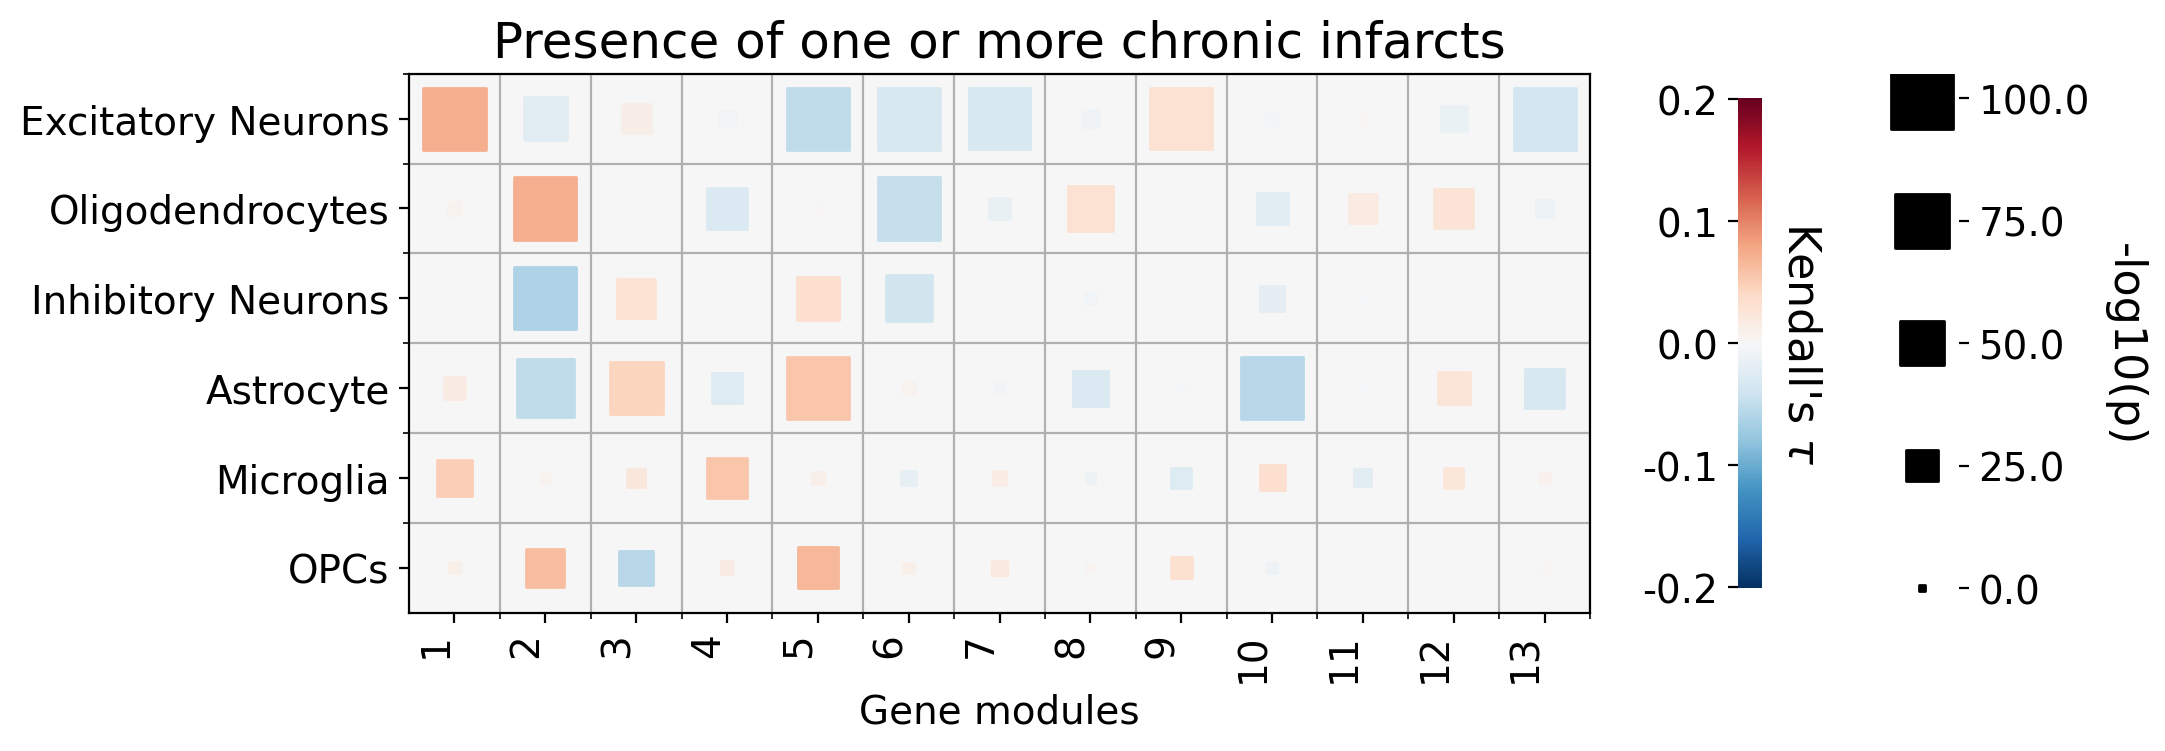

Chronic microinfarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


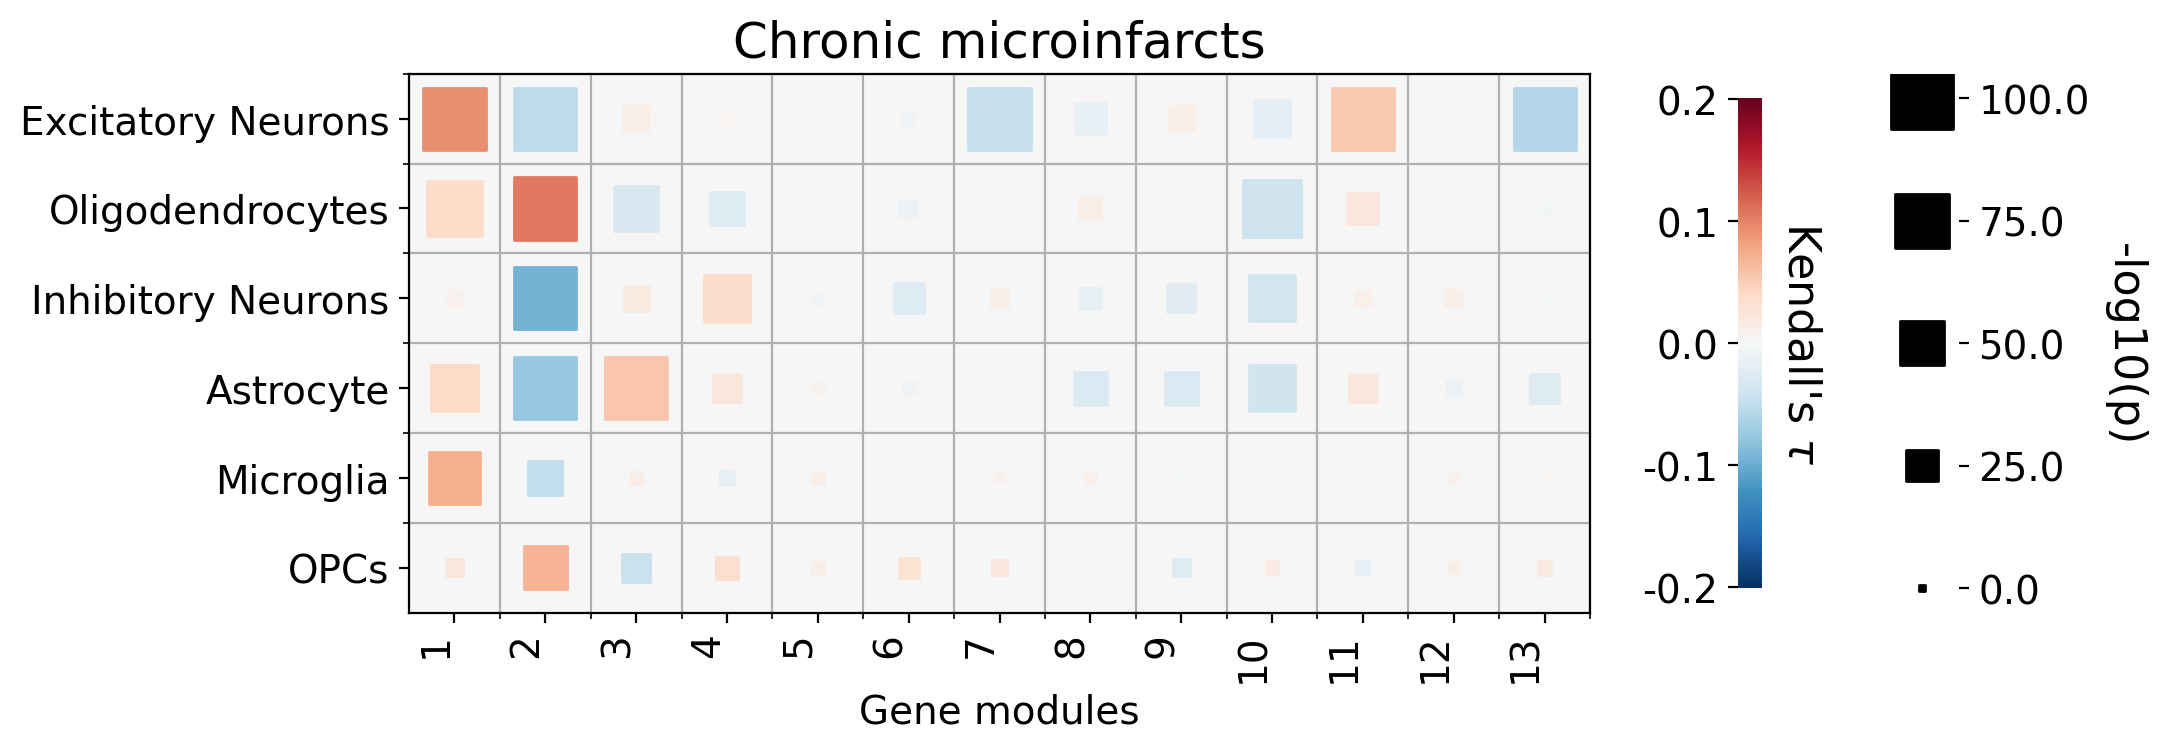

Gross chronic infarcts
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


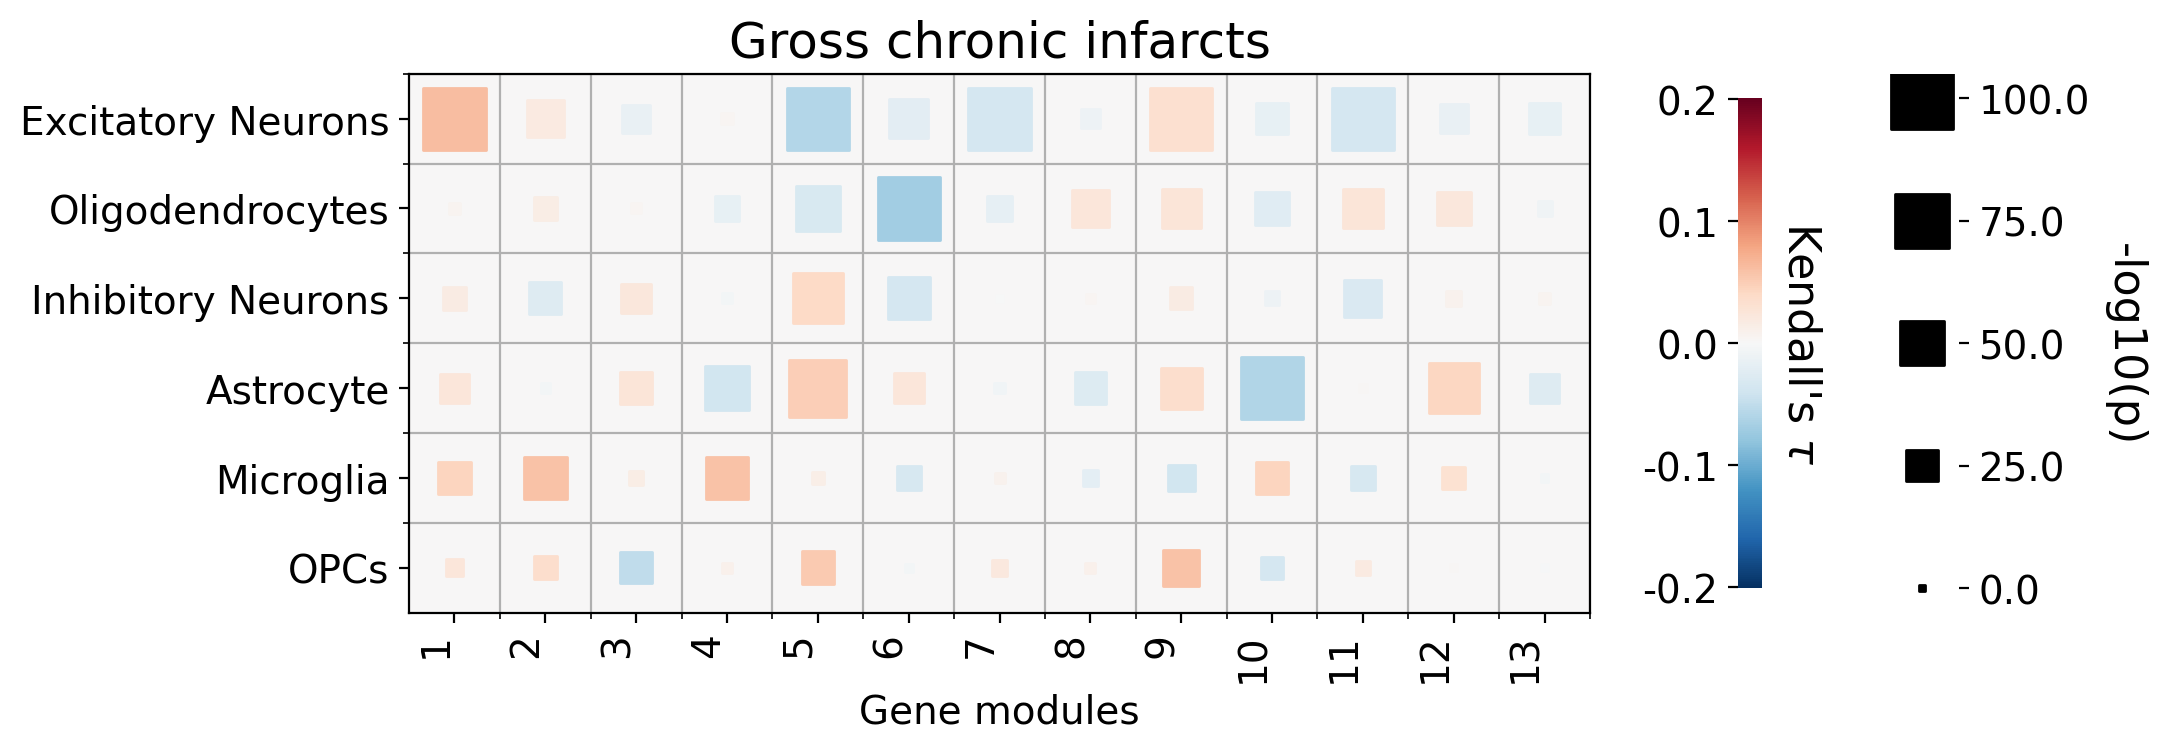

Arteriolosclerosis
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


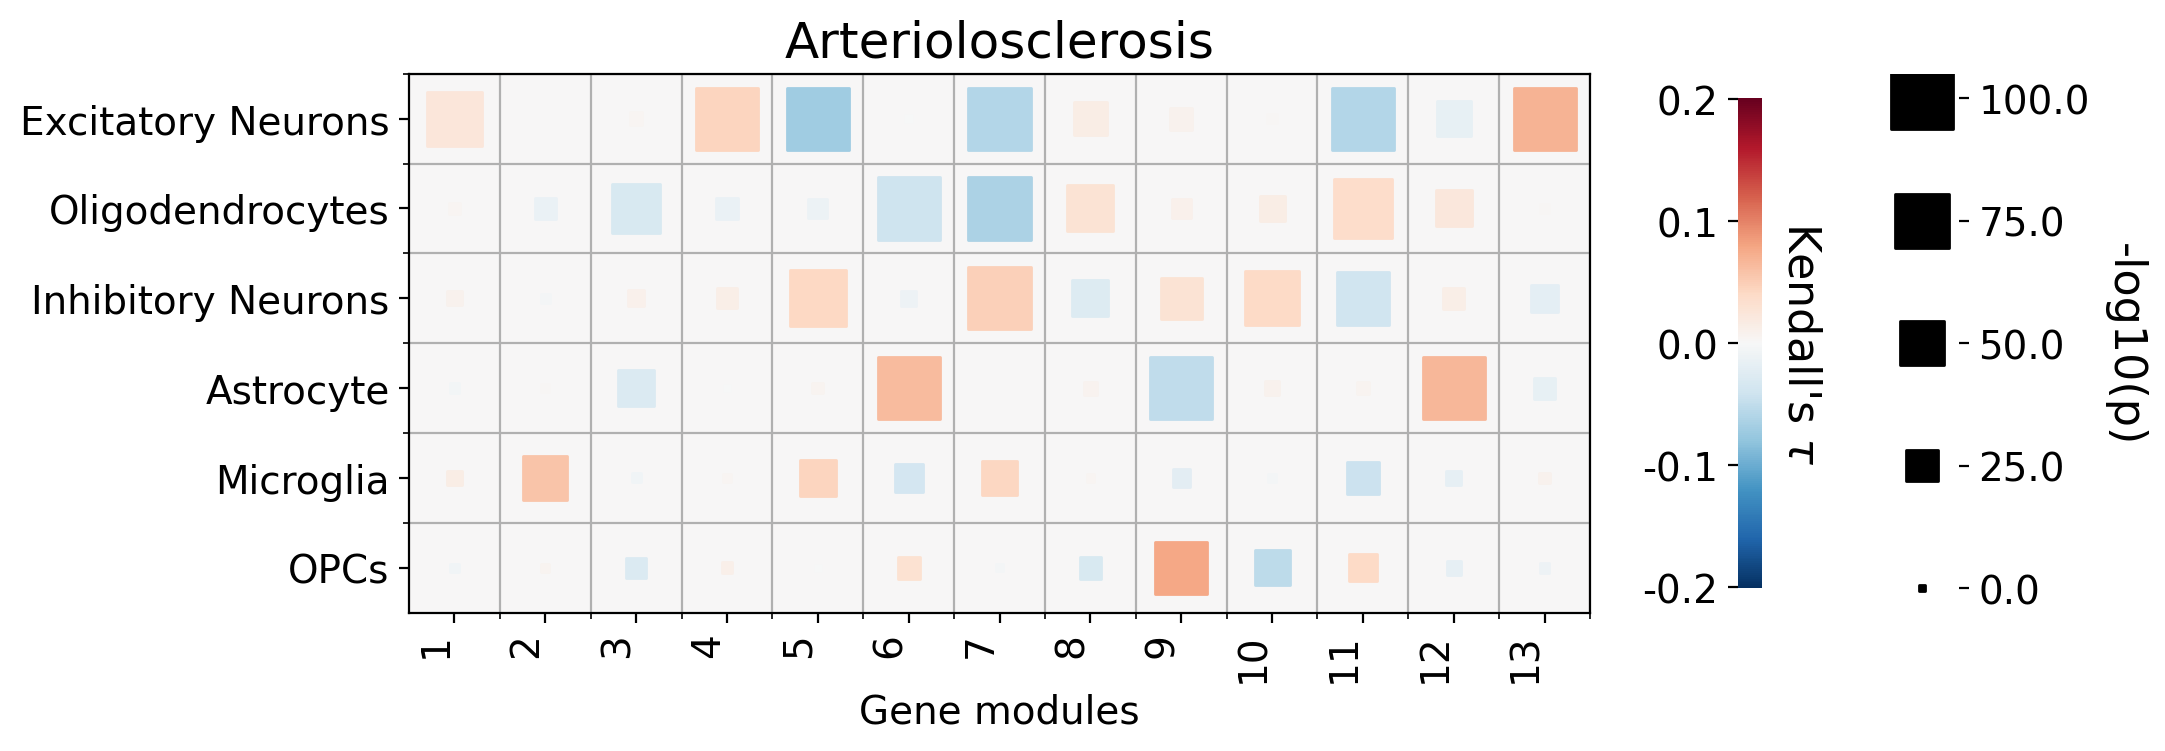

Cerebral atherosclerosis
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


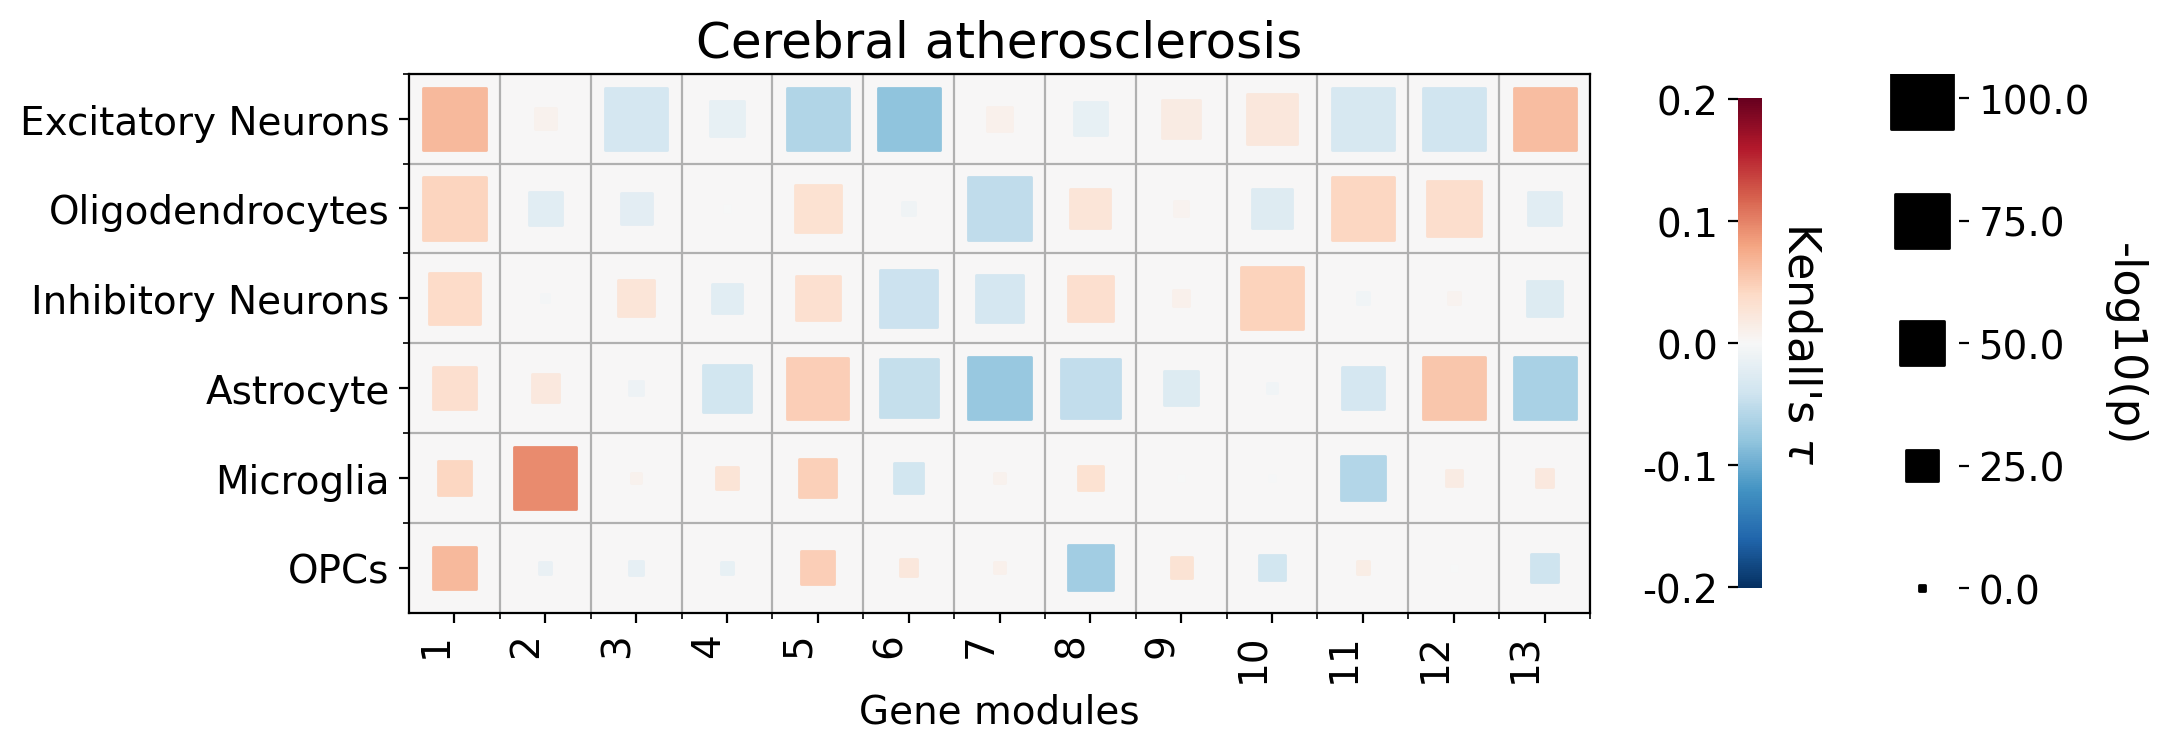

Cerebral amyloid angiopathy
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


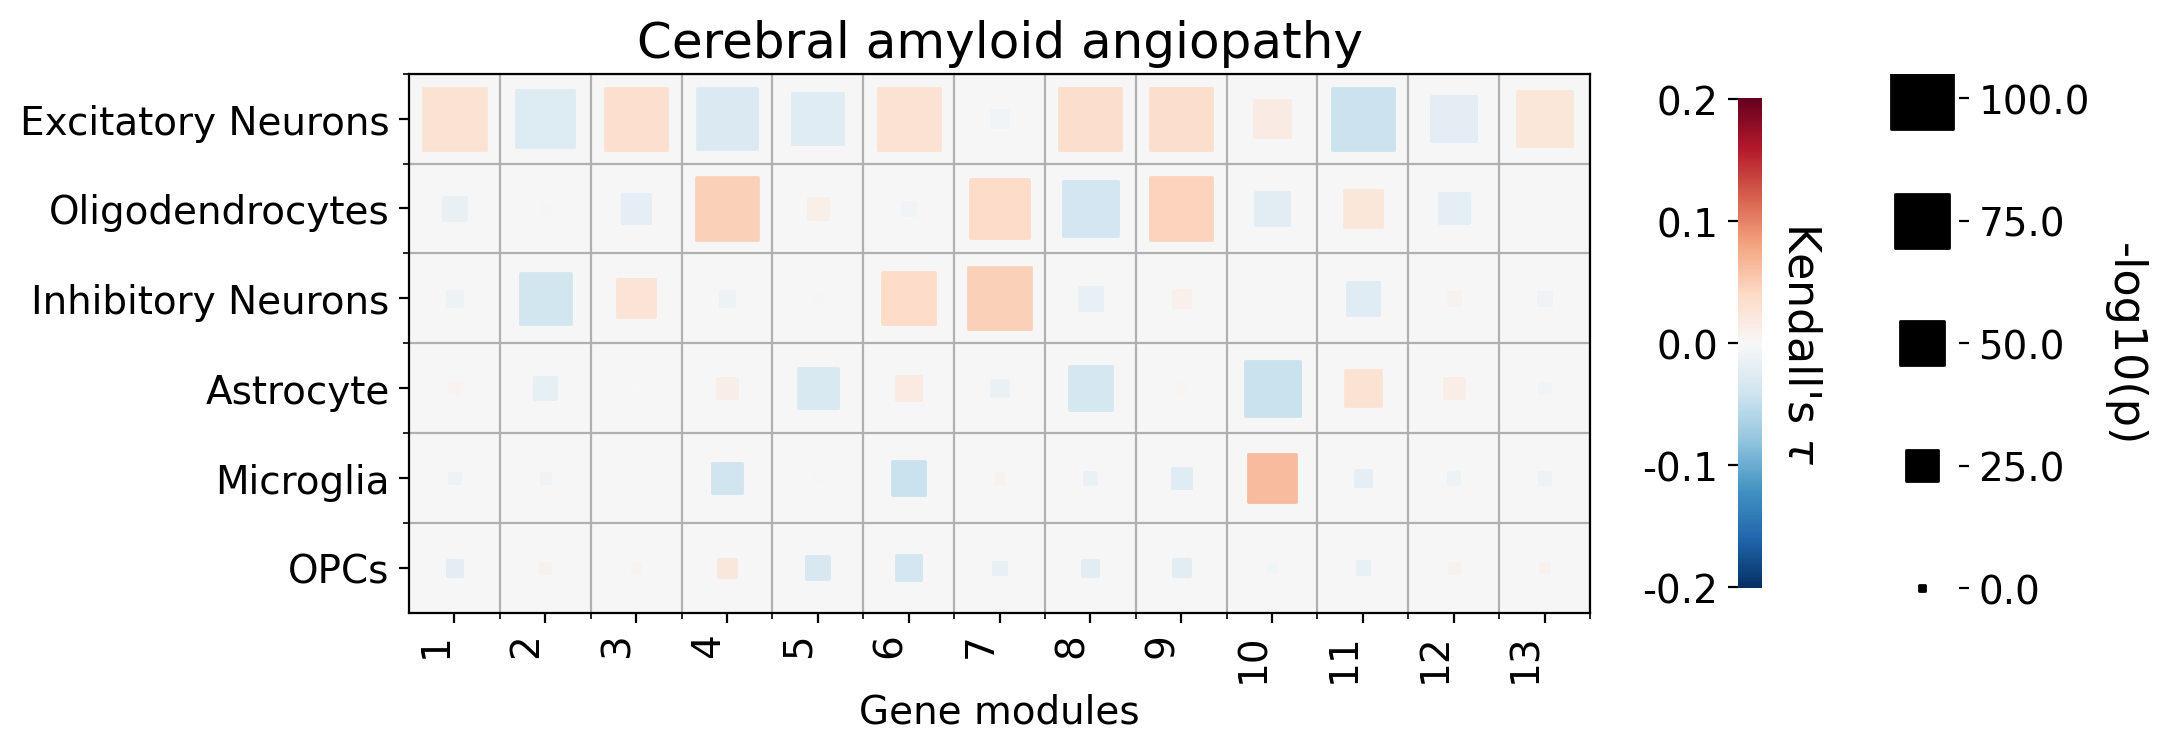

Lewy body load


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


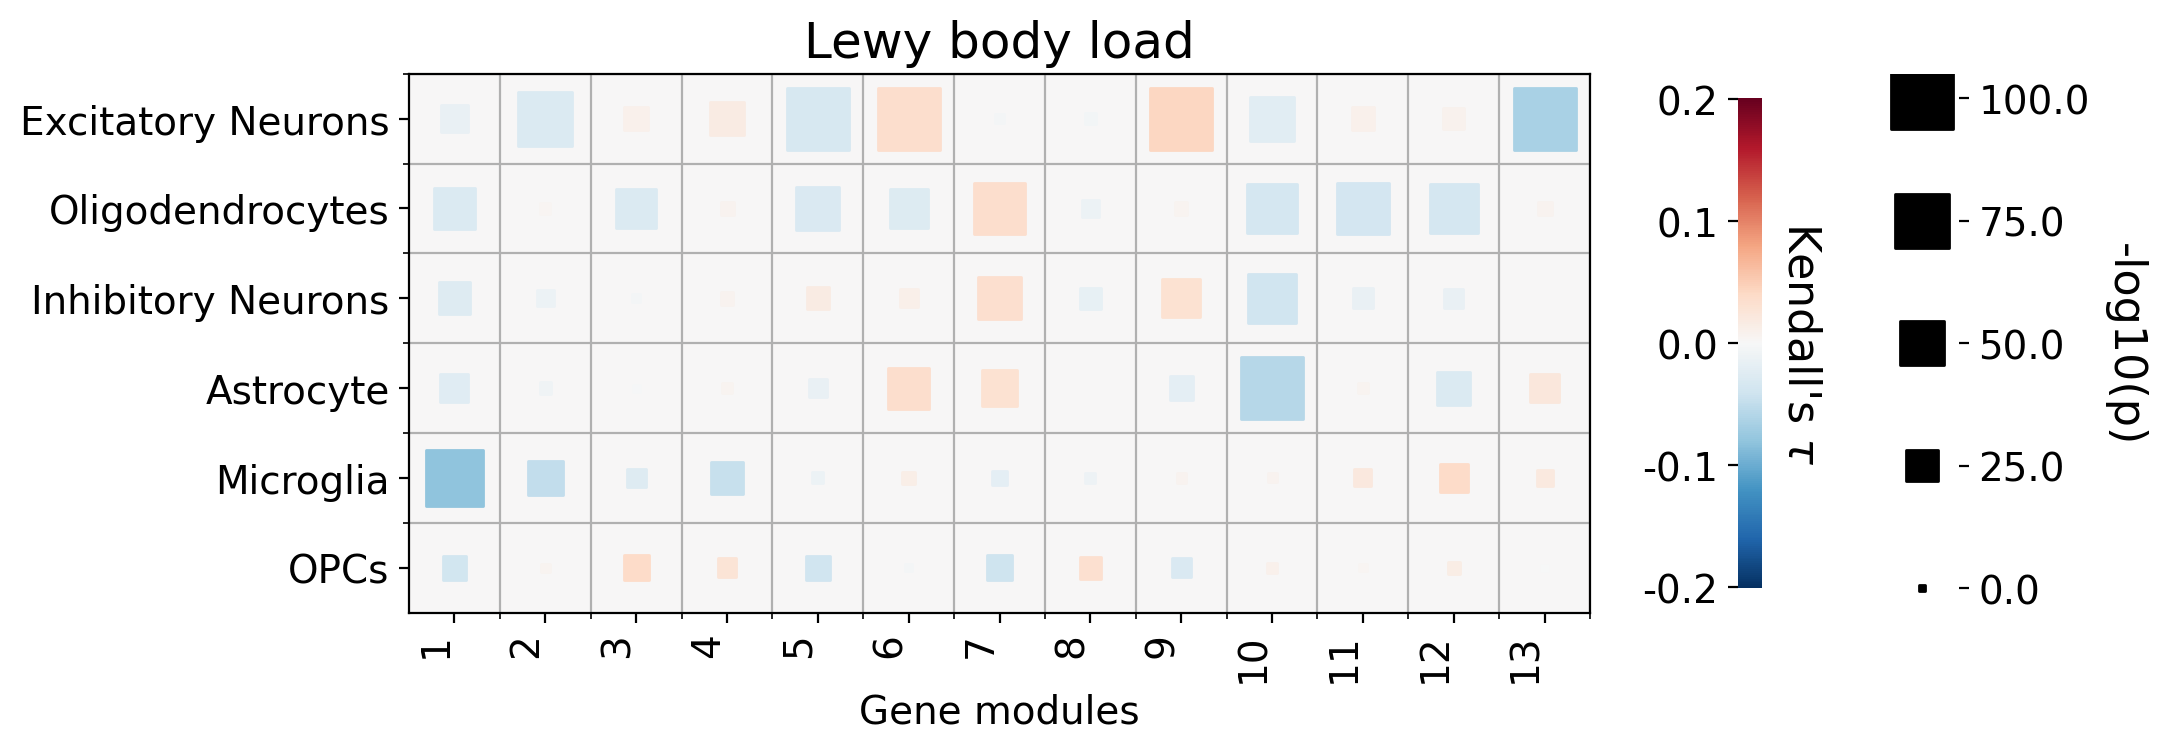

TDP-43 stage
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


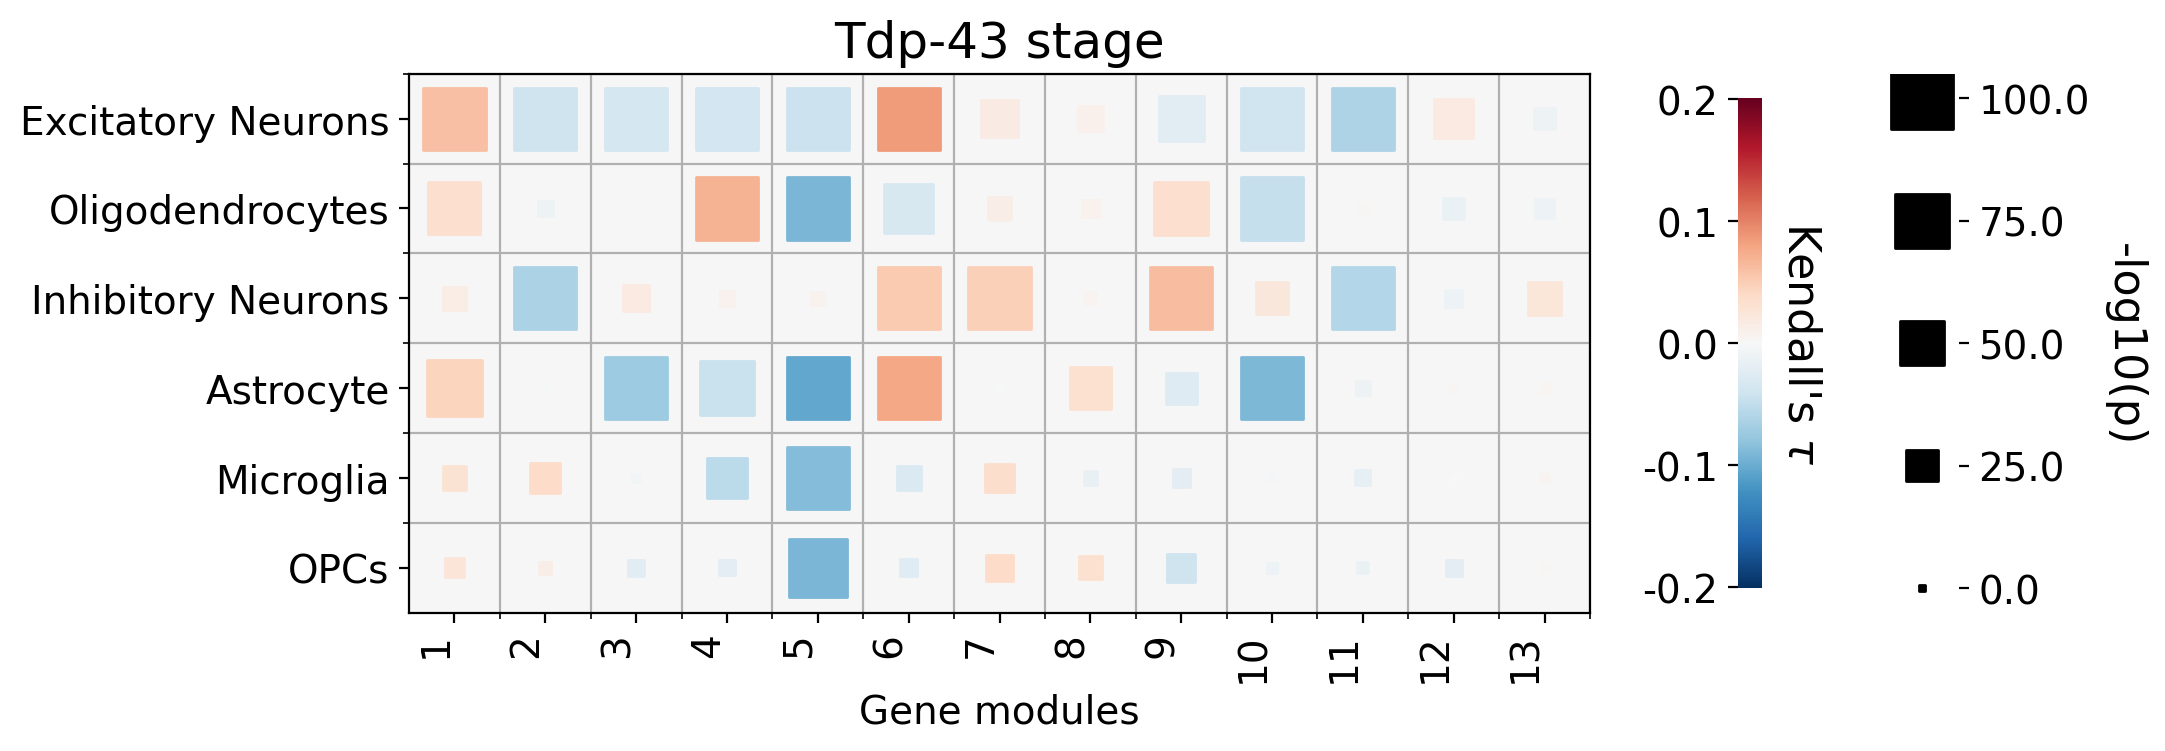

Pathologic diagnosis of Lewy Body disease
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


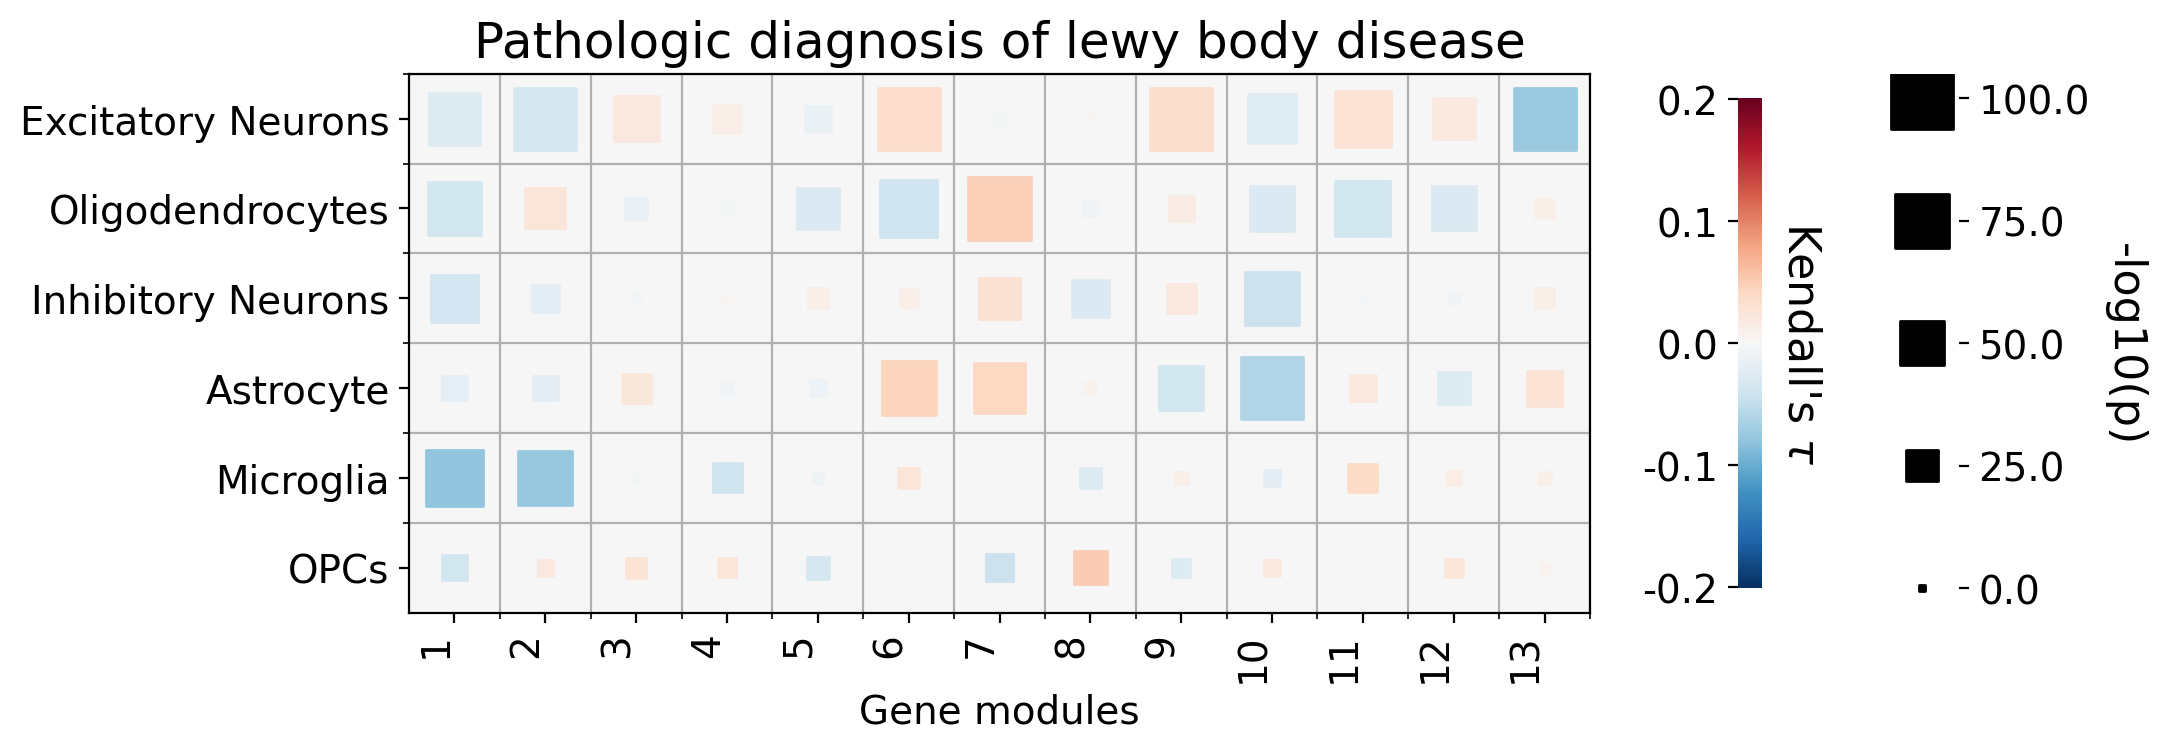

Parkinson's-like symptoms


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


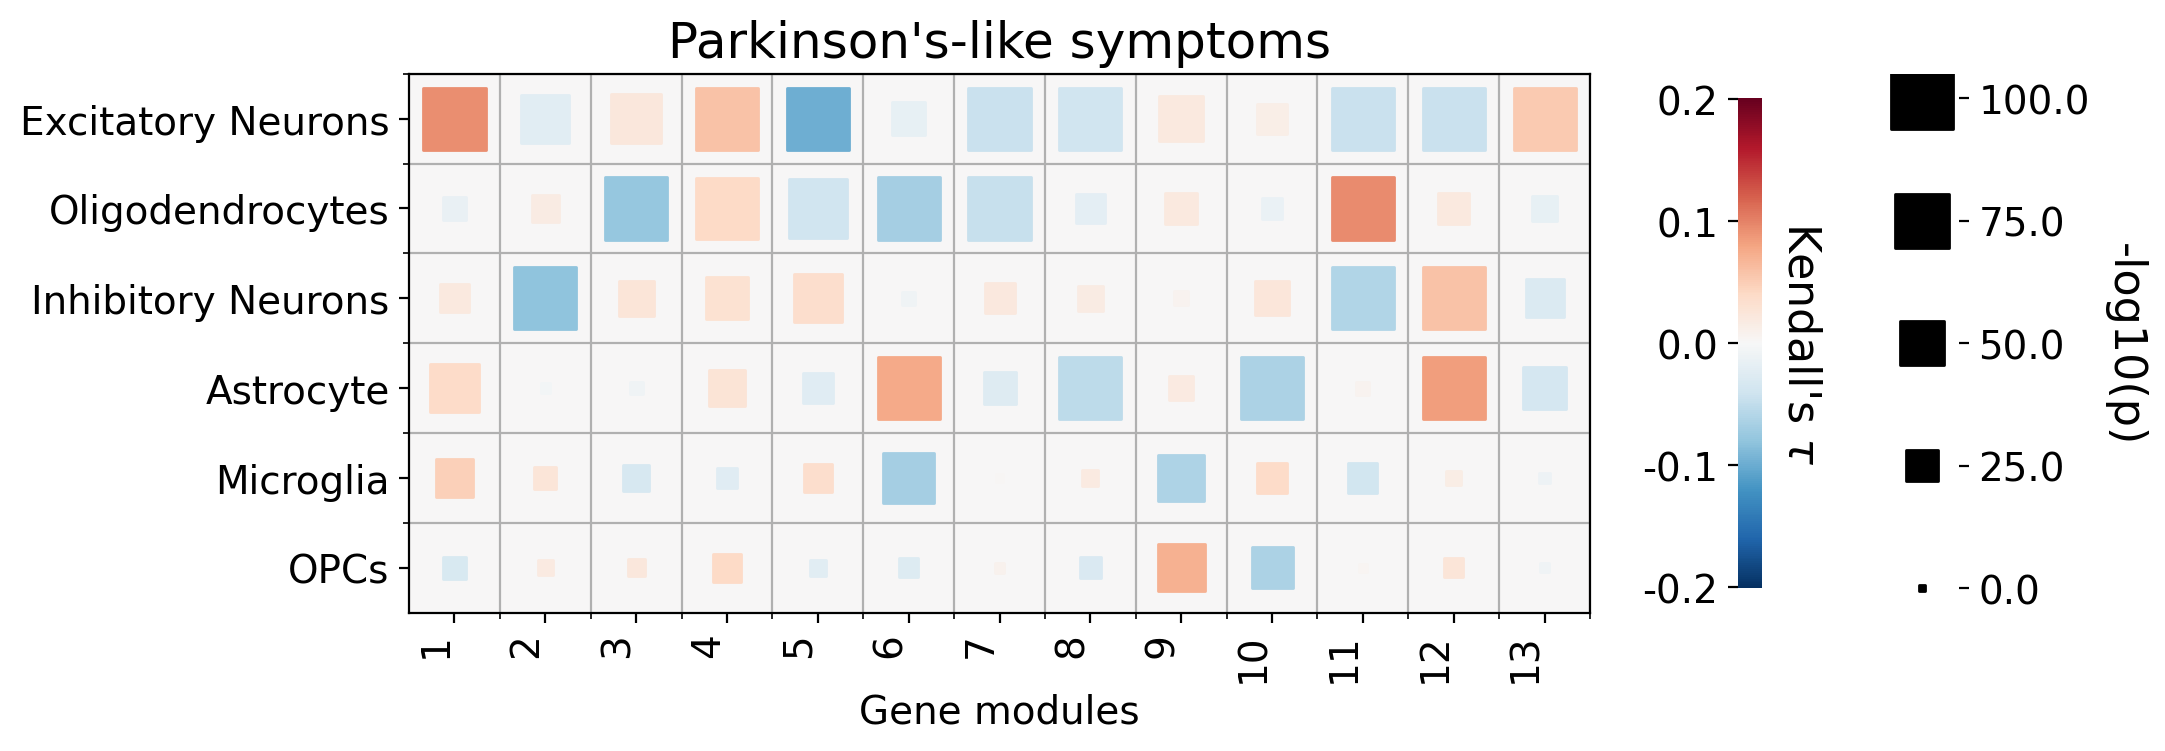

CERAD score
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


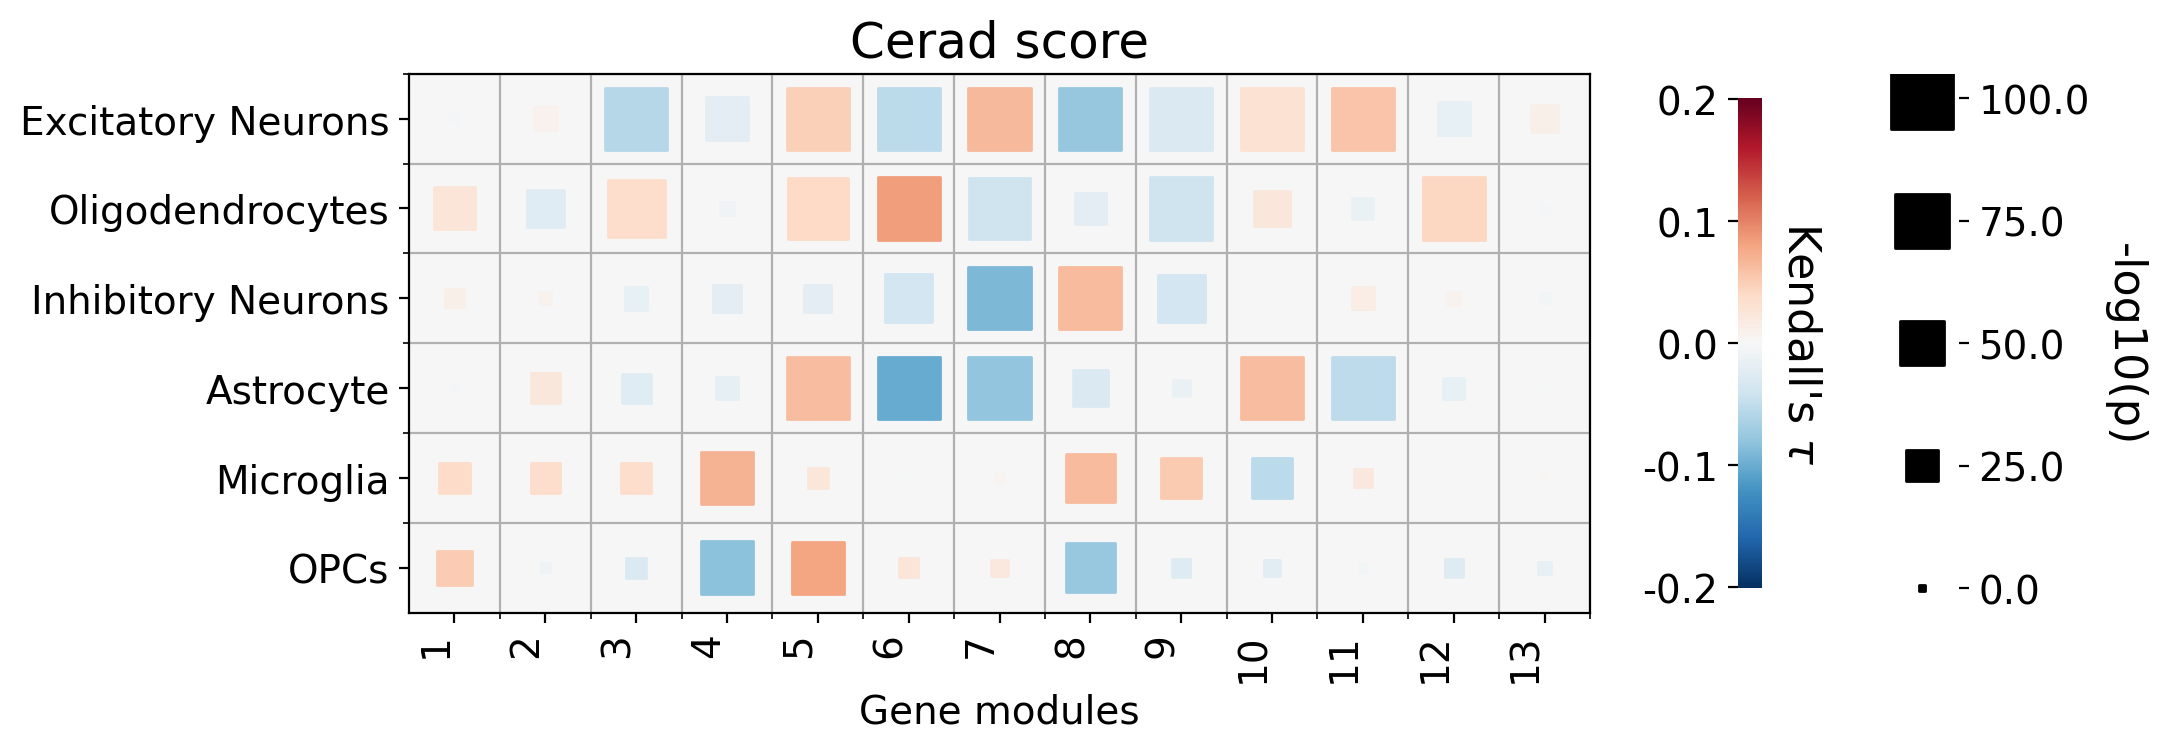

ε4 status
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


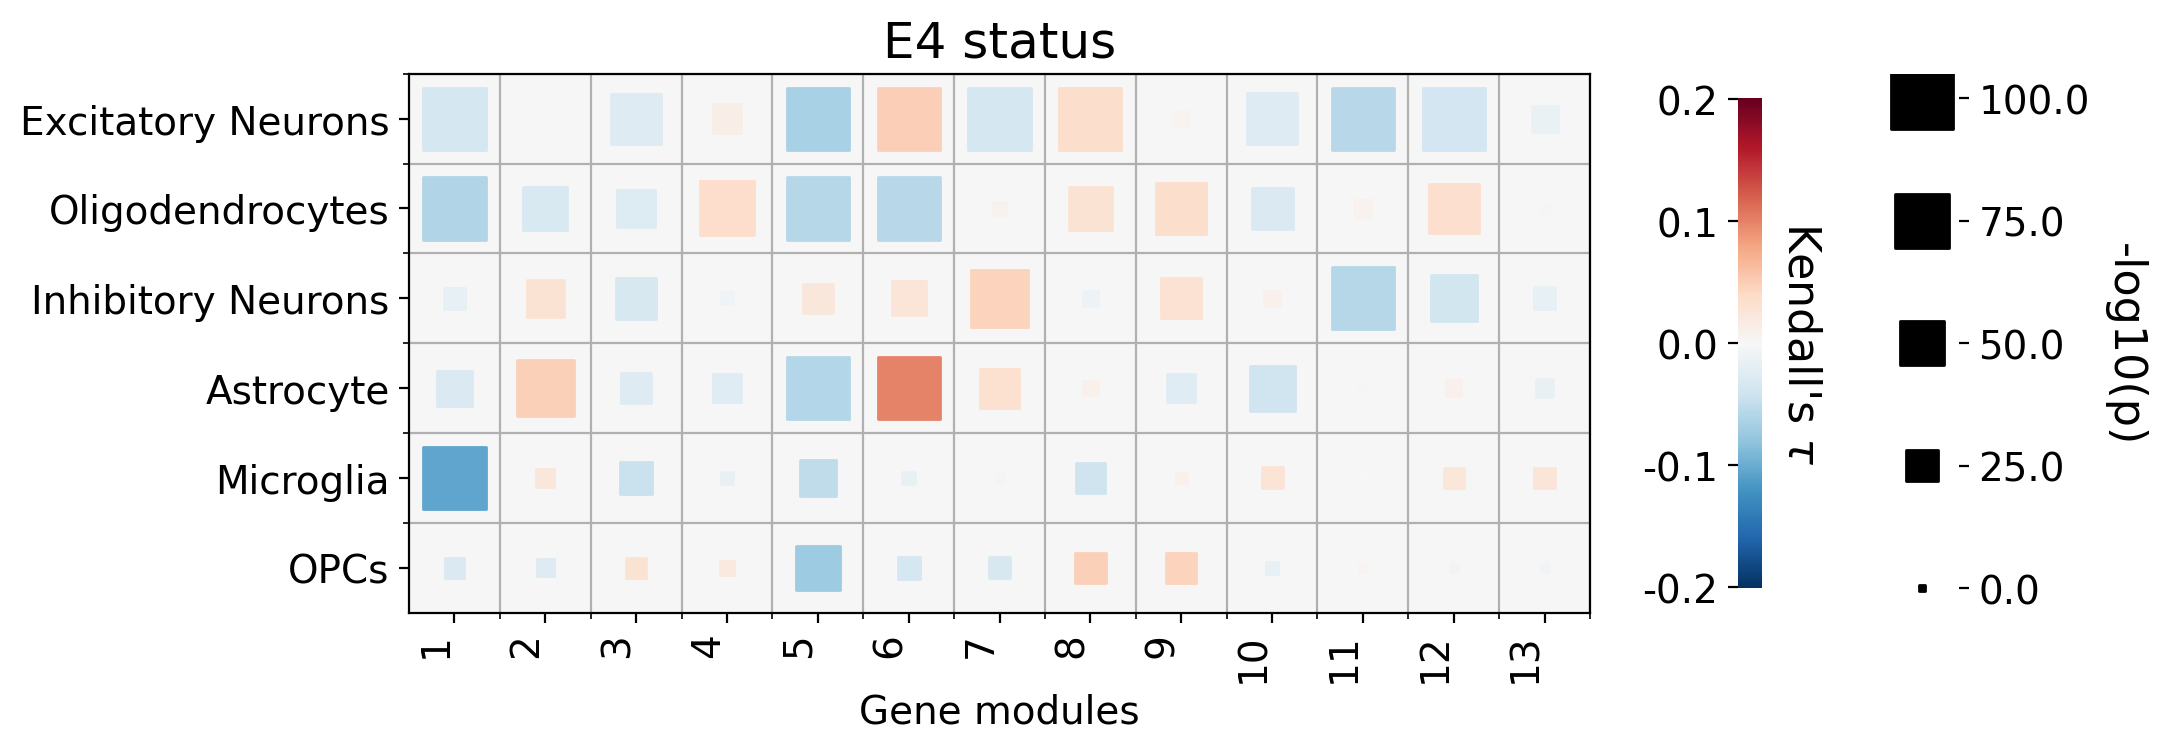

Neurofibrillary tangle scores


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


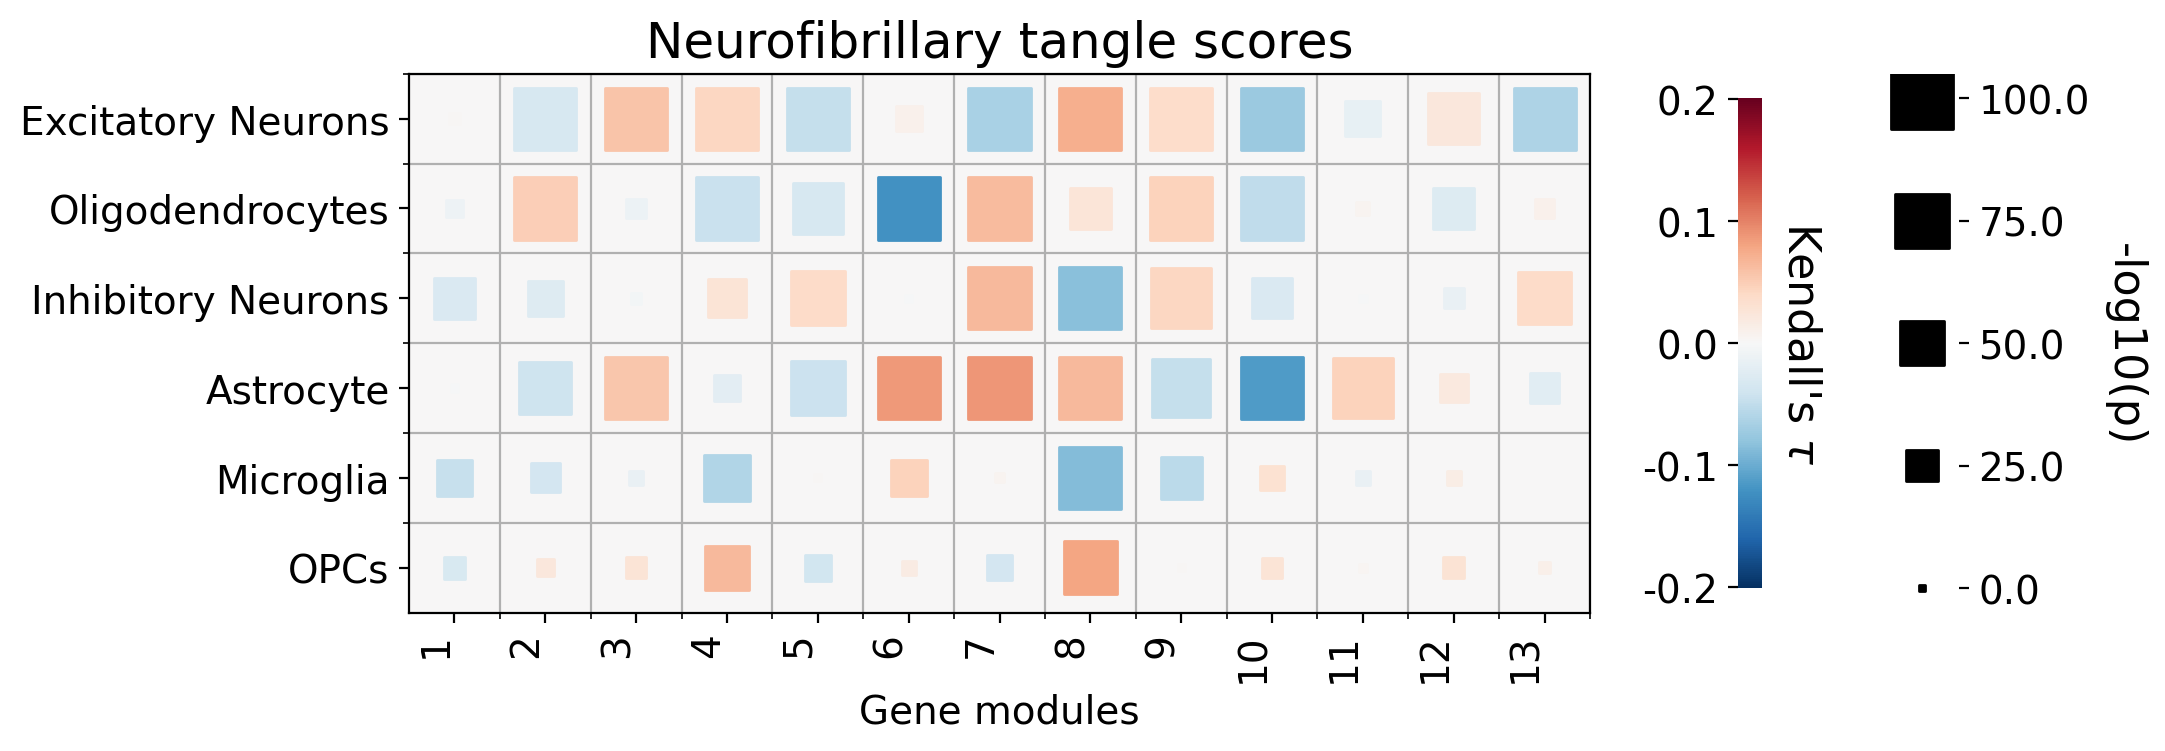

Neurofibrillary tangle burden
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


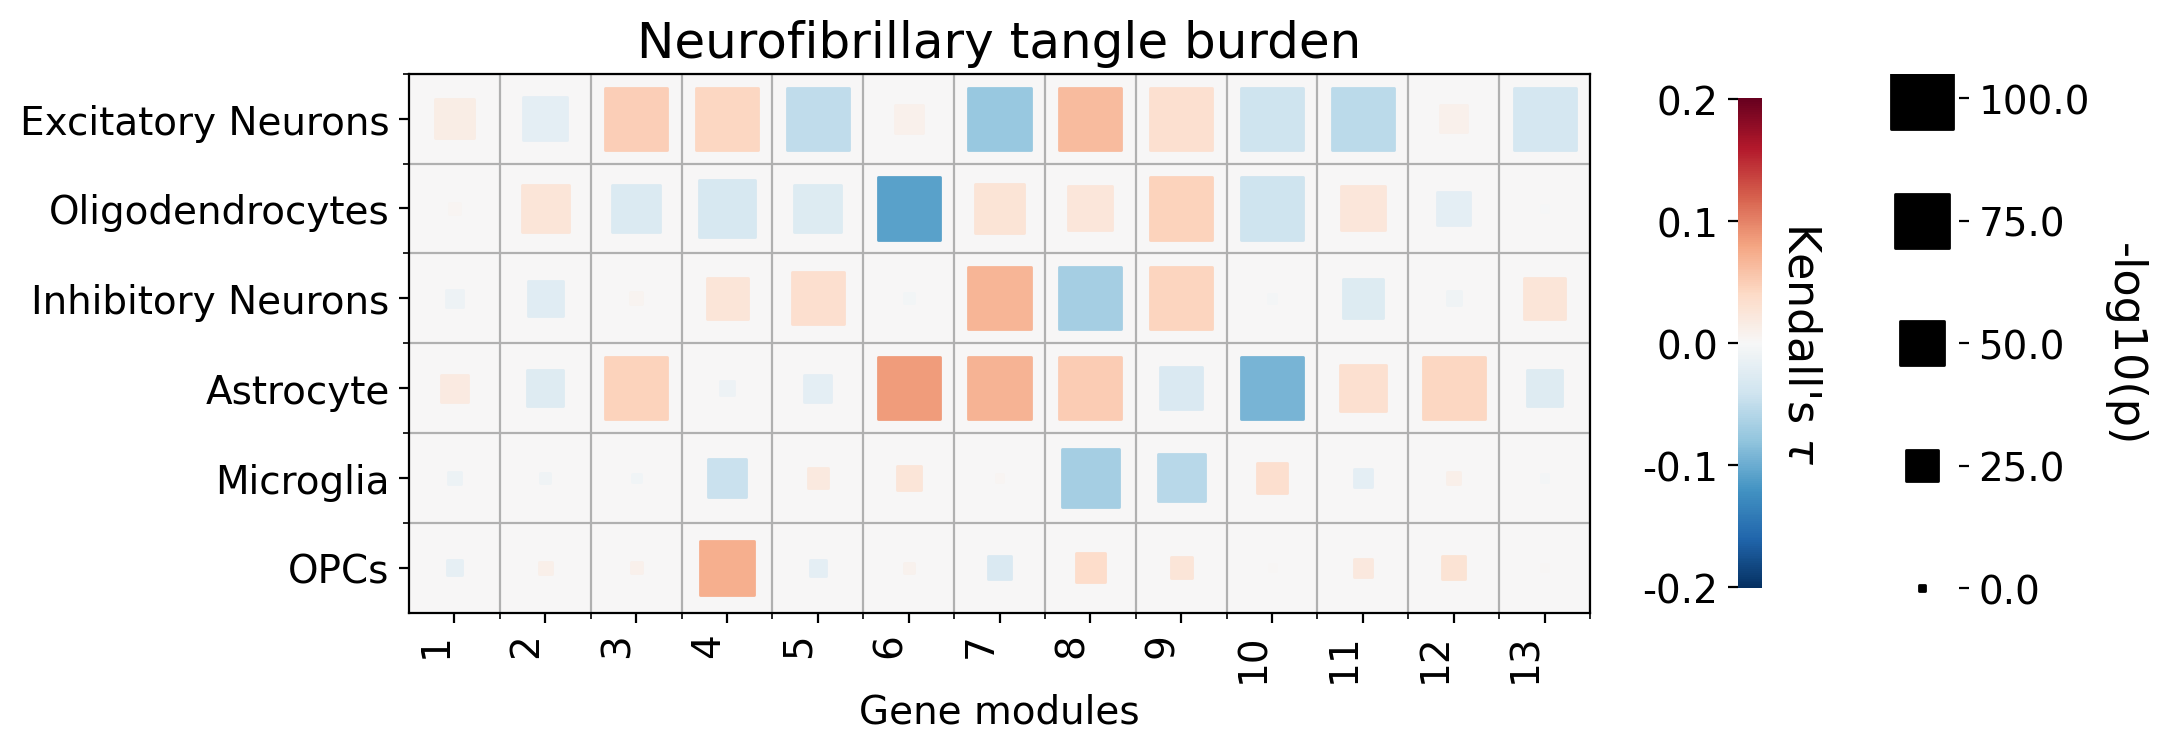

Tau Tangle Density
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


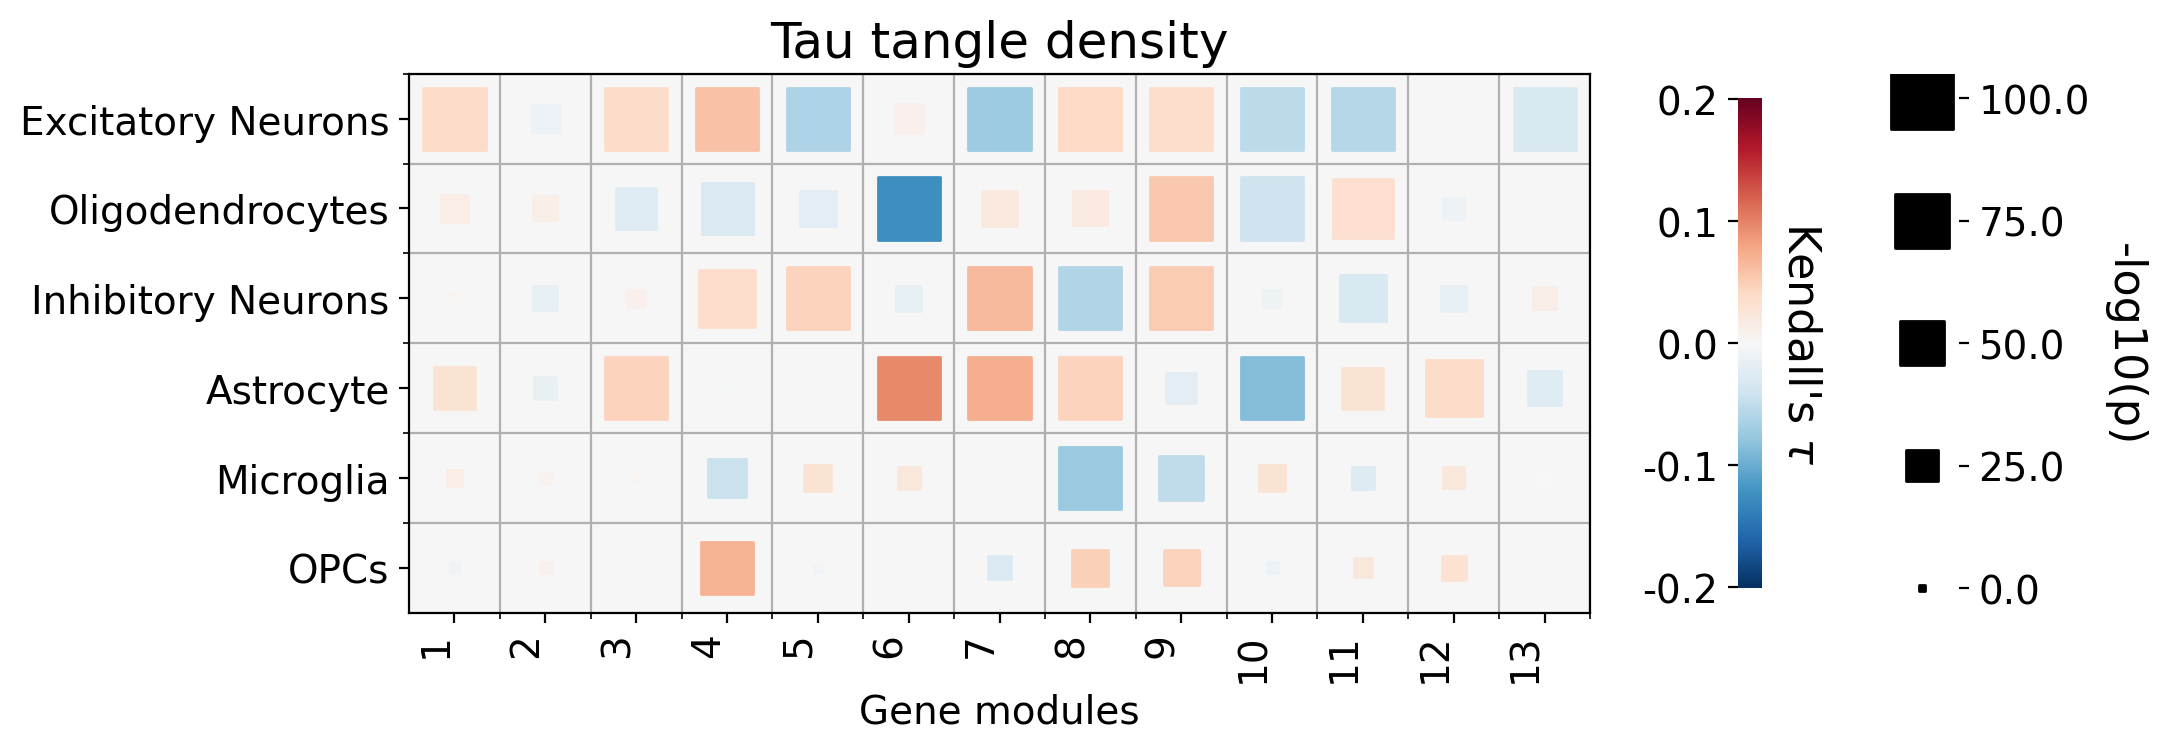

Amyloid load
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


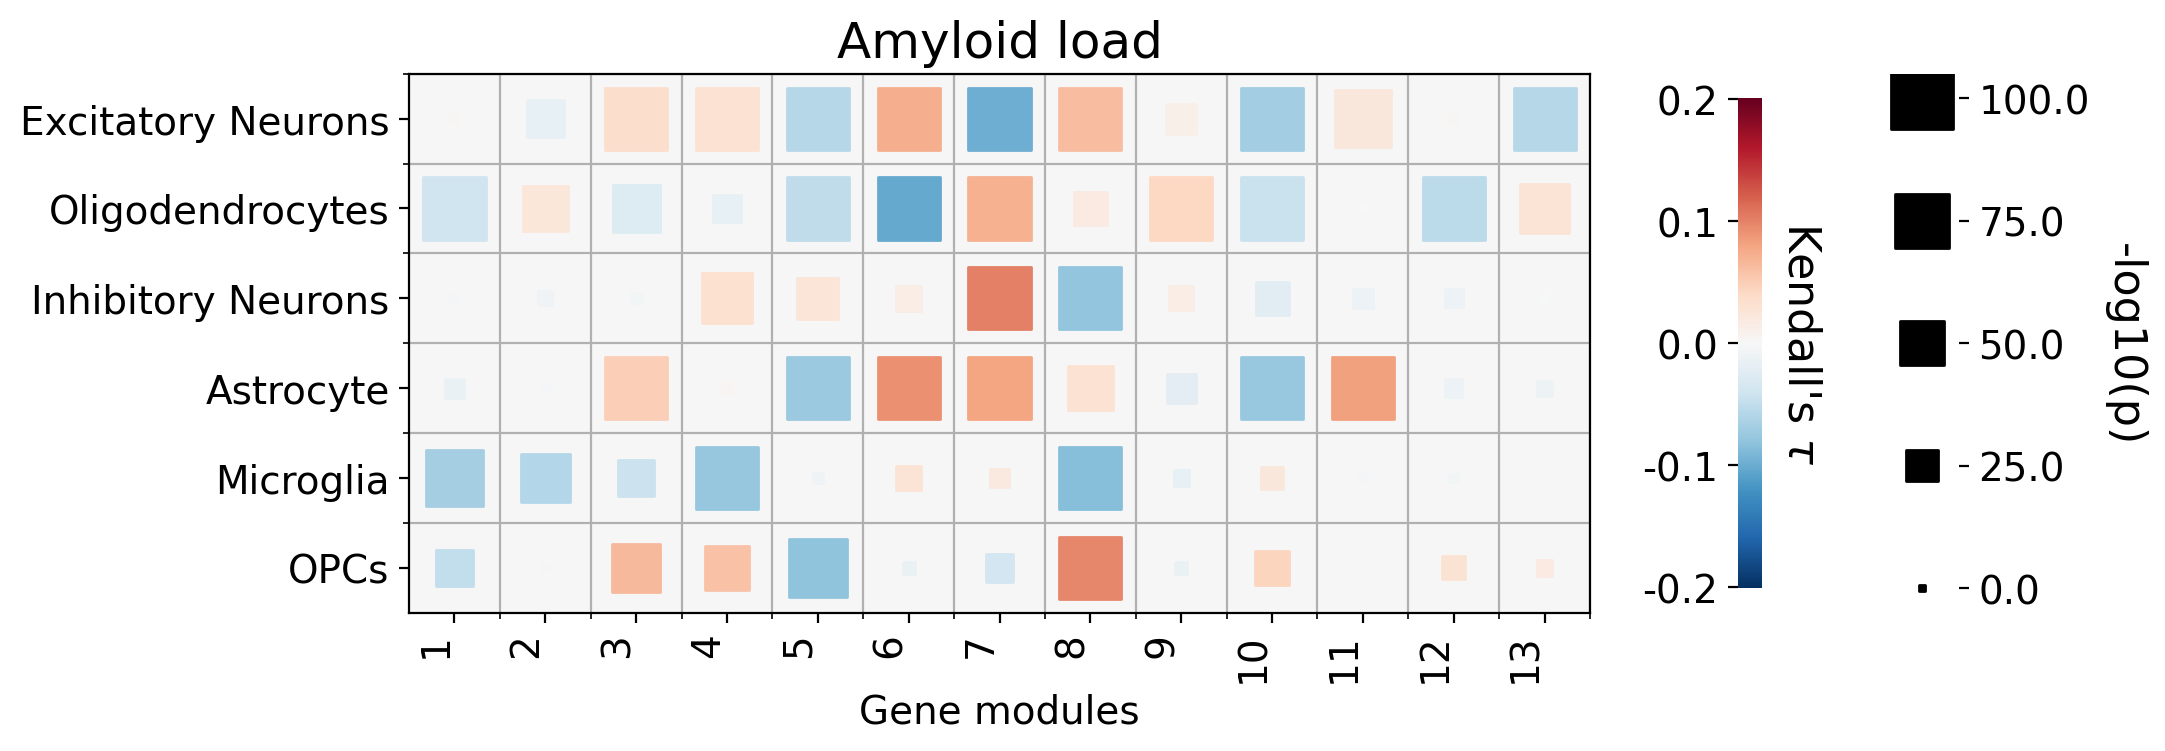

Presence of neurite plaques


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


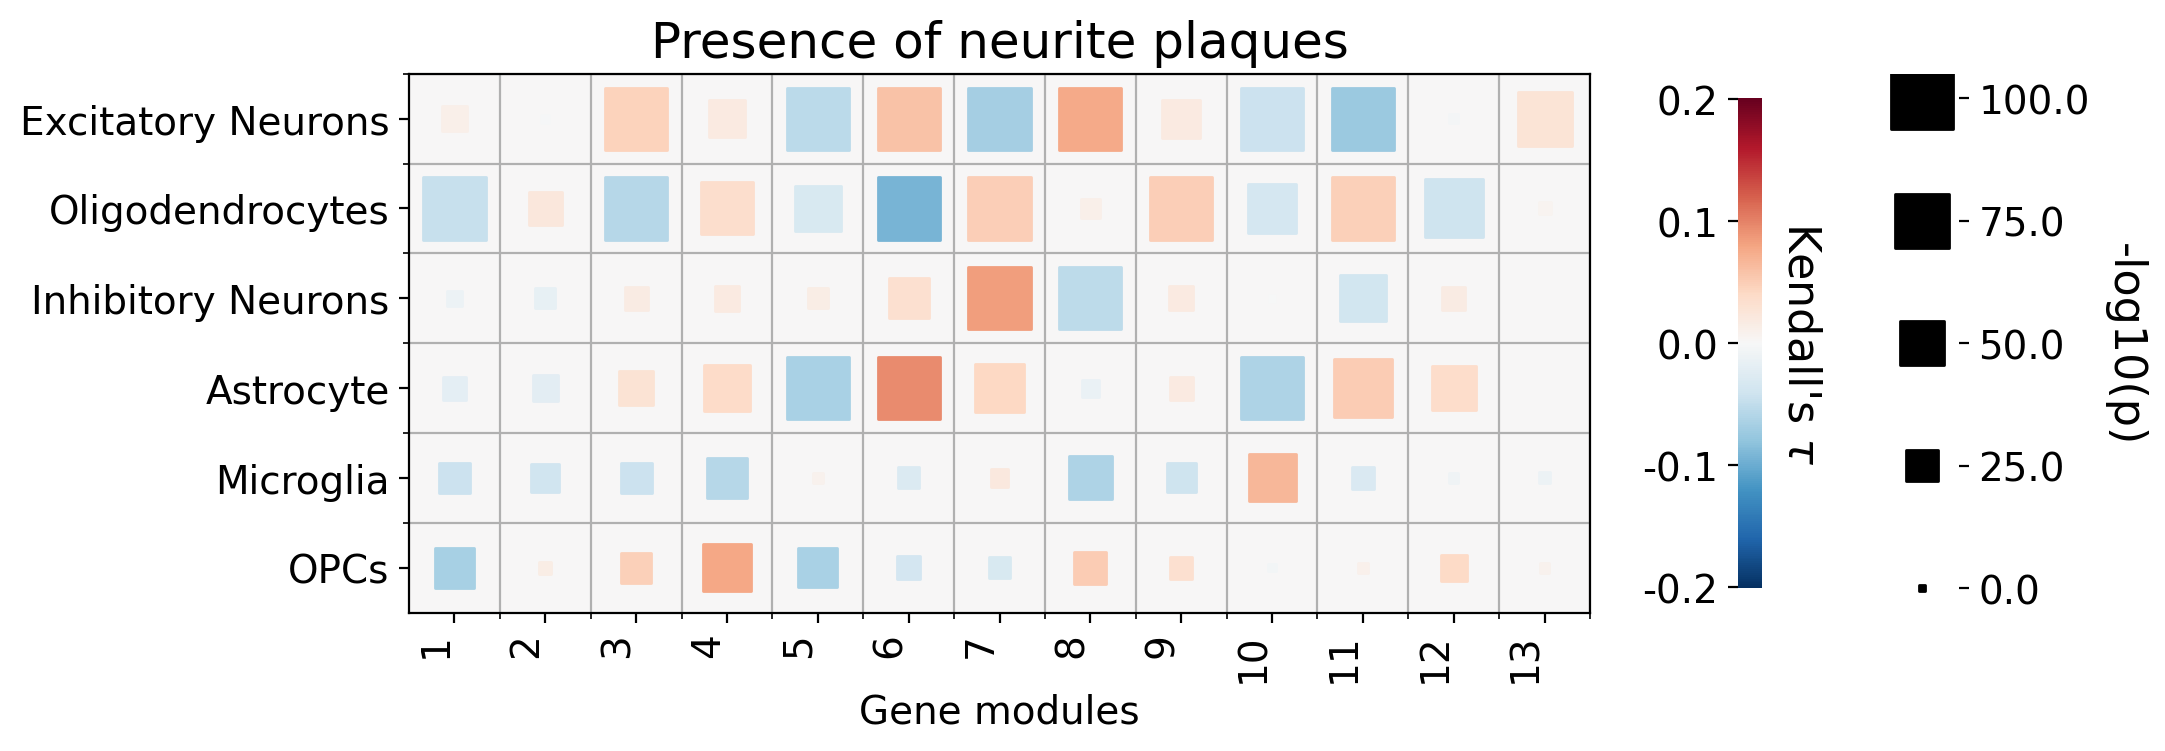

MMSE score
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


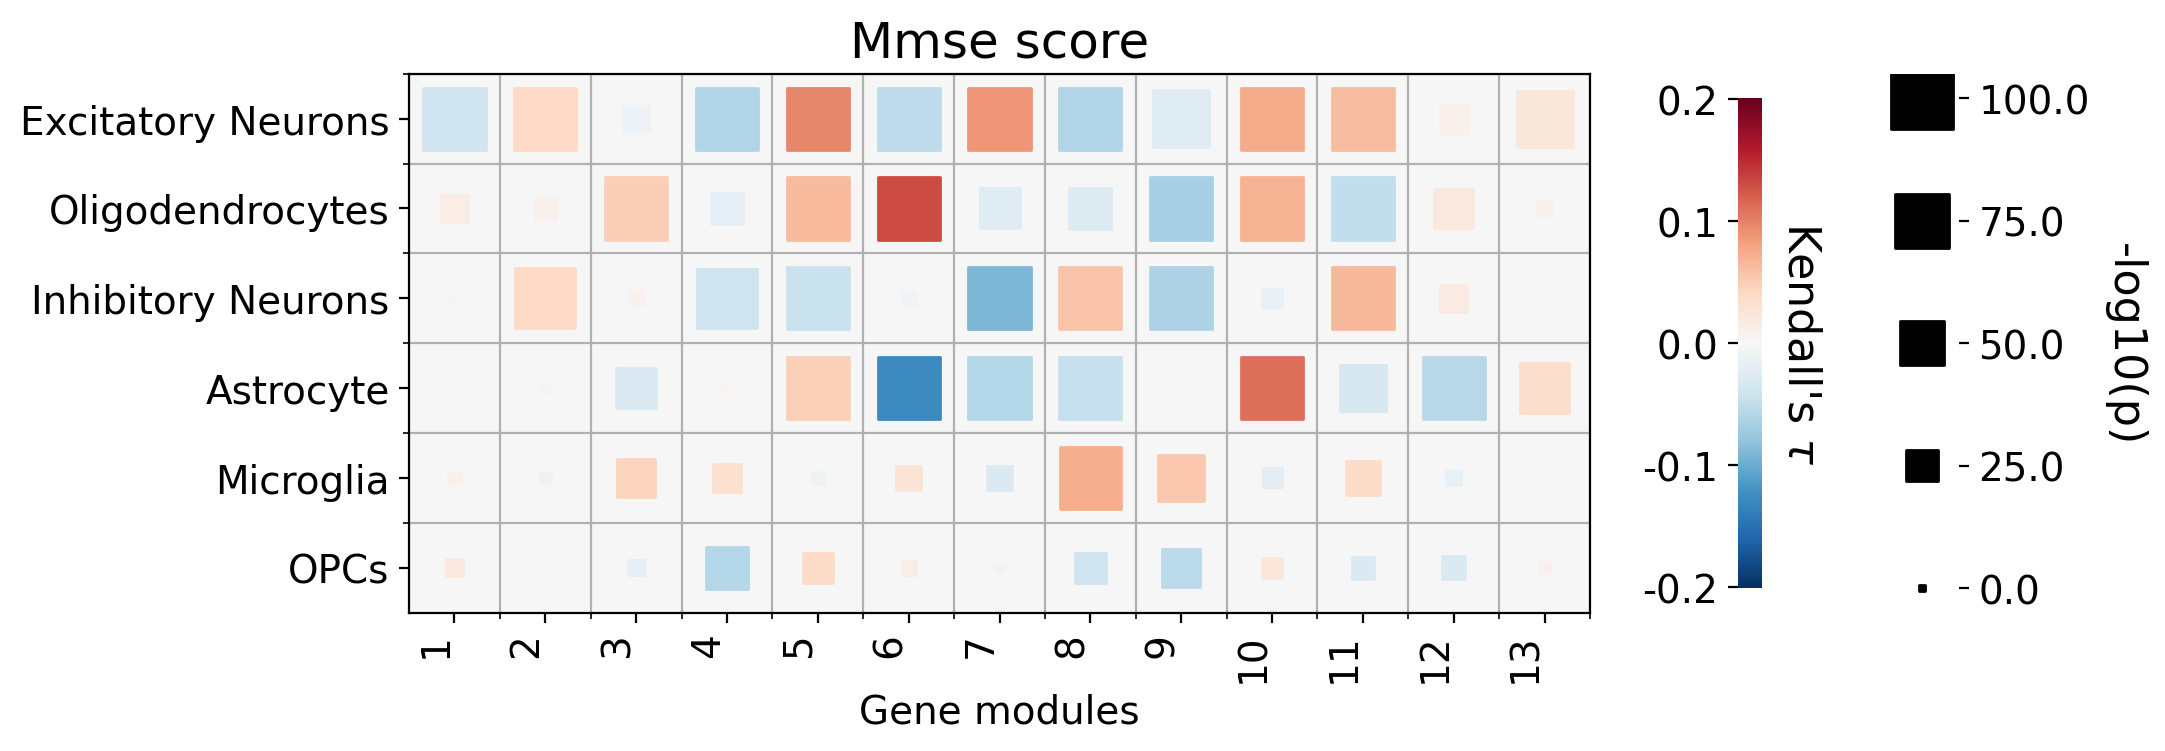

Global cognitive function
{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


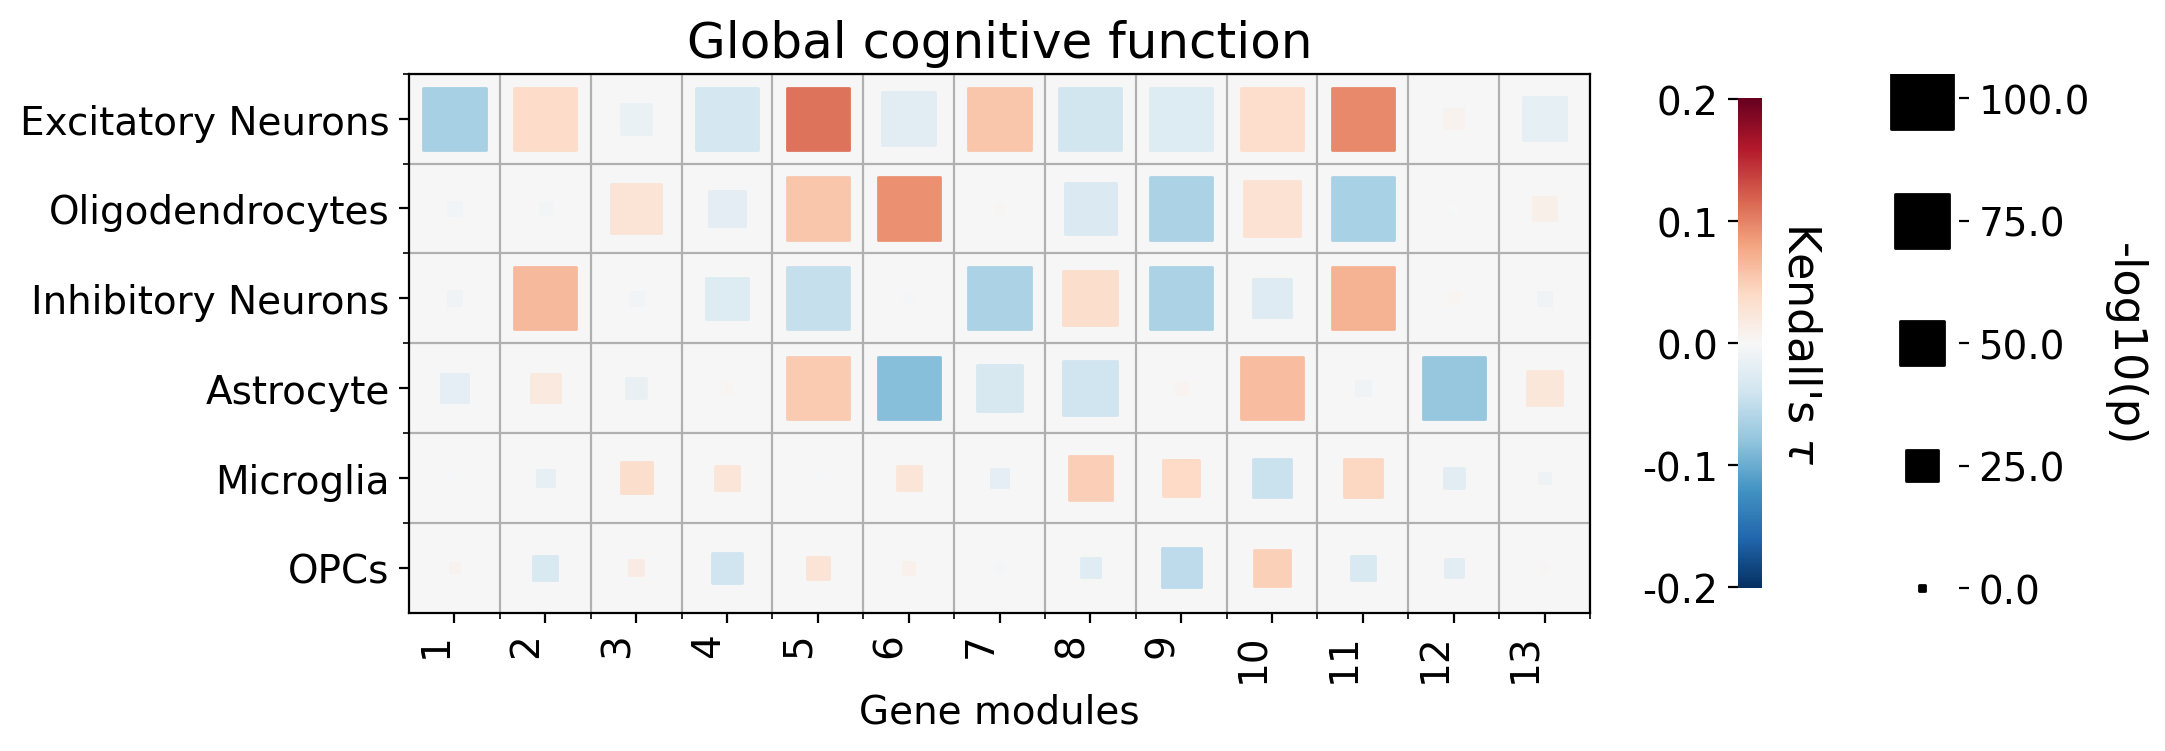

Global AD pathology burden


/tmp/ipykernel_1074156/2584148961.py:25: RuntimeWarning: divide by zero encountered in log10
  size = -np.log10(pval.values.flatten())
/tmp/ipykernel_1074156/2584148961.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 25.0, 50.0, 75.0, 100.0]
[5.0, 128.75, 252.5, 376.25000000000006, 500.0]


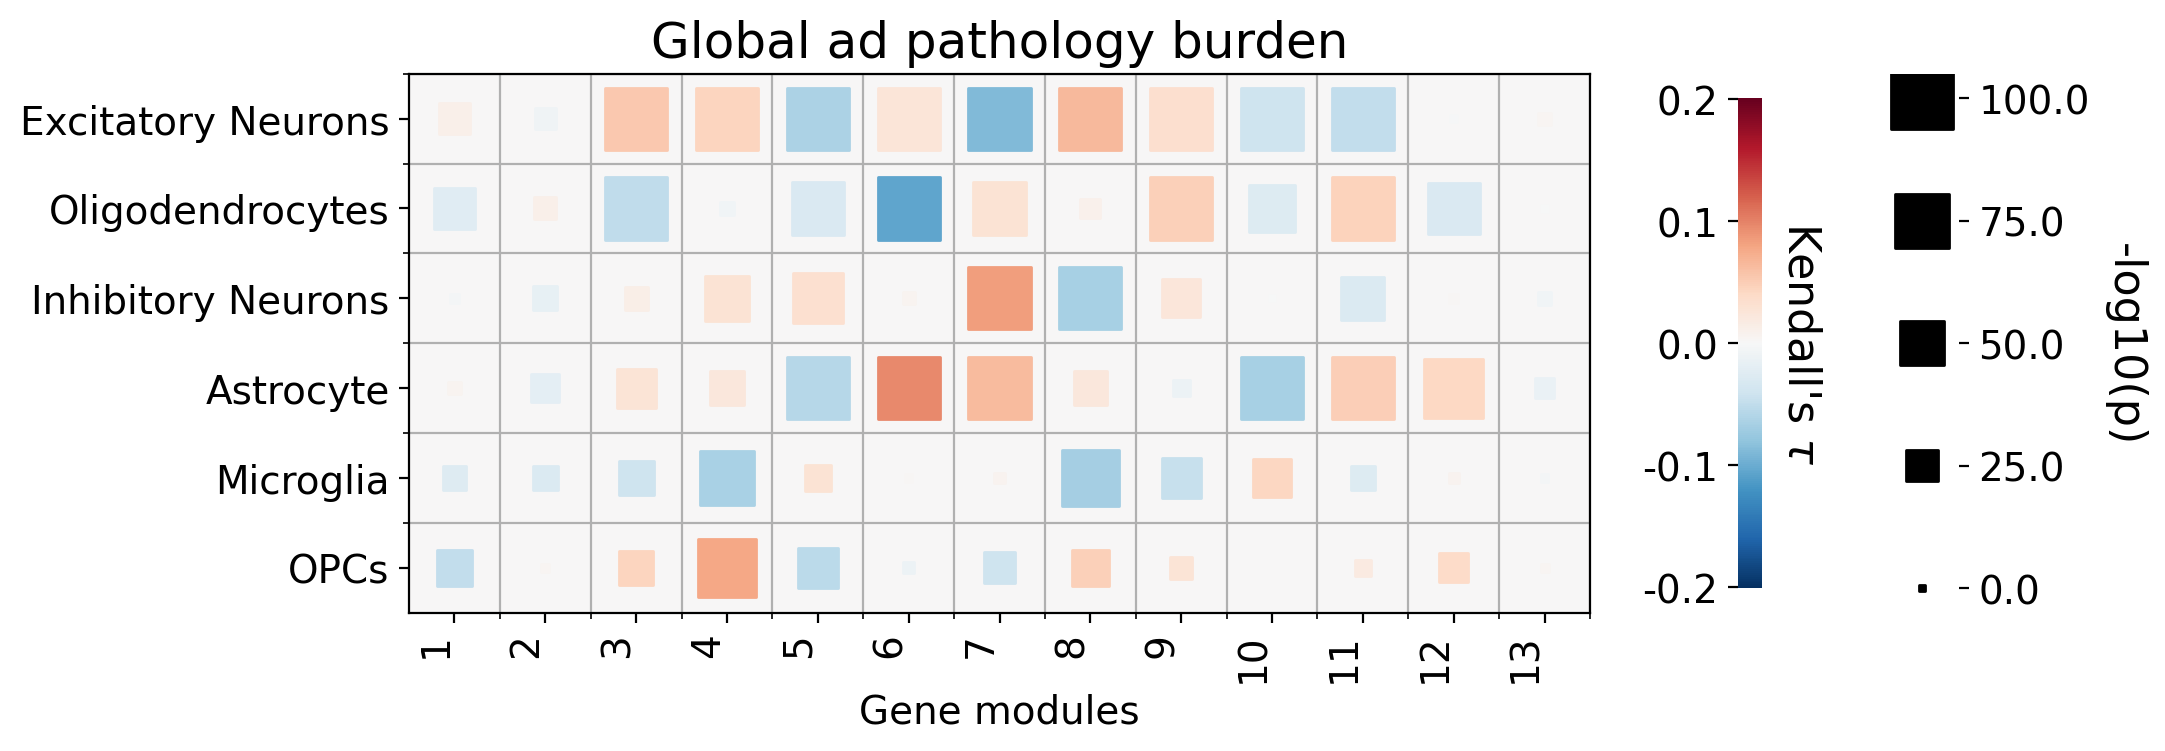

In [12]:
for sex in ['males','females']:
    print(sex)
    for col in ordered_clin_cols:
        
        df = pd.DataFrame()
        pval = pd.DataFrame()
        print(col)
        for cell_type in cells_order[0:6]:
            # print(cell_type)
            sex_df = pd.read_csv(f'material/RADC/coefs/{sex}/model_1_{cell_type}.csv', index_col=0)
            pval_df = pd.read_csv(f'material/RADC/pvals/{sex}/model_1_{cell_type}_pval.csv', index_col=0)

            corr_coefs = sex_df.loc[col].ravel()
            corr_pval = pval_df.loc[col].ravel()

            df[cell_type] = corr_coefs
            pval[cell_type] = corr_pval

        df = df[cells].T
        pval = pval[cells].T

        x = np.tile(df.columns, len(df.index))
        y = np.repeat(df.index, len(df.columns))

        size = -np.log10(pval.values.flatten())

        color = df.values.flatten()
        palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]

        f = plt.figure(figsize=(10, 3.5), dpi=200)

        ax, ax1, ax2, ss = heatmap(
            x=x,
            y=y,
            y_order = cells,
            size=size,  # inverse p-values
            size_scale=500,
            size_range = (0,100),
            color=color,           # NES values
            color_range=(0, -0.2, 0.2),  # center=0, min=-2, max=2
            palette=palette,
            marker='s',
            fontsize=14,
            x_tick_rotation=90,
            num_size_label=5,
            m_color='black',
        )

        cmap = plt.get_cmap("RdBu_r")
        norm = mcolors.Normalize(vmin=-2, vmax=2)

        # Get RGBA color for NES = 0
        color_at_zero = cmap(norm(0))
        ax.set_facecolor(color_at_zero) # Make background white

        ax1.set_ylabel(r"Kendall's $\tau$", fontsize=16, rotation=-90, labelpad=4)
        ax1.yaxis.set_label_position("right")

        ax2.set_ylabel('-log10(p)', rotation=270, fontsize=16, labelpad=20)
        ax2.yaxis.set_label_position("right")

        ax.set_title(col.capitalize(), fontsize=18)
        ax.set_xlabel('Gene modules', fontsize=14)
        plt.show()

        plt.savefig(f'material/RADC/plots/{sex}/clinical_corrs_{col}_{sex}.png',dpi=200, bbox_inches='tight')
        plt.close('all')

